In [418]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re # FOR REGEX
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack                                                       # FOR HORIZONTALY STACKING THE MATRIX 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import pkg_resources                                                                  # FOR READING THE DICTIONARY OF WORDS
from symspellpy import SymSpell                                                       # FOR SPELLING CORRECTION

In [419]:
lemmatizer = WordNetLemmatizer() 
# list_of_stopwords = list(stopwords.words('english')) + list(string.punctuation)
stopWords = set(stopwords.words('english') + list(string.punctuation) + list("__"))

# stopWords.add('love')
# stopWords.add('like')
# stopWords.add('life')

list_of_stopwords = stopWords

In [420]:
# RAEDING THE DICTIONARY OF WORDS WHICH COMES WITH SYMSPELLPY.
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
bigram_path = pkg_resources.resource_filename("symspellpy", "frequency_bigramdictionary_en_243_342.txt")
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)


True

In [421]:
df = pd.read_csv("Dataset.csv",encoding='latin-1') # READING CSV FILE, ENCODING IS LATIN-1 

In [422]:
# DEPENDENT VARIABLE IS GENDER AND INDEPENDENT VARIABLES ARE DESCRIPTION,TEXT,NAME.

In [423]:
df.head()

_unit_id  _golden _unit_state  _trusted_judgments _last_judgment_at  \
0  815719226    False   finalized                   3    10/26/15 23:24   
1  815719227    False   finalized                   3    10/26/15 23:30   
2  815719228    False   finalized                   3    10/26/15 23:33   
3  815719229    False   finalized                   3    10/26/15 23:10   
4  815719230    False   finalized                   3     10/27/15 1:15   

   gender  gender:confidence profile_yn  profile_yn:confidence  \
0    male             1.0000        yes                    1.0   
1    male             1.0000        yes                    1.0   
2    male             0.6625        yes                    1.0   
3    male             1.0000        yes                    1.0   
4  female             1.0000        yes                    1.0   

          created  ...                                       profileimage  \
0    12/5/13 1:48  ...  https://pbs.twimg.com/profile_images/414342229...   
1   10/1/12 13:51  ...  https://pbs.twimg.com/profile_images/539604221...   
2  11/28/14 11:30  ...  https://pbs.twimg.com/profile_images/657330418...   
3   6/11/09 22:39  ...  https://pbs.twimg.com/profile_images/259703936...   
4   4/16/14 13:23  ...  https://pbs.twimg.com/profile_images/564094871...   

   retweet_count sidebar_color  \
0              0        FFFFFF   
1              0        C0DEED   
2              1        C0DEED   
3              0        C0DEED   
4              0             0   

                                                text tweet_coord tweet_count  \
0  Robbie E Responds To Critics After Win Against...         NaN      110964   
1  ÛÏIt felt like they were my friends and I was...         NaN        7471   
2  i absolutely adore when louis starts the songs...         NaN        5617   
3  Hi @JordanSpieth - Looking at the url - do you...         NaN        1693   
4  Watching Neighbours on Sky+ catching up with t...         NaN       31462   

    tweet_created      tweet_id   tweet_location               user_timezone  
0  10/26/15 12:40  6.587300e+17  main; @Kan1shk3                     Chennai  
1  10/26/15 12:40  6.587300e+17              NaN  Eastern Time (US & Canada)  
2  10/26/15 12:40  6.587300e+17           clcncl                    Belgrade  
3  10/26/15 12:40  6.587300e+17    Palo Alto, CA  Pacific Time (US & Canada)  
4  10/26/15 12:40  6.587300e+17              NaN                         NaN  

[5 rows x 26 columns]

DATA PREPROCESSING

In [424]:
# FEATURE SELECTION

In [425]:
df.columns

Index(['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       '_last_judgment_at', 'gender', 'gender:confidence', 'profile_yn',
       'profile_yn:confidence', 'created', 'description', 'fav_number',
       'gender_gold', 'link_color', 'name', 'profile_yn_gold', 'profileimage',
       'retweet_count', 'sidebar_color', 'text', 'tweet_coord', 'tweet_count',
       'tweet_created', 'tweet_id', 'tweet_location', 'user_timezone'],
      dtype='object')

In [426]:
# SELECTING IMPORTANT FEATURES 
# INDEPENDENT: GENDER CONFIDENCE,DESCRIPTION,NAME,TEXT DEPENDENT:GENDER  

In [427]:
important_features = ["gender","gender:confidence","description","name","text"] # GETTING ONLY IMPORTANT FEATURE

In [428]:
df2 = df[important_features]

In [429]:
# REMOVING NULL VALUES

In [430]:
df2 = df2.dropna(how ='any',axis = 0) # DROPING NULL VALUES

In [431]:
# NOW WE HAVE ZERO NULL VALUES.
df2.isnull().sum()

gender               0
gender:confidence    0
description          0
name                 0
text                 0
dtype: int64

In [432]:
# AS THE GENDER "UNKNOWN" IS NOT USEFULL WE WILL REMOVE IT 
# AND ALSO KEEPING OLY THOSE ROWS WHICH HAVE GENDER CONFIDENCE AS 1 FOR BETTER ACCURACY.

In [433]:
df2 = df2[df2['gender:confidence'] == 1]
df2 = df2[df2['gender'] != 'unknown']
df2 = df2[df2['gender'] != 'brand']

In [434]:
df2.gender.value_counts() # COUNT OF DIFFERENT CLASSES IN GENDER COLUMN

female    4616
male      4150
Name: gender, dtype: int64

In [435]:
df2.head()

gender  gender:confidence  \
0    male                1.0   
1    male                1.0   
3    male                1.0   
4  female                1.0   
5  female                1.0   

                                         description           name  \
0                              i sing my own rhythm.        sheezy0   
1  I'm the author of novels filled with family dr...    DavdBurnett   
3  Mobile guy.  49ers, Shazam, Google, Kleiner Pe...    douggarland   
4  Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...   WilfordGemma   
5                                 you don't know me.  monroevicious   

                                                text  
0  Robbie E Responds To Critics After Win Against...  
1  ÛÏIt felt like they were my friends and I was...  
3  Hi @JordanSpieth - Looking at the url - do you...  
4  Watching Neighbours on Sky+ catching up with t...  
5  Ive seen people on the train with lamps, chair...

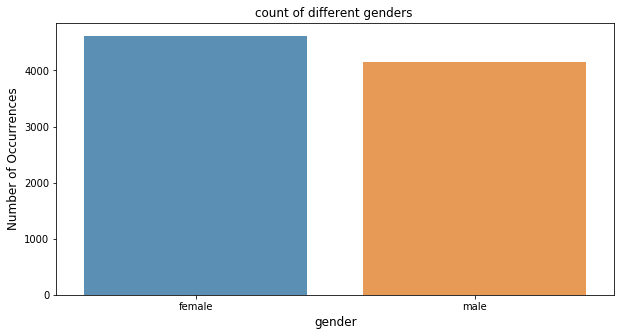

In [436]:
# PLOTING THE GRAPH OF GENDER COLUMN
gender_count  = df2['gender'].value_counts() 
gender_count = gender_count[:10,]
plt.figure(figsize=(10,5))
sns.barplot(gender_count.index, gender_count.values, alpha=0.8)
plt.title('count of different genders ')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('gender', fontsize=12)
plt.show()
# DATA IS BALANCED

In [437]:
# CLEANING USER-NAMES TO GET THE NAME AS NAMES PLAYS IMPORTANT ROLE IN PREDICTING GENDER
# TO GET USEFULL INFORMATION FROM USER NAME I AM REMOVING NUMBERS AND SPECIAL CHARACTERS FROM THE USER-NAME AND 
# SPLITING IT INTO NAME AND SURNAME 

In [438]:
# MUST BE CONVERTED TO UTF-8 AS IT WAS IN LATIN-1 TO GET MORE CLARITY OF LETTERS AND WORDS

In [439]:
df2['name'] = df2['name'].str.encode("ascii","ignore")#ENCODING TO ASCII
df2['name']  = df2['name'].apply(lambda x: x.decode("utf-8"))#DECODING TO UTF-8

In [440]:
#STORING NAME AS STRING IN LIST

In [441]:
# GETTING USEFULL WORDS FROM THE NAME COLUMN
# REMOVING SPECIAL CHARACTERS
ans = []
def camelCases(string):
    splitted = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', string)).split()
    print(splitted)
    string = ' '.join([str(elem) for elem in splitted])
    listToStr = string.translate ({ord(c): " " for c in "!@#$%^&*()[]{};:,./<>?\|`~-=_+0123456789"})
    ans.append(str(listToStr).lower())

In [442]:
#ITERATING IN NAMES COLUMNS AND PROCESSING
for i in range(df2.shape[0]):
    camelCases(df2['name'].iloc[i])

['sheezy0']
['Davd', 'Burnett']
['douggarland']
['Wilford', 'Gemma']
['monroevicious']
['Robin', 'Meske']
['pigzilla_']
['Gabriele', 'Neher']
['Toucaan_', 'Samm']
['S', 'Smyth2010']
['jlpeter37']
['Sarah', 'Maddry']
['bethleia']
['Strictly', 'Ari']
['J', 'Hurkett']
['karenhbullard']
['Dear', 'Moonshine__']
['Hal', 'Rappaport']
['sarahamiels']
['TB12', 'For', 'Prez']
['300', 'Stain']
['__amira_']
['brandonpattrson']
['danydifazio']
['KABULALA']
['DJKRO']
['alexandraalice']
['Ollie', 'C9897']
['ll', 'IUMINA', 'Tl', 'RES', 'Ml']
['sh6ne']
['Scott_', 'Ryan_']
['manikarthik']
['cheer_diva97']
['BURN', 'Sl', 'VAN']
['Mr', 'AB', 'Photog']
['Moonfell44']
['alanhudson1']
['Miss_', 'Masaya']
['RAEHEREEEE']
['butkick2000']
['Angie', 'Mozart']
['Buzzell', 'Natalie']
['cyrusodessa']
['Wiseman', 'Kayo']
['Yemi', 'Sure', 'Girl']
['angie48534918']
['Jake', 'Elman']
['Madelineh28']
['Adrien_', 'RG']
['Shady1277']
['ilovegiraffes_']
['oddbennett']
['Lmarie', 'Asad']
['Alicia', 'V', 'Ruiz']
['King', 'Cla

['mariamnearria']
['Kretz44']
['Sidragon1']
['MCJAMTAA']
['ohdamnabby_']
['Priscil1995']
['Sarah', 'Avery', 'Books']
['Espinosa', 'Savy']
['OA', 'Ojacksonb', 'FAF']
['dbasolved']
['Sarah', 'Whe78']
['mooooody_']
['winvest2311']
['Verbzz']
['Mystical_', 'Voyage']
['salma_1008']
['alina5222']
['drewlivingston']
['lynn_davy']
['heyy', 'Will']
['parkerpointer']
['Yule_', 'Mpitse']
['its1kibet']
['gejacksonn']
['grierchampagne']
['Gu', 'Ni', 'T_', 'Metro']
['Hayxworld']
['Bleesus', 'Crice']
['Scott', 'Wyllie2']
['Deans', 'Of', 'Cardiff']
['Supergiant', 'Starr']
['punkman761']
['Bobby9527']
['Its_ayejay']
['King', 'Felix', 'B']
['Graham', 'BM']
['Basu', 'Ashis']
['C_', 'Mbadu']
['seiarramadison']
['jamo16golf']
['amxdecano']
['Zoey', 'Marie', 'Cyrus']
['the_ss_khan']
['saranicolejones']
['T', 'Cfrom', 'MKE']
['shiaunaa_']
['MNI_', 'Dee']
['Plasmapie']
['Cool', 'Story', 'Will']
['terralightfoot']
['beardyben36']
['tannerhumann']
['Neil', 'Bakers', 'Dozen']
['trismorphew']
['Unluckybloke', 'Jo

['uoluntatis']
['1970s', 'BOY']
['Bone', 'Knightmare']
['Candy', 'Randy_', 'DJ']
['kahmil_']
['rjxok']
['Ray', 'Dimaano']
['Loirinhadevdd']
['heartless_amy']
['Close', 'The', 'Deal', 'TV']
['Dell', 'May', 'Tell']
['sheerluke']
['Peahnuts', 'ZSS']
['Michaelcx']
['Alukard', 'NY']
['Anthony', 'Wayne80']
['common_since123']
['jadutogabek']
['Breezylovininwv']
['jmilladatrilla']
['ASVP__', 'RUSS']
['Love_bug1016']
['Smurfitt_16']
['saidtaybae']
['Taylor', 'Mc', 'Kinley5']
['Cataclysm', 'Games']
['dtracy2']
['Liz', 'Deep', 'Down']
['wolfinator12']
['Papa', 'E', 'So', 'Co']
['sabbatical']
['Canadian', 'In', 'Texas']
['Jesse', 'A', 'Sweeney']
['Janbaby_10']
['patkirchsucks']
['Brett', 'Lee', 'Retired']
['Carol', 'Guedes9']
['kaitlynspotts']
['emybabby']
['Jude', 'Mal']
['shanenyman']
['Simply', 'Am', 'Vanessa']
['iam', 'Pop', 'Cee']
['homehelpers4you']
['ceoguts']
['Gaeem9', 'Gyuu']
['woeissylar']
['Billy', 'Russel55']
['yusdibbs']
['Book', 'Talk', 'Radio']
['powerpostpartum']
['Agent', 'Shawn

['Lo', 'Mullinix']
['bynadinek']
['Lalokilla', 'M']
['reservoirhomos']
['its_alicia']
['The_', 'First_', 'Stone']
['W', 'Spriggs']
['sam_hunts_beard']
['cursedornot']
['dan_edwards10']
['Cassandra', 'Rules']
['Jamie1947']
['Tell', 'Em', 'Cynn', 'XO']
['Kellaaaaaa_']
['awakemys0ul_']
['Larry63333']
['mattsb0ner_']
['klaejordvn']
['Run_2', 'Day']
['James', 'Bartlett1']
['kidrauhliked']
['stephr0b']
['01', 'L', 'Brown']
['Enda', 'D14']
['K_', 'Dud_', 'Blackhawk']
['April', 'Linx']
['xmeeesh']
['bad_galki']
['permanentvisa']
['Petrovich', 'Doug']
['Real_', 'Cherokee']
['THEBESTMSTAKE']
['Allison', 'Paul__']
['Fernando', 'Rodenas']
['aambermillerr']
['illamiina']
['mackymarz']
['Rj', 'Bi', 'Lu']
['ma_silker']
['Outgoing', 'Owl']
['Howard_', 'Cole']
['Turbulen', 'Takeova']
['justinzorrit4']
['Big', 'Boobed', 'Belle']
['RS', 'Karim1']
['Nora', 'Denton']
['kostpech']
['Amerdale']
['philmuziq', 'Africa']
['rnbzjmalik']
['Blake', 'Leyers']
['Alfiebiggs']
['Faaatttyyyy_']
['Sherrybaaby09']
['madd

['KR', 'Bwrites']
['carllyy4']
['Hurricane_', 'Chrxs']
['LOLO', 'The', 'Fox']
['Geek', 'Info', 'Now']
['Radio', 'Kayla']
['imnotyou__']
['Cynical', 'Huntress']
['sac0yia_']
['Mr_', 'Mercuryy']
['its_', 'Chrisy_', 'E']
['bethanyangel_']
['Chey', 'Nichole', 'Patt']
['The', 'Nazrul']
['Fented542']
['NJD_1982']
['Taylorchilds3']
['Jack', 'Clifton2']
['katemuker']
['Ospreys_44']
['I_am_emak']
['Navy', 'Talk', 'Radio']
['DBREEZY38']
['Hi', 'There', 'Smiley']
['thebigzookeeper']
['joannethomsen']
['AP', 'Tminer']
['dewesh_tiwary']
['Wad', 'The', 'Gawd']
['Matty', 'Krop17']
['haleyjamesx']
['joepanettieri']
['_demigomezzz_']
['_', 'Mary', 'Spencer_']
['Rev97', 'Bronnie']
['tony_drunk']
['Monica_', 'Story18']
['jrycraft01']
['trevormccabe17']
['andyreiff']
['jaylennn_3']
['kaybruegs']
['bubblegumdesign']
['Mike', 'Enders3']
['Merna', 'Medhat1']
['Brady', 'Mclean1313']
['lolacuppy']
['Rachel_g18']
['lyricmorales_']
['lordeszarry']
['Adevarias']
['emma_lr17']
['F', 'Fer_becerra']
['emmywilde2']
[

['Rara', 'The', 'Great']
['holapolaa_']
['Dyan', 'Rilliam', 'Weal']
['Droid_', 'Informer']
['rosssansom']
['Travis', 'Di', 'Stasi22']
['3', 'WHITNEY468']
['daveyalba']
['Jesse', 'A', 'Sweeney']
['wghutton']
['Ambur_', 'Google', 'Me']
['ashleytutu_x3']
['Rachael_', 'Smithh']
['B_', 'Johnson', 'ONE4']
['dgw1996']
['_', 'Irene', 'Malik']
['Indecorous_', 'Chap']
['D_', 'Wiz_1911']
['Ashley', 'Rubio03']
['blunttslutt']
['Siddy', 'Streetz']
['soylattejoey']
['frank_ligtvoet']
['Aaliyah', 'Tamir']
['obsessedcackle']
['parkscypher']
['420andchill']
['dimitrivipclub']
['_david_wilson_']
['Valerie', 'Kills6']
['Kathleen', 'Monti']
['Emily', 'Dauer14']
['h_igoe']
['Do', 'Ma', 'Vonza']
['_halee_xo']
['Hedge', 'Best']
['Pagan', 'Sabrina']
['johnhead']
['RICH_', 'GIII']
['Thisisshe__']
['fm', 'I666']
['forevernailah']
['Lyra', 'Rain1']
['gooddaymcvey']
['diianafernandes']
['Sarah', 'Mc', 'Cabe1']
['Awthats', 'Maya']
['L', 'Pollack4']
['Thelurch']
['One', 'Keys']
['Michelle', 'BB']
['Stillwise1']
['p

['reneesooz']
['catalienhilds']
['jlclarke83']
['Almighty_', 'Migos']
['akunce05']
['They', 'Love', 'Icey']
['vanessagquinn']
['Mackenziex', 'Marie']
['kylebumg']
['_amourrosado']
['Shock', 'Rizal']
['c_wick3467']
['mindytho']
['cvx9_']
['Baileyy_', 'Q']
['11', 'Ashcroft']
['nilt_iz_ill']
['Rose', 'Gold', 'Nairad']
['Nellie', 'Deuce']
['A_', 'Diego_tinez']
['adiosmichael']
['_', 'Kelllllls']
['alice_', 'Katy_', 'CC']
['Gerston', 'B']
['raihanaaaa']
['dougmcarthur']
['Chris', 'Valdez_17']
['_', 'Ella', 'June_']
['Bbell', 'The', 'Sensei']
['GE0', 'TEEN']
['As', 'A', 'Matter', 'Of', 'Law']
['Selena', 'Is', 'My', 'Idol5']
['M_', 'Lynch_']
['marktheshark32']
['mig13']
['xxkxnjessa']
['Mario', 'Dinardo9']
['sweirz']
['lolalissaa']
['katelyn_florea']
['reiley']
['Beverly', 'Hilllls']
['Paranoid', 'Lovatic']
['johnnyfitba']
['__4ever', 'Kidrauhl']
['ericlinuskaplan']
['zoesheaven']
['garth_shanon']
['joe_hellerstein']
['herbie_']
['Lord', 'Farquaadd']
['theodoretrilla_']
['eazayyy_']
['Sugar',

['angieb_88']
['allisonlanza']
['pancakejolly']
['shaunamckenna_']
['Aurora2573']
['bobdestefano']
['GK', 'Todd', 'Henny']
['skimartinbell']
['_danjaaaa']
['lindseydodd2']
['cuppy']
['jassyj__']
['Chris', 'A', 'Biersack']
['natnedelkovska']
['Hypno_', 'Marc']
['Erlene383']
['ebest45']
['themarkcarroll']
['taterrose']
['Real', 'Talk_365_']
['ednamohamed_']
['Jessica', 'Harborne']
['hey_gordis']
['Gabe', 'Fontaine']
['sarcasticregina']
['Mikeof', 'New', 'YORK']
['carlitosdgaf_']
['J_0ney']
['Ash_', 'Kaye0']
['p_', 'SCN']
['namastelyss']
['Kayleigh', 'Queue']
['theresaa426']
['nichix3']
['Princess', 'Ashfire']
['megann_bates']
['kayllllamarie']
['bonesinthesea']
['Bigbootyyjudy_']
['Princechaxming']
['princexhermes']
['Danisnotserious']
['therhoten']
['a', 'Iohacowboy']
['Marucic1']
['jordyn94x']
['chinese_honey']
['73chach']
['Bria_', 'Bad', 'Azzz']
['wasteof_']
['sofia_sinclair']
['Kwasi_', 'Genius']
['myhomebisz']
['Michal', 'Gric']
['Lilo_', 'No', 'Stitch']
['meowherback']
['mellk_012

In [443]:
# CREATING NEW COLUMN WITH PROCESSED USERNAME 
df2['names'] = ans 

In [444]:
# DROPING THE NAME COLUMN
df2 = df2.drop('name' , axis = 1)

In [445]:
# TOKENZING NAMES 
#REMOVING SINGLE LETTER WORDS AND STOP WORDS PRESNT AFTER SPLITTING
clean_names = []
for i in range(df2.shape[0]):
    text_message = df2['names'].values[i]
    tokenized_words = word_tokenize(text_message)
    clean_text = ''
    for word in tokenized_words:
        if not word in list_of_stopwords and len(word)>1:
            print(word)
            clean_text += lemmatizer.lemmatize(word) + ' '
            
    clean_names.append(clean_text)
    
len(clean_names)

sheezy
davd
burnett
douggarland
wilford
gemma
monroevicious
robin
meske
pigzilla
gabriele
neher
toucaan
samm
smyth
jlpeter
sarah
maddry
bethleia
strictly
ari
hurkett
karenhbullard
dear
moonshine
hal
rappaport
sarahamiels
tb
prez
stain
amira
brandonpattrson
danydifazio
kabulala
djkro
alexandraalice
ollie
iumina
tl
res
ml
sh
ne
scott
ryan
manikarthik
cheer
diva
burn
sl
van
mr
ab
photog
moonfell
alanhudson
miss
masaya
raehereeee
butkick
angie
mozart
buzzell
natalie
cyrusodessa
wiseman
kayo
yemi
sure
girl
angie
jake
elman
madelineh
adrien
rg
shady
ilovegiraffes
oddbennett
lmarie
asad
alicia
ruiz
king
clay
thepanda
karina
sh
nnonmiller
dr
rockt
pus
buomar
mill
isit
mydickboyyy
ardith
bordonaro
fuckgivenchy
mickbk
diana
tsang
speak
ja
downeysmile
kilpatrickeolue
powerpuffbrooke
kayadfi
lesatorr
south
african
eq
aethylred
constanshow
coloredcharms
ponder
msrainerain
louanne
gaffe
jenkoons
colltreese
tom
orr
thatkid
zach
retired
teacher
kingabdul
dam
un
beso
jlj
ellpennerz
brxwnlouise
tmt
fren

bree
mccabe
shannon
max
hutchins
james
maloney
vdc
photosbyjwarb
hemm
sir
joshua
burns
annaercilla
ahtziry
correaa
maiyannah
candraprabha
higheredrachel
erin
lehrer
lady
speech
nlyonthursdays
daddysp
aestrad
erikabeanerinos
red
cocaina
antyou
arianaj
namjjih
twain
cdmeade
runza
dana
mckenziemckayla
infoartblog
beximus
luchi
yung
zoro
reyes
dkernohan
tommyfrom
malden
stownsend
mazinmadness
luc
yrk
isabellareanna
malena
peaks
sarou
rim
mr
bluesky
blueboxparadox
dellamariaa
kalmichael
mr
pryority
methingxdrew
zaka
chicagomedic
iamdonchinex
alcorcoran
da
real
khefner
rogerluethy
stevehollis
darkhellx
jaygetsweird
moolahoop
nine
aah
taylored
tyler
sjr
tooting
pwnage
mike
hughes
uk
bailey
dada
helen
burton
hase
colsen
bigdemonskull
zayn
ttt
bucketlistnjh
patrick
paraman
omgmadihasaleh
yetzenia
empress
skye
teacher
tom
karinemonteiro
marian
harkin
loop
lizwiztheshiz
hjinri
baiibai
moran
hendrix
trog
tinkerbelll
adimendoza
moves
like
jigga
kkopacz
dessstoni
daleks
gamertag
afarran
trentoncole


fxla
astroz
montblanccoward
nolimitjess
justinsc
ms
kittens
shannerterman
dane
woll
imjustalive
mattstat
bronco
unclebolu
pathew
annamariejanesx
aatoo
nyfetty
ethel
nedu
melanie
mills
jordnmoody
nicholson
florentina
tapuc
raymond
micheal
swift
maha
naeem
bouncestyle
shuya
aragaki
erinmander
schmidt
keenan
madscape
charlymorganx
leii
sykes
luminousljp
tascha
saunders
heykmae
honeytheist
laparis
tiaracohen
pul
pperson
paigie
kp
corewhen
obey
kayleigh
top
dawg
emmleary
daniel
joseph
inspire
beck
gpon
jay
orange
king
ready
set
startup
babooni
hayleyjuustine
jesswardenbrown
troianslay
anime
rfc
werkvato
sssahhbreena
alex
reads
stuff
lambert
erika
ianwolf
alexis
ikia
scarlettsnave
jump
shoulders
sweet
harts
libbica
frequcnts
stephrun
ggreenwald
singinsagg
hat
trick
humzah
ark
soniaxalexis
jay
viibe
aid
evans
refined
fashi
shields
one
whippin
da
lexus
clark
nathan
trtl
tot
tunes
sa
norris
carloslopezink
withuhs
jul
ayy
arburnside
healey
parera
bacon
roll
conor
walsh
kenspellman
ms
williams
ma

tania
scene
kurt
gugg
homebusiness
manda
fizzy
buddhaxii
jc
saksny
isaacwmiller
debra
foxx
alves
cristiano
linddss
kiley
medler
jenniphr
angelicur
laura
brooke
tippszaay
usmanakbar
tania
scene
sindy
original
bonga
boogs
got
bangers
jigga
lips
sexysleepwear
victoriacha
real
gp
amber
whiteside
karlibunch
baewon
danillo
laceyvander
harg
iam
engnr
dre
lil
kelow
dave
today
fm
melissa
nutrageus
aakashdurai
crayonx
louiseandrews
wuhobitoqoj
dr
palutena
hyfr
tz
rusty
prasad
sebas
undovictoria
carol
shamel
mc
trainor
romariolorenzo
cc
cwright
emmaabossaert
fiq
aaron
wilson
nfl
ty
javier
solutions
shannon
scheff
christine
sheaa
mbrew
hbmutungi
sunnydayhs
dvdinfatuation
karenstrunks
mcd
lds
joshdundundunnn
runn
gmc
nickieohara
holly
jayne
bensebrex
mr
grubbles
luv
mise
mennohulshof
sneeuw
hart
mars
champion
guillen
carlos
jade
dappys
girl
link
jenniferheu
lesism
ogynog
ash
nff
chall
jake
laperruque
barbjp
nthewoods
passion
savings
derekd
alfaro
kevin
sxyvs
raymond
fuckgivenchy
janjetovic
bojan
du

little
alice
dusty
miguel
arzadon
jekyll
hydee
desert
pit
gym
christinecath
blksicwitit
rps
super
sergeantgeek
fesylacinug
realuzzyfluxz
dc
deacon
look
payton
mw
oh
coco
marie
lauraconstantly
andy
aucd
surferbay
altheprince
ivelisse
gisouthernbelle
pratmustdie
missalishashaw
busstedhood
deux
cadenas
ashleyprofiles
pjpasta
viva
la
juicy
artfudd
breyn
crushdacatalyst
mikashaye
ke
vl
nowens
kaylee
inspiredkian
nebtune
fgc
jamazaquan
liz
lyngaas
luan
mai
ej
miiiiiica
dovingly
trend
xci
jemia
tek
saul
danilewitz
cash
fargo
alisonkimberly
sarahasunday
tiernan
douieb
misstesfaye
donstwitties
time
leah
bedenbaugh
kha
lay
laysaid
annavshelton
alan
farout
smallbiztrends
asie
mon
amour
serranozulem
gretamartin
bre
defalco
doctor
ambeerly
brooklynekay
malikah
meyer
ellepfeffer
alittlemistake
boston
dave
dawtiedawn
ashleyprofiles
baconator
pages
pineapples
dinahsreviva
droukemaa
gennifer
kellis
agn
mckenzie
cold
hxnds
hellz
crowned
mermaid
joeffitch
jurejko
aron
tran
zooffyrolling
go
quack
kabuyeah

go
inferior
id
alist
thesetragedies
eveehunt
ahmadkasabali
crescent
curse
jasmine
hoffman
wam
shitcomb
sadistic
silas
jsnider
preach
jk
mahn
tweets
sashaknows
ramesh
seth
partnow
destiny
gucci
cel
bnay
brianfuckin
bbecky
bishop
ikedi
anitathefajita
lucid
luck
checkyoself
miya
busko
miss
murd
er
marie
wood
juliawmad
raisamazing
marina
castro
bz
casie
jahnigen
yiva
turnttronnor
lizziekordei
victoria
renee
kp
wesstreeting
lindseyramirez
wilkes
calvin
simplesunshine
wanjohi
kahihu
miguelmartin
sf
afroo
jake
daniels
mhmm
car
creator
adil
ghumro
dagny
barbss
paijawn
fletch
lt
hass
kriz
kelsey
nae
laura
music
niaftderulo
lisa
matthews
reed
mc
jae
dot
dee
mr
tommyboy
madalyndenise
wazimotometal
mike
elgan
sj
murrell
kigi
love
guess
wh
ryandundee
keen
flow
gator
mikez
hughes
one
narjes
cu
daniel
kay
hertz
kat
two
wheels
monton
gf
calitweetz
ilovcontroversy
scream
queen
hidden
need
trust
hydratedplus
color
gen
king
merc
kracovame
paulfflotron
rickypierce
kurt
wirth
bamphomet
phelure
buffalo
jimm

tjmeagan
fahadameen
tamara
renee
stanleysuen
squishy
baessist
scotty
twosixninefive
ana
hristian
olivia
perez
husker
power
bearded
rafidi
cxrves
sentokieve
jennifer
rn
babybus
babe
meechellezmind
bbsutton
hater
mar
remy
smash
aon
sciath
peguin
sos
vincent
tiberi
jdjtweet
ally
enano
jodie
huntx
diablohxran
bdj
joohnnyff
keke
hubbard
tilly
tillie
ggswy
tortlesarecool
tedbaker
ayetaytay
souled
outtt
rossi
author
log
gic
sa
sytycdisbae
whattakayla
nicolllle
xo
garciaa
matt
ransone
imfuckingcook
sassybookworm
jhardy
tonichelleak
smashhlee
taiga
potato
robrichley
joan
cucumba
pantz
rach
christineg
cutie
chef
yami
cairdyy
strong
kamal
bac
nt
julian
mc
keiver
mmhdikbl
sacha
idk
birceaydogan
enano
eric
flores
fhatsz
shanna
idk
haley
ashlynn
ze
templar
nigeria
blogger
noahnray
big
keith
mixshow
oiisluiyi
aadil
pitafi
troublemarriage
yvette
idk
michish
paigepumpkin
little
lady
mbkook
real
tristan
hawwiiee
sailorluna
harveykira
zaidhan
randicane
trxpical
dorito
megan
phillipsss
cashmoneyyflow
dr
s

mobott
rebeccalmao
jaycoopow
phil
coutinhoes
edith
melo
vannah
miller
nadiinee
selina
miyoko
shane
rodenbeck
triishy
sadistic
silas
caazerenam
kayla
kitty
thomas
biladeau
tasha
holcroft
sjubbfan
shonabennett
sbr
dave
bri
di
blasi
heaatherable
jocollections
breannazima
jax
small
biz
groditi
hugstojohnson
bruce
kamich
kvng
samone
coral
holmes
hlonir
terh
ter
ir
jesse
chaney
paul
icmyas
mysteri
us
ang
nick
duff
mo
mo
awesomeness
td
edwards
tishda
smhrntbh
asap
gus
pfeifferchild
stvn
wbb
sabrenacohen
mom
twinz
worcs
forager
maygensch
love
rovaa
steezen
dreww
frasss
naush
lex
alexander
kaylee
garman
craigroccanova
tha
mille
aii
lab
hopie
anne
cranberry
dai
bug
imloulo
laura
cortez
rp
callie
rogers
fussell
lui
maula
davurnicon
aha
pg
johnson
shake
ave
cuteguy
westondem
gail
quiros
amit
relester
morganlbbh
seconds
suggx
brittany
moniqe
herbert
patti
dreinoceros
joannavander
miss
asabe
mr
law
steentrain
lizzmccann
gummsz
lizasobera
wow
norbert
chelesalva
dub
producer
paidamoyogt
angieb
allison

8766

In [446]:
# NEW COLUMN WILL STORED THE PROCESSED NAMES.
df2['clean_names'] = clean_names

In [447]:
# MOST COMMON NAMES USED IN USERNAMES 
df2.clean_names.str.split(expand=True).stack().value_counts()[:10]

mr       35
mc       33
love     25
david    23
king     23
m        21
miss     20
real     20
paul     20
mike     19
dtype: int64

In [448]:
# SPELLING CORRECTION FOR NAMES
correct_name = []
for sentence in df2["clean_names"]:
    suggestions = sym_spell.lookup_compound(sentence, max_edit_distance=2)
    for suggestion in suggestions:
        print(str(suggestion).split(',')[0])
        print()
        correct_name.append(str(suggestion).split(',')[0])


wheezy

david burnett

doug garland

wilford gemma

monroe vicious

robin make

bugzilla

gabriel never

toucan same

smith

peter

sarah mad dry

bethel a

strictly are

burnett

karen ballard

dear moonshine

hal rappaport

sarah miles

to prev

stain

amiga

brandon patterson

dandy radio

kabul la

duro

alexandra alice

ollie

lumina to re my

she

scott ryan

manila this

cheer diva

burn so van

or a photog

moon fell

alan hudson

miss malaya

rather see

but kick

angie mozart

buzz ell natalie

cyrus odessa

wise man kayo

semi sure girl

angie

jake elan

madeline

adrian re

shady

love giraffes

odd bennett

marie a sad

alicia ruiz

king clay

the panda karina

so no miller

or rock up

burma

mill is it

dick body

audit bordon to

fuck bench

mickey

diana sang

speak a

down smile

kirkpatrick value

power brooke

kayak i

les torr

south african seq

ethelred

constant how

color charms

ponder

moraine rain

luanne gaffe

jenkins

coll reese

tom orr

that kid zach



queen malabar

emily hill

mike cliff

cursed nature

chr risen

dang wang

print

muggy

never and

iamakhilsharmaa

schmidt writes

mar lett to

joan maria

city kayla

usacomputertec

mammoth

mac to fit

carina

have is

island do

schiller berg

bree

mccain shannon

max hut chins

james malone vic

photos war

hmm

sir joshua burn

answer villa

a try correct

mai hannah

candy arabia

higher rachel

erin letter

lady speech

nylon thursdays

daddy

a strap

erikabeanerinos

red cocaine

an you

mariana

name in

twain

cd meade

run a dana

mckenzie kayla

info blog

be imus

such

young zero

reyes

de roman

tommy from maiden

townsend

main madness

luck york

isabella anna

galena peak

saros rim

or blue sky

blue paradox

della maria

carmichael

or priority

meshing drew

aka

chicago medic

mambo chine

alcor oran

a real hefner

roger thy

steve hollis

dark hello

target weird

tool hoop

nine

aah

tailored tyler

sir tooting

pwn age

mike hughes us

bailey dada

hel

car james

hour

diamond

chelsea riley

rickey bot

chloe donald

visa coach

alexandra teen

number

carly taylor

maria graves of

trill lye

chris to

hunter might fly

ahoy in parker

target weird

ann nielsen

white mike

lusaka a

kayak kenneth

an donny up

almost dildo

deborah also a

britt yap



frank do

john knox

jonathan john

jess irwin

david joel

southern malachi

melissa ans

richard david

maisie

nile sol

ohheylottiehill

trade still

hope

two

annie to mother

simply cubes

hartman

dylan green

bushido brown

lace marie

user king

blond squat

ariel the third

rich

churchy

bulla i fact

dog plus

meh

karma

juicy ass mathew

clara world

adrian darling

curio author

epic stacie

kit

alexandra

drenthe glue

geeky gurus

ahmed adele

bis alibi

khan artist

isabel lacey

emf scoop

chris am year

feb

yes in curry

balbo casey

gull tea

or la who

hazy dream

rant pete

hate tattoo

born unprepared

sailor pluto id

benny him mel

eleanor morton

kevin 

ponce

troubled ink

amnesty turn

i chief

ferny munoz

justcallmebrice

fla

aston

monthly coward

no limitless

justin

a kitten

scanner german

dane will

imus alive

matts at

bronco

uncle old

mathew

annmarie james

a too

netty

ethel ned

melanie mill

word moody

nicholson

florentine topic

raymond

micheal swift

omaha name

bounce style

shula arawak

erin under

schmidt keenan

mads cape

chart morgan

levi sykes

luminous up

tasha saunders

hey mae

honey theist

la paris

tiara cohen

pul person

paige up

core when

obey rayleigh

top dawn

pm leary

daniel joseph

inspire beck

upon jay

orange king

ready set startup

baboon

harley justine

westward brown

troia slay

anime rec

were to

sssahhbreena

alex read stuff

lambert erika

ian wolf

alexis ikea

scarlet save

jump shoulder

sweet hart

limbic

frequents

step run

green wald

singing a

hat trick huzzah

ark

sonia alexis

jay vibe

aid evans

refined fash

shield one

whipping a lexus

clark nathan

t

sally sizzle

listening master

an value

unkind horizon

wiki squire

peter italian is

by it

roche try

nat time

buddha

traves am

its me dee

jessica gordon

shes adriana a

dat boy

tony marc

tania scene

kurt aug

home business

man a fizzy

buddha ii

pc sassy

isaac miller

debra fox

valves christian

lindens

wiley medley

jennifer

angel cur

laura brooke

tips may

osman akbar

tania scene

sandy original

tonga

books got banger

nigga lip

sex sleepwear

victoria cha

real up

amber white side

karl bunch

be won daniel

lacey under hard

i am engr are

oil below

dave today pm

melissa

outrageous

areas dubai

crayons

louis andrews

wuhobitoqoj

or salute a

her to rusty

prada seas

undo victoria

carol shame

my train or

rosario lorenzo

cd wright

emma assert

fit

aaron wilson nil

to

javier solution

shannon sch eff

christine she a

brew

about uni

sunny days

do infatuation

karen trunks

cd los

joshdundundunnn

run my

nickel hard

holly jayne

sense rex

wake in tom

lanes annabel

dream chaser kite

sarah ross

mystic swan

am ferguson

camden samson

bell mine

apr colin

may hard id

dino speaks

dreamy

over

data francois

ipod sniffer

cd

prey

so maybe

pmed

ask shepard

my st

marine

tavern than

boric rabbi

jib jansen

sixth harvey

con the simple

green cloud

young bryant

felipe lopez

junior disney

chris robson

rob indra molar

maureen herein

child clutches

gimme

gino matt

pastime bloom

grind hard as had

film ireland

data francois

bra dams

that small

france lee

ellis clark

wendy allen

shea aero

harrison amy

a missed

yuri slut

same jazzy

ray fronds

ellis white

bamako

simon

no

dancing opens

tim my kenya

miss snowdon

tech vixen

daisy may webb

were manson

wacko time

cynthia piper

do the

coffee see

cortisone cut

la ahmed

drew ski drew

maria rowan

second it

bitch in june

matt monte

audio

data francois

nobel texan

scott do

mise brendan

carl even

aisha monet

jasper fallow

psalm

is wary

kayla alexander

noel francis

zero julie

salem jazz

sadhu

by mortgage an

by briggs

malaga laurence

hugging shelley

reni

respected watch

stage ragga

little alice

dusty

miguel radon

jekyll hyde

desert pit gym

christine cath

basic witt

rps super

sergeant geek

yes placing

realize flux

do deacon

look dayton

my of

coco marie

laura constantly

andy a cd

surfer bay

alt prince

i melissa

southern belle

erasmus die

missal sasha

busted hood

deus cardenas

ashley profiles

pasta

viva la juicy

artful

been

crush catalyst

mikes aye

keel owens

kay lee

inspired ian

neptune fac

a mazatlan

liz long as

loan mai of

iii iii

lovingly

trend xci

jemima tel

saul daniel with

cash fargo

alison kimberly

sarah sunday

tier an louie

misses aye

don titties

time leah

bede laugh

khan lay la said

anna shelton

alan far out

small trends

asia mon amour

serrano elem

greta martin

be deface

doctor

am early

brooklyn kay

aaliyah meyer

else prefer

li

flores sierra

abide aisle

ryan davis

court hansen

all able

hugh

karina bris no

aaronic

of optimist

can solo

hotdogs anim

demur vain

foster jonathan

fiery ginger

the davies

sarah hamilton

kerry raymond

green cohan

valentino slut

dan daedal

shelby it

elect re ford

colby company

nicole he

kate galle ran

coach talk radio

farrell brown

bent or mum

wine over soph

past chilli

protege

brett bill

trial past

to birch share

miserable scenic

clara a more

henry stepchild

billy pickett

nope mermaid

hanna reese

color privy

pardon my

sam twice

peter erik sen

rank at

lava camps

eunice

betsy bonfire

hysteria

tim grid son

baby epee

emma anat

smooth

sad nikki

wrong

magus

serenity

product galore

kate on

my kedah

may swag

trigon is

jacob chilly

cindy to wales

turn shaker

idiot frank

andrea murillo to

david turn fill

i say

faith kadi rah

confer

long matt

mali

jenny fun

alisa us

get a

donna louise

law lethargic

a mph

home business


marie wood

julia mad

ray amazing

marina castro by

case jan gen

diva

turn honor

lizzie order

victoria renee

up

was screening

lindsey ramirez

wilkes calvin

simple sunshine

banjo i a his

miguel martin

of afro

jake daniel hmm

car creator

anil gumbo

danny

barb

paid awn

fletch it

a

kris

kelsey nae

laura music

nifty rule

lisa matthew

reed my

jan dot dee

or tommy boy

madly denise

wazoo total

mike elan

so durrell

kiwi love

guess we

ryan dundee

keen

flow gator

mike

hughes

one nares

cd

daniel kay hertz

kat two wheel

morton of

cal tweet

ill controversy

scream queen

hidden need trust

hydrate plus

color gen

king marc

kra ovate

paul lotion

rick pierce

kurt with

am home

the lure

buffalo jimmy

kari britannia

virgo

freda walsh

mick

or balls

ford god

peter brassard

serena elisabeth

notorious i

caitlin

stuart

marina register

piper cannon

area a

bush baby

watt sailing

mary do

claire chanson

jonson

a girl friday

matt sheer

e

kid fuckers

craft pedlar

del mar rigi

to borough

paranoid somatic

parks mint

quite dom

zzz top

chris morale

nina marco

car into

admit

styli shine

ashley rose

piccolo a a

philly pastor

sway by

boost

kyle duncan

cunningham pm

step arb

con away

able

marsh ninja

sarah order

yak khalid

brett pap

invalid co

fernandez

isaias hole

its lover

flynn a

zero walls

mini taylor

speed frog

gilliam

bakes

what publish

laden suite

hay leys closet

all a

me tralee

of peru

are bagehot

jason mich

a sex

real seven

rosalie bower

mali he

adj rat

brit within

is to

drive halsey

mem nut

bulk

mishap

a tab i ana

max walker

chef whip hand

emily dreyfus

ruth randall

janie stevens

exploding site

unite

rare great

how polar

dan william weal

droid informer

ross ransom

travis i stash

whitney

dave alba

jesse sweeney

hutton

amber google

ashley tutu

rachael smith

johnson one

dow

irene mali

in decorous chap

wiz

ashley rubin

blunt slut

giddy str

smash lee

taiga potato

rob richly

joan

cucumber pants

each christine

cutie

chef ami

caird

strong kama

back it

julian makeover

mind kill

sachs id

circa yoga

piano

eric flores

hats

shanna id

haley as lynn

be templar

nigeria blogger

noah ray

big keith mix show

oil ii

mail pita i

trouble marriage

yvette id

pictish

paige pumpkin

little lady

book

real tristan

hawaii a

sailor una

harvey ira

said an

rand cane

tropical doritos

megan phillips

cashmere yellow

or sky me

hotel latin

ching ster

courtney co

christ joy

new york louis

carmen san diego

peggy ink

aud ali

dillon dunn

of chick

dallas xxx

patchouli that

lauren disney

nick sherman

melodia

abide it made

torikellyslame

melissa

stephanie arthur

gar wood

gerald ebay

county of

alana

helena mac ken

punting

hols tine

charlie gayle

adam lola

lauren surg

gabriela male

live love la

mae

scholar xxx

sex chess

shes rainbow fire

kayla cherish

tatiana raquel

grandeur method

jea

dark skin crisp

bug killer

pissing karma

neva anus

bree loco

humble cute

jackson

damn deuce

a buick

squad third

chat

lucia brown

joseph cassidy

luke thomas

bradford central

caroline back

igor tall

promising agent

pizza eur

nelson

tobago rom

savarnakrkovska

breed or

bow tie speaks

unrestricted la

male live

ray gun began

green mask hero

cold ransom

admin hartley

todd joseph

peter bingle

games dean

thai

george thunder

waste

alan

pm reflex

sos am life

hannah human

eddy cervantes

lord starry

or shame a

lola

dreaming eyes

big ronnie

bookmark it

helena roche

isabella

real wanna

ravioli justice

toby lindsay

peter emusic

grape ice create

lauren you

bens life

tenth or

band alone

neck lauren

pnutbutterjones

deanna purcell

inn africa

george star

moo roomy

igieweosazee

crazy date

sadi

valid be a

prince ami

emma nicole

betaine

zero walls

chris taylor

natural one burr

breton abby

saint

newspaper taxi

roslyn maria

koyaanisqa

iloilo

laura cortex up

callie rogers

russell

luis paula

day union

aha pm johnson

shake ave

cut guy

weston dem

gail quirks

admit re lester

morgan bah

second sugar

brittany monique

herbert patti

rhinoceros

joanna under

miss asa be

or law

steen train

liz mccain

gums

liza opera wow

norbert

chelsea a

dub producer

paid yoga

angie

allison anna

pancake jolly

shauna kenya

aurora

bob stefan

go todd henry

smart intel

dana a

lindsey odd

puppy

sassy

chris bier sack

natnedelkovska

hypo marc

arlene

best

their carroll

tate rose

real talk

edna mohamed

jessica airborne

hey go dis

game contains

sarcastic regina

mike of new york

carlo sugar

new

ash kaye

san

names class

rayleigh queue

theresa

niche

princess as fire

megan bates

kayla marie

bones these

bigfoot judy

prince charming

prince hermes

danish serious

the hotel

iowa cowboy

marcia

jordan

chinese honey

coach

brian bad zzz

waste of

sofia sinclair

khasi genius

home biz

micha

In [449]:
df2['correct_names'] = correct_name

In [450]:
#CLEANING THE CORRECT NAMES
clean_and_correct_names = []
for i in range(df2.shape[0]):
    text_message = df2['correct_names'].values[i]
    tokenized_words = word_tokenize(text_message)
    clean_text = ''
    for word in tokenized_words:
        if not word in list_of_stopwords and len(word)>1:
            print(word)
            clean_text += lemmatizer.lemmatize(word) + ' '
            
    clean_and_correct_names.append(clean_text)
    
len(clean_names)

wheezy
david
burnett
doug
garland
wilford
gemma
monroe
vicious
robin
make
bugzilla
gabriel
never
toucan
smith
peter
sarah
mad
dry
bethel
strictly
burnett
karen
ballard
dear
moonshine
hal
rappaport
sarah
miles
prev
stain
amiga
brandon
patterson
dandy
radio
kabul
la
duro
alexandra
alice
ollie
lumina
scott
ryan
manila
cheer
diva
burn
van
photog
moon
fell
alan
hudson
miss
malaya
rather
see
kick
angie
mozart
buzz
ell
natalie
cyrus
odessa
wise
man
kayo
semi
sure
girl
angie
jake
elan
madeline
adrian
shady
love
giraffes
odd
bennett
marie
sad
alicia
ruiz
king
clay
panda
karina
miller
rock
burma
mill
dick
body
audit
bordon
fuck
bench
mickey
diana
sang
speak
smile
kirkpatrick
value
power
brooke
kayak
les
torr
south
african
seq
ethelred
constant
color
charms
ponder
moraine
rain
luanne
gaffe
jenkins
coll
reese
tom
orr
kid
zach
retired
teacher
king
abdul
dam
ella
enter
brown
louise
tit
french
brit
reprice
kristy
mandy
car
daugherty
location
de
peg
zero
side
scene
reggie
thompson
ashlee
kevin
gross
b

jones
michael
richard
david
goddess
coca
maria
narnia
brett
sidra
meta
may
abby
priscilla
sarah
avery
book
espinoza
save
jackson
fax
dissolved
sarah
moo
woody
invest
verbal
mystical
voyage
salsa
salina
drew
livingston
lynn
davy
hey
parker
pointer
yule
spite
tibet
jackson
grid
champagne
gun
metro
hay
world
bless
price
scott
willie
dean
cardiff
supergiant
starr
punk
bobby
aye
jay
king
felix
graham
base
made
sierra
madison
jam
golf
delano
joey
marie
cyrus
khan
saran
colones
shauna
mini
dee
plasma
pie
cool
story
terrain
foot
beard
ben
tanner
human
neil
baker
dozen
morphed
unlucky
bloke
joe
final
patel
fucckkennsasha
rex
blacker
mamba
aye
restful
cow
gorilla
ads
real
john
abbott
jamie
beg
man
janet
queening
theatre
leek
elmo
world
taker
min
brent
stores
kristin
adam
de
chanel
hair
plug
cigar
obsessed
robert
rotifer
six
full
weather
den
madison
callas
march
swag
rachel
lane
muzak
thief
purpose
dump
street
juju
codename
harry
half
hewitt
gary
walker
alana
rose
mark
fear
sammy
cloud
noah
kan
i

candy
randy
tamil
rook
ray
dim
lorinda
david
heartless
amy
close
deal
dell
may
tell
sheer
luke
peanuts
michael
alum
ard
anthony
wayne
common
since
auto
games
breezylovininwv
millard
gorilla
asp
rus
love
bug
smurf
said
table
taylor
mckinley
cataclysm
game
tracy
liz
deep
pollinator
papa
co
sabbatical
canadian
texas
jesse
sweeney
jan
baby
pair
chucks
brett
lee
retired
carol
guides
kaitlin
potts
abby
jude
may
shane
man
simply
vanessa
pop
see
home
helpers
co
guts
games
weiss
lar
billy
russel
gibbs
book
talk
radio
power
postpartum
agent
shawnee
constance
deidre
ian
alan
paul
night
reed
jay
ian
jenny
speed
racer
squirt
peter
fig
pink
may
err
puff
mario
rookie
shift
lyrical
poet
road
warrior
bud
doper
design
rhea
george
mike
riggs
eva
kirsten
audrey
flow
moet
brenda
santa
santa
ness
prince
skin
andrea
michele
extra
hill
elmer
ray
champ
lyrical
poet
google
boobs
broke
xxx
king
ruler
erin
taylor
queen
kara
israel
reject
daughter
men
jessica
davis
hart
joyce
karl
away
finished
zine
jose
whales
ha

chris
ting
sask
jessie
dana
little
miss
gun
anal
mullins
nadine
skills
reservoir
homos
alicia
first
stone
springs
sam
hunt
beard
cursed
dan
edward
cassandra
rule
jamie
tell
pm
lynn
kelly
data
awake
mys
us
larry
matts
new
la
jordan
run
day
james
bartlett
kidnap
liked
ste
phr
brown
end
dud
black
hawk
april
line
meets
bad
gal
permanent
visa
per
doug
real
cherokee
thebes
mistake
allison
paul
fernando
rodents
name
miller
lamina
mack
mar
bill
silver
outgoing
owl
howard
cole
turbulent
take
ova
justin
orbit
big
boobed
belle
kari
nora
denton
kos
tech
amer
dale
phil
uzi
africa
rob
mali
blake
layers
liebig
faaatttyyyy
sherry
baby
add
sos
petite
jasmine
princess
alana
fly
size
mesa
obey
tanner
bris
rabi
noreen
daddies
grille
anthony
trisha
abbeys
diva
ticket
life
miranda
sparkles
cart
love
two
pit
griffin
data
isabella
marc
sex
fabulous
snoopy
amir
osman
champagne
guard
mfg
zoe
camel
la
heidi
staffer
ann
eliza
duh
lee
yum
josephchikeleze
crazy
nature
rick
cannon
pal
educated
left
kenny
nice
diana


hood
bayberry
juiced
well
parking
paul
ice
stephen
tyrone
kurt
cells
james
avis
lieu
christ
al
array
writes
carolyn
hurricane
chris
logo
fox
geek
info
radio
kayla
minot
cynical
huntress
sac
via
mercury
chris
bethany
angel
nichole
part
nauru
rented
ned
taylor
child
jack
clifton
kate
user
osprey
may
navy
talk
radio
breezy
smiley
thebe
zookeeper
joanne
thomson
miner
newest
toward
wad
gawd
matt
drop
hale
james
joppa
nettie
demigod
zzz
mary
spencer
rev
bonnie
tony
drunk
monica
story
craft
trevor
case
riff
jay
lennon
kay
rugs
bubblegum
design
mike
lenders
verna
med
hat
brady
mclean
lola
puppy
rachel
lyric
morales
lord
starry
adv
arias
emma
fer
berra
emmy
wilde
martin
writes
event
bob
block
sailing
us
fat
body
politics
puerto
colombo
color
darren
trace
skid
chair
kane
sandra
kit
aided
fresno
andrea
murphy
nara
cube
tazza
fed
uncle
typewriter
luna
georges
alfred
teen
danae
caitlin
martin
paul
kemp
nick
jam
kitty
carly
black
man
cd
cooking
gan
jessie
eve
lord
clarence
carr
funding
abbr
miss
mil

smith
johnson
one
dow
irene
mali
decorous
chap
wiz
ashley
rubin
blunt
slut
giddy
street
solar
joey
frank
list
aaliyah
tamil
obsessed
cackle
park
cypher
chill
dmitri
club
david
wilson
valerie
kill
kathleen
month
emily
bauer
igor
vonda
hale
hedge
best
pagan
sabrina
john
head
rich
iii
issue
pm
forever
allah
lyra
rain
goodman
money
diana
hernandez
sarah
case
maya
pollack
lurch
one
key
michelle
still
wise
part
young
michelle
ken
chronicle
andrew
mol
williams
lizzie
wagner
lucy
dee
carey
st
one
diana
blah
tropical
sex
mali
stan
curl
still
messy
eye
monte
size
dreamer
liam
mcguire
strange
jake
barker
cover
girl
brian
neisse
lune
de
velma
keys
anna
lee
rubin
jasmine
adriana
bailey
doe
millie
doyle
taylor
bonnie
jean
luke
bennington
walter
mums
fax
dose
cyrus
big
dog
reign
name
dazzle
kali
aloha
razz
honey
cool
potatoes
strafford
anthony
monster
basic
sinbad
megan
truly
deanna
irene
cosby
darker
rings
history
boner
admin
volcanic
segue
jaime
owen
treble
fuck
lyra
word
whalebone
error
lady
lydia

something
hot
bra
higgins
ian
age
cordon
rick
alexander
harry
body
matt
jade
alert
ram
wolf
diana
jan
step
arena
cool
rich
dan
sabbath
pitts
glen
well
madison
inn
treasure
mommy
life
nice
drink
wayne
honey
blood
keel
louise
keen
maj
brendan
home
items
auto
bot
kievan
pepper
sarah
ann
adrian
pet
muhammad
anal
doug
mesmerised
nate
go
florey
sparling
girl
rickey
flat
night
menu
sam
town
lucas
james
clark
drugs
styles
elul
kay
ley
drew
shaw
purple
idea
kim
marin
yoga
manga
ecstasy
ryan
davis
mart
kit
kara
ana
guy
ave
binary
seward
terns
hae
rose
add
coke
clit
james
murray
dapper
truck
fungal
tron
ever
philly
lady
bell
boobs
peaky
alyssa
rosetta
john
lag
track
superman
cheyenne
mckenzie
sara
cost
striker
bethhwongggg
pc
tasha
ste
life
poo
sci
zee
gabby
march
siderite
spicy
kit
dutch
fiona
hope
aitken
brian
stokes
kim
baa
kop
join
jennings
alice
sauce
gem
stars
angell
cotton
jones
paranoid
somatic
dustin
ward
lowest
cum
hem
ming
per
tina
hellcat
lex
neg
assholemomsenfy
king
garrett
ste
lie
c

8766

In [451]:
df2['clean_and_correct_names'] = clean_and_correct_names

In [452]:
# MOST COMMON words USED IN USERNAMES 
df2.clean_and_correct_names.str.split(expand=True).stack().value_counts()[:10]

la       43
love     38
david    36
girl     34
mike     33
matt     33
may      32
sarah    31
paul     31
chris    31
dtype: int64

In [453]:
# SELECTING ONLY BRANDS 
# df_brand_names = df2[df2['gender']=="brand"]

In [454]:
# MOST COMMON WORDS FOR BRANDS USED IN THERE USERNAMES 
# df_brand_names.clean_names.str.split(expand=True).stack().value_counts()[:10]

In [455]:
# AS THE ENCODING WAS LATIN-1 SO TO GET ONLY ENGLISH LETTERS AND WORDS ENCODING IT TO UTF-8 
# SO ENCODING IT TO UTF-8 FOR MORE CLARITY

In [456]:
df2['description'] = df2['description'].str.encode("ascii","ignore")
df2['description']  = df2['description'].apply(lambda x: x.decode("utf-8"))

In [457]:
df2['text'] = df2['text'].str.encode("ascii","ignore")
df2['text']  = df2['text'].apply(lambda x: x.decode("utf-8"))

In [458]:
df2['context'] = df2['text'] + " " + df2['description'] 

In [459]:
df2.head()

gender  gender:confidence  \
0    male                1.0   
1    male                1.0   
3    male                1.0   
4  female                1.0   
5  female                1.0   

                                         description  \
0                              i sing my own rhythm.   
1  I'm the author of novels filled with family dr...   
3  Mobile guy.  49ers, Shazam, Google, Kleiner Pe...   
4  Ricky Wilson The Best FRONTMAN/Kaiser Chiefs T...   
5                                 you don't know me.   

                                                text          names  \
0  Robbie E Responds To Critics After Win Against...        sheezy    
1  It felt like they were my friends and I was li...   davd burnett   
3  Hi @JordanSpieth - Looking at the url - do you...    douggarland   
4  Watching Neighbours on Sky+ catching up with t...  wilford gemma   
5  Ive seen people on the train with lamps, chair...  monroevicious   

      clean_names   correct_names clean_and_correct_names  \
0         sheezy           wheezy                 wheezy    
1   davd burnett    david burnett          david burnett    
3    douggarland     doug garland           doug garland    
4  wilford gemma    wilford gemma          wilford gemma    
5  monroevicious   monroe vicious         monroe vicious    

                                             context  
0  Robbie E Responds To Critics After Win Against...  
1  It felt like they were my friends and I was li...  
3  Hi @JordanSpieth - Looking at the url - do you...  
4  Watching Neighbours on Sky+ catching up with t...  
5  Ive seen people on the train with lamps, chair...

In [460]:
#FUNCTION FOR CLEANING TEXT AND DESCRIPTION COLUMNS
# REMOVING LINKS AND SPECIAL CHARACTERS
def clean(x):
    x = x.lower()
    x = re.sub(r'(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*', '', x, flags=re.MULTILINE)
#     print(x)
    x = re.sub(r'[^a-zA-Z]', ' ', x, flags=re.MULTILINE)    
#     print(x)
    return x
    

In [461]:
df3 = df2

In [462]:
# APPLYING CLEANING ON DESCRIPTION AND TEXT COLUMNS
df3['description'] = df3['description'].apply(lambda x: clean(x))

In [463]:
#REMOVING STOPWORDS AND SINGLE LETTER WORDS 
clean_description = []
for i in range(df3.shape[0]):
    text_message = df3['description'].values[i]
    tokenized_words = word_tokenize(text_message)
    clean_text = ''
    for word in tokenized_words:
        if not word in list_of_stopwords and len(word)>1:
            clean_text += lemmatizer.lemmatize(word) + ' '
            
    clean_description.append(clean_text)
    
len(clean_description)

8766

In [464]:
# CREATING NEW COLUMN FOR CLEAN DESCRIPTION
df3['clean_description'] = clean_description

In [465]:
df3['text'] = df3['text'].apply(lambda x : clean(x))

In [466]:
#REMOVING STOPWORDS AND SINGLE LETTER WORDS
clean_text_ = []
for i in range(df3.shape[0]):
    text_message = df3['text'].values[i]
    tokenized_words = word_tokenize(text_message)
    clean_text = ''
    for word in tokenized_words:
        if not word in list_of_stopwords and len(word)>1:
            clean_text += lemmatizer.lemmatize(word) + ' '
            
    clean_text_.append(clean_text)
    
len(clean_text_)


8766

In [467]:
# CREATING NEW COLUMN FOR CLEAN TEXT
df3['clean_text'] = clean_text_

In [468]:
df3.head()

gender  gender:confidence  \
0    male                1.0   
1    male                1.0   
3    male                1.0   
4  female                1.0   
5  female                1.0   

                                         description  \
0                              i sing my own rhythm    
1  i m the author of novels filled with family dr...   
3  mobile guy     ers  shazam  google  kleiner pe...   
4  ricky wilson the best frontman kaiser chiefs t...   
5                                 you don t know me    

                                                text          names  \
0  robbie e responds to critics after win against...        sheezy    
1  it felt like they were my friends and i was li...   davd burnett   
3  hi  jordanspieth   looking at the url   do you...    douggarland   
4  watching neighbours on sky  catching up with t...  wilford gemma   
5  ive seen people on the train with lamps  chair...  monroevicious   

      clean_names   correct_names clean_and_correct_names  \
0         sheezy           wheezy                 wheezy    
1   davd burnett    david burnett          david burnett    
3    douggarland     doug garland           doug garland    
4  wilford gemma    wilford gemma          wilford gemma    
5  monroevicious   monroe vicious         monroe vicious    

                                             context  \
0  Robbie E Responds To Critics After Win Against...   
1  It felt like they were my friends and I was li...   
3  Hi @JordanSpieth - Looking at the url - do you...   
4  Watching Neighbours on Sky+ catching up with t...   
5  Ive seen people on the train with lamps, chair...   

                                   clean_description  \
0                                       sing rhythm    
1          author novel filled family drama romance    
3  mobile guy er shazam google kleiner perkins ya...   
4  ricky wilson best frontman kaiser chief best b...   
5                                              know    

                                          clean_text  
0  robbie responds critic win eddie edward worldt...  
1         felt like friend living story retired ian   
3  hi jordanspieth looking url use ifttt typicall...  
4   watching neighbour sky catching neighbs xxx xxx   
5           ive seen people train lamp chair tv etc

In [469]:
# USING MALE GENDER FOR CALULATING GENDER SPECIFIC QUESTION
df_men = df3[df3['gender'] == "male"]

In [470]:
# COUNTING TYPOS FOR MEN IN THEIR DESCRIPTION
# USING SYMPSPELL PACKAGE OF PYHTON
count_typos_men_desc = 0
for sentence in df_men['clean_description']: #GETTING THE TEXT
    string = "" # EMPTY STRING FOR STORING NEW WORDS
    for word in sentence.split(' '):# SPLITTING IN TO WORDS 
        suggestions = sym_spell.lookup_compound(word, max_edit_distance=2)# GETTING FOR POSSIBLE CORRECT WORDS
        for suggestion in suggestions: # LOOKING IN SUGGESTIONS 
            if(word != str(suggestion).split(',')[0]):# IF WORD != SUGGESTION THEN IT MEANS ITS POSSIBLY A TYPING MISTAKE
                print(word + " : " + str(suggestion).split(',')[0])
                string += " " + str(suggestion).split(',')[0]# ADDING THE CORRECT WORD IN THE NEW STRING
                count_typos_men_desc+=1 # INCREASING THE TYPO COUNT BY 1
            else :
                string += " " + word# ELSE ITS NOT A TYPING MISTAKE
    

er : or
shazam : sham
kleiner : cleaner
airtouch : air touch
gsb : gab
uva : una
aspergian : asper ian
bsc : csc
coys : toys
asmsg : ass
smooty : smooth
alot : a lot
patsnation : pats nation
suprememeninist : supreme leninist
alwaysturnt : always turn
ebk : elk
otr : or
kno : no
wea : we a
tv : to
ent : end
militante : militant
obrero : oberon
sueos : sues
revolucionarios : revolutionaries
desde : de de
toda : to a
chavista : cha vista
coraz : coral
comandante : com andante
vives : gives
pre : are
abulala : bulla
ni : in
mwalimu : malibu
anayeienzi : any rienzi
kazi : nazi
yake : make
mwalimu : malibu
wa : a
kiswahili : swahili
krothedj : frothed
gmail : email
instagram : inst gram
djkro : duro
warholian : warhol an
obsessor : obsess or
allsceneeye : all enemy
larecord : la record
instagram : inst gram
scottryan : scott ryan
dm : do
abphotography : a photography
gmail : email
insta : inst
teamchrist : team christ
globalintegrity : global integrity
opengovhub : open hub
hoodlyfe : hood 

alphacrew : alpha crew
bioinformatics : bio informatics
felid : felix
pdx : pix
deltek : delete
boatingan : boating an
enetepreneur : entrepreneur
adventerous : adventurous
otrapink : or pink
caca : casa
dtid : did
donnelly : donnell
fisted : listed
sox : so
terps : terms
liltunechi : listen echo
malekrose : male rose
izzoland : zzz land
aubreerose : aubrey rose
maxb : max
gunzworld : gun world
lebron : hebron
rt : it
favorite : favourite
cpa : spa
huffpo : huff
familia : familiar
dopejustin : dope justin
gmail : email
tweeting : sweeting
lol : low
pastlives : past lives
ufo : ufos
tv : to
ginx : gina
itn : in
instagram : inst gram
instagram : inst gram
px : pm
jimirsay : jim say
mikesilver : mike silver
darrenrovell : darren lovell
barthubbach : barth beach
rdleggreg : role greg
thelantern : the lantern
pre : are
actualhowell : actual howell
ur : or
friendshipgoals : friendship goals
anarcho : anarchy
j : a
nodeconf : node conf
jsfest : fest
j : a
steph : step
stretford : strafford
en

dopeartist : dope artist
amateurfootballer : amateur footballer
cfc : csc
teamleo : team leo
teampedro : team pedro
teamneymar : team year
mehn : men
photograhicer : photographic a
psn : pin
kevrei : keri
kevrei : keri
xbl : dbl
kevrei : keri
sru : sri
networker : networked
le : be
ocr : or
neogaffer : be gaffer
wzab : was
kfnx : fax
theblaze : the blaze
wnd : and
asos : ass
jalil : jail
tdot : dot
costanza : co stanza
blacklivesmatters : blacklist matters
finesser : finesse
scripter : scripted
im : in
spanishnative : spanish native
snapchat : snap chat
tepisaro : teresa to
karachiite : karachi the
cul : jul
sportsfreak : sports freak
musicaddict : music addict
rapbuff : rap buff
foodjunkie : food junkie
antinerd : anti nerd
fc : pc
ex : sex
hca : cha
southend : south end
hmv : hmm
em : pm
usi : us
colossian : colossians
n : a
napoleangreen : napoleon green
gmail : email
ex : sex
na : a
gamergate : gamer gate
sjwtards : swards
abc : acc
crawfish : crayfish
mma : emma
joshi : josh
puror

omgfuckery : of tucker
scoffer : scoffed
quaffer : quaffed
adorer : adore
rulebreaker : rule breaker
finagler : finagle
paleoblogger : pale blogger
na : a
yo : to
ceo : co
nfl : nil
ig : in
nuc : nut
thats : that
suppost : support
videographer : video rather
rfcrecords : of records
uk : us
usa : us a
ya : a
defient : defiant
mindofaking : mind faking
soulofagod : soul food
createdtocreate : created create
ssu : ssh
intersectional : intersection al
rey : re
ya : a
buisness : business
asbury : a bury
snytv : synth
lawnguylander : lawn cylinder
jerseyan : jersey an
mek : me
mek : me
sc : so
beenn : been
livee : live
ig : in
wwe : we
ambreigns : am reigns
htgawm : a team
differecne : difference
im : in
dev : de
uncjschool : inc school
unc : inc
matc : mac
ex : sex
ro : to
kpodcast : podcast
rts : its
uwm : ulm
sc : so
cygents : agents
puregamer : pure gamer
xboxone : boone
nico : nice
nyc : nyx
youtuber : youtube
mashable : washable
fter : after
dm : do
bme : be
ppl : pal
lsu : leu
cavs : 

atlantaeliterp : atlanta liter
rp : up
msng : ming
lp : up
ibm : ism
u : a
nyc : nyx
dukefuqua : duke aqua
mba : mia
beruntung : be unsung
tahzan : tarzan
petr : per
cech : tech
im : in
favorite : favourite
dj : do
dj : do
djdoublej : a double
gmail : email
natsec : nat sec
alymaybe : al maybe
stellahthedog : stellar dog
pa : a
dj : do
osu : sou
imdb : id
seann : sean
shinty : shiny
nh : no
tweeting : sweeting
picksup : picks up
getupitsgameday : getup someday
guitarrista : guitarist
juaquincura : joaquin era
otro : otto
mundo : undo
ladiferenzia : ladies india
joeymartinezsa : joey martinez
ese : use
bev : be
creamteam : cream team
rd : re
phila : phil
templemade : temple made
b : a
poli : poll
ba : a
fabshontay : fashion may
jmckinson : dickinson
pasenate : pas enate
rt : it
lakers : lakes
goofus : goofs
ye : be
tengo : tango
el : al
tabique : tab que
nariz : ariz
desviado : desk ado
mcse : muse
pctech : pc tech
belleau : bell eau
lha : la
od : of
eu : eur
topnaija : top aida
thessaf

soundersfc : sounders
barra : barry
ec : dec
sonarfeed : sonar feed
seahawks : sea hawks
kcco : a co
rts : its
tv : to
steelers : sellers
psu : psi
hadownightlp : had nightly
intersted : interested
redcarpetcrash : redcap crash
le : be
usa : us a
moraycollege : mora college
hnc : inc
seo : see
linkbuilding : link building
whiskey : whisky
redbox : re box
bdorchid : orchid
gmail : email
im : in
jahmalstarobin : mammals robin
gmail : email
kaymann : kay ann
ukelele : ukulele
networker : networked
le : be
ig : in
pediatrician : paediatrician
drkent : rent
cynthiapoet : cynthia poet
ny : by
instagram : inst gram
johnpatkinson : john atkinson
ecommerce : commerce
socialmedia : social media
stepchange : step change
tae : the
kwon : won
fi : i
equalist : equalise
impecable : impeccable
fod : for
eardown : ear down
gocubsgo : you so
onegoal : one goal
seered : seemed
gotribe : go tribe
goblue : go blue
kissarmy : kiss army
dj : do
kiddnation : kid nation
dj : do
kraddick : kra dick
fm : pm
don

keal : real
transformative : trans formative
tweeting : sweeting
francoisgoube : francois tube
ceo : co
cogniteev : cognitive
oncrawl : on crawl
docidohq : doc doh
tv : to
ol : of
avfc : ave
dj : do
ligue : ligure
frenchftweekly : french weekly
gfn : gun
onzeotv : one of
gmail : email
bb : by
dm : do
samluv : samsun
cto : to
liftengine : lift engine
knicks : kicks
ayo : ago
balogun : bal gun
wizkid : wiz kid
ex : sex
mkv : mkt
johnstone : johnston
unlv : univ
tweeting : sweeting
francoisgoube : francois tube
ceo : co
cogniteev : cognitive
oncrawl : on crawl
docidohq : doc doh
eqview : a view
gobshite : go site
luw : law
lvd : ltd
ish : is
luv : lug
havin : having
fuc : fun
choegang : who gang
ceo : co
cfo : co
teamleo : team leo
dumbass : dumb ass
mom : mon
ktrk : kirk
insta : inst
dkbroocks : a brooks
transmitmusicnl : transmit musical
dj : do
dabb : dab
tumblr : tumble
ig : in
snapchat : snap chat
lamejamesghs : camera mesh
reatil : retail
spitual : spital
tv : to
ig : in
dhall : sha

knicks : kicks
snapchat : snap chat
itstroyo : its roy
mufc : muff
plumas : plums
gtamtv : game a
bestfriend : best friend
kaydens : kay ens
speedrunner : speed runner
splatoon : platoon
distopian : dystopian
powerlifter : power lifter
okc : orc
ehren : efren
teambarcelona : team barcelona
okbye : okay
vp : up
pr : or
mktg : mtg
podcaster : pod caster
aucd : a cd
rts : its
ceo : co
coldwarent : cold agent
shadowe : shadow
tmo : to
nexxlegacy : new legacy
shadowe : shadow
teamcoldwar : team war
roguegang : rogue gang
teamscorpio : team scorpio
bmb : bob
esports : sports
socialmedia : social media
tourneylocator : tourney locator
brownbattalion : brown battalion
yt : it
le : be
stcustoms : st customs
gmail : email
mousa : mouse
jetlife : jet life
curren : current
youtuber : youtube
vlogs : blogs
fullstack : full stack
wordpress : word press
contentmarketing : content marketing
demandgeneration : demand generation
humor : humour
nyg : neg
bbc : bic
yorkshireman : yorkshire an
ed : de
devt

selfie : self in
bucsnation : bus nation
smttt : smith
teamfedora : team fedora
rednation : re nation
bostonstrong : boston strong
dreamdegree : dream degree
gamification : ramification
wday : day
edtech : a tech
icorps : corps
ucf : uhf
wdayrising : day rising
crowdfund : crowd fund
vc : pc
dudeperson : dude person
videogames : video games
gubblegumps : bubble umps
vlogger : blogger
embly : emily
grindin : grinding
drivin : driving
lovin : login
blackhawks : black hawks
kev : key
im : in
loughlin : lough in
snlenergy : in energy
tkuykendall : thu kendall
snl : sol
sabew : same
disneyderouge : disney rouge
gon : on
na : a
bellum : vellum
omnium : opium
omnes : ones
smh : sch
haston : aston
fairfaxmedia : fairfax media
au : a
netrunner : net runner
videogames : video games
u : a
youtuber : youtube
yee : see
yee : see
mizzana : pizza a
bpwrigleyville : wrigley villa
fanragsports : far sports
cheatsheet : cheat sheet
gif : if
gmail : email
starcross : star cross
fourfourtwo : four two
rts

prihodnos : prison of
skt : set
fianc : franc
favorite : favourite
minecraft : min craft
rubyonrails : ruby trails
vp : up
crossfit : cross it
olylifting : of lifting
bmw : bow
imdb : id
noob : noon
af : of
youtuber : youtube
legoonsquad : lego squad
nano : nan
sproggiwood : sprog wood
qud : que
irp : rip
pw : pm
mmt : met
mosler : mosley
jo : to
yr : or
tytan : titan
rtsendorsements : it endorsements
talkradio : talk radio
lasvegas : las vegas
graveboys : grave boys
foia : foil
ofac : fac
mena : me a
hashtagsandshit : hashing sandpit
alliterationist : alliteration st
ya : a
mom : mon
highlightpr : highlighter
rd : re
tryin : try in
knicks : kicks
mets : sets
yo : to
llc : lac
instagram : inst gram
petkauskos : pet autos
snapchats : snap hats
joeba : joe a
neilkod : neil of
im : in
fanpge : range
fangrlsproblem : angel problem
comms : comes
nicki : nick
minaj : final
oitnb : oink
uk : us
soundclound : sound found
triggerman : trigger an
triggerman : trigger an
touringplans : touring pl

kritik : critic
fc : pc
ig : in
jiggyasscort : niggas short
imho : mho
chantix : chaotic
ad : and
anfield : a field
afriforum : afr forum
jeug : jug
nasionale : national
ondervoorsitter : undergo ritter
regstudent : re student
trotse : trots
en : in
suid : said
eie : eye
opinie : opine
jteresco : teresa of
c : a
ingoal : in goal
slapshot : snapshot
alivenews : aliveness
nbc : by
digitaslbi : digital i
dk : do
doin : do in
grizyyy : grizzly
vazquezstarr : vazquez starr
jackymtz : jacky to
puta : put a
gtfo : to
cyber : caber
weeaboo : peekaboo
cavs : cars
jrnation : a nation
wwe : we
limitlessmafia : limitless mafia
ig : in
chefredaktr : chef dakar
hockeysverige : hockey sverige
se : be
kr : or
podcasten : podcast
nhl : nil
timmen : tim men
hugosson : hugo son
bidrar : bidder
texter : tester
tidningen : tidings a
humor : humour
nsfw : new
choi : chi
siwon : simon
snapchat : snap chat
youngstephizzle : youngster puzzle
ultrastephan : ultra stephan
stephanhanna : stephan anna
mvp : map
sp

gmail : email
dosimetrist : dosimetry st
msc : mac
thoseeeee : those see
nc : no
yorkshireman : yorkshire an
humourous : humorous
lufc : luff
selfiekhaleesi : selfish alexis
ig : in
hinkle : winkle
ig : in
mynameisface : name space
archivenation : archive nation
nt : it
spokenword : spoken word
maryamrajavi : magyar java
iranfreedomi : iran freedom
ent : end
physiotalk : physio talk
rp : up
oc : of
tmh : the
mjt : met
wwa : kwa
nswst : news
rowyso : row so
otra : ora
vp : up
hrd : had
fl : al
darkskin : dark skin
im : in
youtubers : you tubers
vox : box
jessebizness : jess bigness
gmail : email
smilemore : smile more
carharttboys : earhart boys
wildlifeboys : wildlife boys
sc : so
brentrichman : brent iceman
siyr : sir
ml : my
nfl : nil
ny : by
u : a
ok : of
vgc : vic
confira : confirm
cia : via
acontecendo : icon techno
mundo : undo
veja : vera
fotos : foots
principais : principals
cia : via
acontecimentos : conte mentor
em : pm
im : in
nc : no
yo : to
masslivehs : mass lives
xc : pc


toch : tech
negenduust : legend us
ceubrasi : cuba is
mami : miami
edm : dem
dj : do
sw : so
deathofabachelor : death bachelor
tottenham : gotten am
sc : so
traveler : traveller
punky : punk
mc : my
harryboyymale : harry male
lolz : lola
ent : end
singergeneral : singer general
racewalking : race walking
mtb : mob
seguidor : segundo
feo : few
fuerte : puerto
el : al
lo : to
tengo : tango
yo : to
bendecida : be decide
fue : fun
causa : cause
mi : i
uk : us
innovateuk : innovate
catalystsdc : catalysts
nb : no
gentlebrew : gentle brew
wset : set
mba : mia
bgs : bus
pa : a
lufc : luff
cavs : cars
bwefc : beef
mcfc : mac
sydneyfc : sydney
socceroos : soccer of
novak : nova
djokovic : do movie
dejakeration : de aeration
mma : emma
bjj : by
sbgi : sign
partty : party
tanoholic : tan folic
ca : a
tamilan : tamil an
da : a
clevelanddotcom : cleveland dotcom
ariwasserman : a wassermann
billlandis : bill lands
dlesmerises : de series
lp : up
phd : pad
sheb : she
ta : to
smosher : smother
devops 

zayn : zany
af : of
bieber : bibber
ariana : mariana
hokies : homies
kylebusch : kyle busch
grampies : gram pies
ffc : fac
romford : rom ford
asuka : asoka
snapchat : snap chat
doran : dora
bigtimeltd : big timely
wiv : win
ammer : amber
oo : of
gon : on
na : a
el : al
nygiants : giants
strawhathive : straw archive
starpower : star power
musicnerd : music nerd
sportsfreak : sports freak
animegeek : anime geek
rarepisces : rare pisces
teamofme : team me
costanza : co stanza
tottenham : gotten am
im : in
snapchat : snap chat
ig : in
lewisxiv : lewis xiv
shopheirlooms : shop heirlooms
knicksinjune : kicks june
phinsup : phi sup
cst : cost
smin : skin
smee : see
fc : pc
insta : inst
snapchat : snap chat
gooner : sooner
thoseeeee : those see
mfc : mac
ceo : co
viewfoo : view foo
inlandlight : inland light
gosforth : go forth
musicbut : music but
lcfc : life
maranatha : maratha
modere : modern
fulham : durham
fc : pc
ghs : gas
seahawk : sea hawk
mariota : mario a
fuckcancer : fuck cancer
th 

In [471]:
print("typos in mens description : ",count_typos_men_desc)

typos in mens description :  7308


In [472]:
# COUNTING TYPOS FOR MEN IN THEIR TWEET TEXT 
count_typos_men_text = 0
for sentence in df_men['clean_text']:
    string = ""
    for word in sentence.split(' '):
        suggestions = sym_spell.lookup_compound(word, max_edit_distance=2)
        for suggestion in suggestions:
            if(word != str(suggestion).split(',')[0]):
                print(word + " : " + str(suggestion).split(',')[0])
                string += " " + str(suggestion).split(',')[0]
                count_typos_men_text+=1    
            else :
                string += " " + word


hi : i
jordanspieth : jordan piety
url : urls
ifttt : if tit
pgatour : gator
uk : us
coolyazzy : cool jazzy
retweet : re tweet
le : be
haha : hama
yall : all
lmfaoo : life of
everymancinema : everyman cinema
oxted : opted
sidiedey : side dey
magick : magic
alot : a lot
theriddler : the riddler
cnn : can
kbonimtetezi : ebonite teri
mheshimiwa : mesh iowa
lubao : cuba
greenville : grenville
yall : all
holla : holly
andyrobsontips : andros tips
komodo : kosovo
tweeted : tweeter
u : a
hakeem : harlem
nlt : not
boii : boil
wafflw : waffle
lol : low
rosalindeyben : rosalind ben
lov : love
rzworldwide : a worldwide
mixtape : mix tape
reimagining : re imagining
webdesign : web design
invisionapp : invasion app
im : in
weakkkkk : weak kkt
tbh : tbs
thats : that
paulmgardner : paul gardner
cwellssun : well sun
mom : mon
elli : ellis
brocker : broker
lmfao : lao
unfollower : a follower
barbe : babe
bentorkington : be tarkington
nzinlandrevenue : finland revenue
kiwisaver : kiwi saver
spittin : sp

sleazys : sleazy
thedailybeast : thai least
glamwalker : glam walker
unfollow : a follow
rabiu : rabid
kwakwanso : wake also
ffk : of
femi : semi
fani : fan
kayode : kayo de
akumal : animal
mr : or
kban : ban
farmington : farming on
rockyroark : rocky park
kaijday : kay day
haha : hama
chrispenrice : chris enrich
morecambe : more came
sheesh : shoes
minhazmerchant : minna merchant
mr : or
shourie : source
headshot : head shot
actorslife : actor life
nycactor : nyx actor
headshot : head shot
hellooooo : hello too
outsiiiiiiide : outside inside
mcnarnia : narnia
judecomputer : jude computer
nascar : lascar
vix : via
tos : to
thewalkingdead : thwack instead
riotlouism : rio louis
dcyph : glyph
rayq : ray
lol : low
tq : to
ya : a
yasirshah : iasi shah
worldclass : world class
pakveng : paving
kellyfury : kelly fury
maddyrenda : mad brenda
senpai : sendai
ela : la
mrpr : map
nt : it
oh : of
tx : to
olivianuzzi : olivia uzi
bpolitics : politics
gon : on
na : a
bosco : bosch
mesna : mesa
iq :

michaelvdc : michael do
kung : king
regionalise : regionalism
facup : fac up
ffs : offs
gamesack : game sack
superpac : superman
sewart : stewart
fantavision : want vision
oh : of
ssx : sex
mlb : mob
muaythaimonday : martha monday
favorite : favourite
alexey : alexei
ingnashov : in nash
nba : aba
oh : of
tp : to
tybg : tyg
housingwire : housing wire
realestate : real estate
bt : by
u : a
onedirection : one direction
amas : am as
oaodrakestiles : sandra textiles
hi : i
goldengate : golden gate
oow : now
oracledi : oracle i
unfollower : a follower
roooxanne : roxanne
ruto : auto
rutolivek : rut oliver
nokken : no ken
gunit : unit
strumzy : strum
gunit : unit
kaz : kay
thatonedejay : that deejay
mrbruinskid : bruins kid
jenniferreoch : jennifer each
crossbencher : cross bencher
meacher : teacher
thegeofftodd : thereof todd
labor : labour
tlw : tow
tweeps : sweeps
rovio : movie
edtech : a tech
openforum : open forum
okrajones : okra jones
bosca : bosch
fmthefan : fath fan
bemanistar : bega

sightline : sight line
whatyagonnado : what gonna
iz : in
kamakawiwo : kamala iwo
ninernabs : nine nabs
coltsauth : colts auth
nd : and
rooneybara : rooney ara
hypermasculinity : hype masculinity
na : a
volquez : vasquez
cueto : cue to
bowles : bowls
nd : and
th : the
nyu : nyx
et : it
coun : count
usa : us a
usa : us a
usa : us a
birthdaybingong : birthday ingoing
gon : on
na : a
jurassicclaire : jurassic claire
en : in
hillaryclinton : hillary clinton
bruh : brush
brysontiller : bryon tiller
silvacom : silva com
nait : wait
delray : delay
mr : or
debilzan : debian
effanning : fanning
seanagael : sean gael
roomate : roommate
apocryphalmuse : apocryphal use
sardar : sirdar
biglari : big lari
mt : it
v : a
hargrave : margrave
pg : pm
gregcampnc : greece many
msg : mag
aetnahelp : aetna help
adamlevitan : adam evita
tripleh : triple
wwe : we
johnlaurinaitis : john urinates
surlyraccoon : surly raccoon
lynnie : lynne
lol : low
buttfuckstagram : buttock seagram
hahah : sarah
ppl : pal
ur :

gcpr : car
taylordanae : taylor danae
lol : low
sardar : sirdar
biglari : big lari
obtaine : obtained
devilsterrace : devil terrace
merlinunited : merlin united
wilfieboy : willie boy
dav : day
u : a
longblonde : long blonde
therightarticle : their article
tiepod : tie pod
v : a
bbq : bbl
bumblecricket : bumble cricket
richjava : rich java
thats : that
espn : esp
robertbrantusa : robert rants
uva : una
th : the
bryanbroaddus : bryan roads
dc : do
pa : a
feedthedrummer : feed drummer
si : is
arashmarkazi : crash armani
haha : hama
esports : sports
techmo : techno
techmo : techno
passtwo : pass two
wordpress : word press
trpanthernation : panther nation
ugggggh : us gogh
steelers : sellers
bbc : bic
fc : pc
dont : done
coffe : coffee
tulancingo : tula bingo
thejaxmalcolm : theta malcolm
musicalchiu : musical his
wofa : sofa
slayzie : slay in
alrayaryee : array are
th : the
ahs : as
pac : pc
wakeupamerica : wake america
pjnet : a net
usa : us a
thechainsmokers : tech nonsmokers
lol : low


votearianagrande : rotarian grand
amas : am as
arianagrande : arian grand
tryna : try a
cineworld : cine world
taxcredits : tax credits
finna : fiona
seftonhill : seton hill
rocksteadygames : rocketed games
teamarkhamknight : seamark knight
arkham : markham
ajsnowe : a snow
officialdaddymo : official demo
michaeld : michael
newburyracing : newburg racing
lu : la
christova : christ ova
wininstyle : win style
horserace : horse race
yo : to
tengo : tango
sugarcube : sugar cube
lo : to
fi : i
bbcgetiton : back edition
cybersecurity : cube security
pls : plus
nba : aba
mathieu : mathew
mathieu : mathew
mathieu : mathew
valeryorr : valery orr
inagine : imagine
pirlo : girls
pirlo : girls
pirlo : girls
ml : my
thisisgmc : this some
ppl : pal
bae : be
nexenta : been to
thewong : the wong
ya : a
hchat : chat
tangental : tangential
nascar : lascar
replican : replica
fa : a
iainmacintosh : main macintosh
staines : stained
tv : to
rabfleming : a fleming
easportsnba : sports aba
artlife : art life


motycm : mot yum
texasedmfamily : teased family
cuz : cut
javiervasques : javier vasquez
ive : live
im : in
lridessa : rides a
na : a
lambo : lamb
ah : a
submx : submit
ch : cd
lightcaster : light caster
el : al
vy : by
berninger : berliner
ad : and
na : a
v : a
na : a
queensbridge : queen bridge
djvlad : vlad
tmz : the
rapbeef : rap beef
hartsville : huntsville
thx : the
jodij : jodi
bluealertus : blue alerts
dropoff : drop off
qb : of
ti : to
therake : the rake
creepypasta : creep pasta
mskgothatso : mango that
ahhh : arch
konje : kopje
rabiu : rabid
kwakwanso : wake also
ffk : of
femi : semi
fani : fan
kayode : kayo de
happpy : happy
lol : low
robwgray : rob gray
snapchat : snap chat
thehalocarter : theta located
sleatherbury : leather bury
ceturner : returner
thenoyes : then yes
dr : or
kiddiii : kid iii
junglestrikeguy : jungle strikeout
opejani : operand
fa : a
aswell : as well
junckereu : june here
martinschulz : martin schulz
erdogan : brogan
eu : eur
gruenebundestag : green bu

ukmarathonchat : marathon chat
ur : or
rbc : rec
osbi : obi
dreambig : dream big
dont : done
lifehack : life hack
gillainey : killarney
smh : sch
lol : low
maximo : maxim
schrock : schlock
joeehrmann : joe hermann
jaymarkiewicz : aymara bewick
flightnembot : flight robot
huke : huge
teej : teen
warby : war by
spandavia : stand via
smeallianceltd : small annelid
fl : al
otbaseballphoto : baseball photo
brunolangley : bruno langley
swainseb : swansea
shid : said
carolinekepnes : caroline keynes
starwarscop : start arson
drupan : durban
mongodb : mongol
db : do
yo : to
yo : to
massimofaggioli : massif aioli
antoniospadaro : antonio radar
jamesmartinsj : james martins
thomasreesesj : thomas uses
pioga : iowa
monroeville : monroe villa
pa : a
darlingdarla : darling darla
il : in
possib : pos sib
lovethypizza : love pizza
dont : done
cre : are
jacolby : jacob
roshad : road
peti : pet
na : a
smh : sch
mr : or
stumph : stump
muchacho : much who
dulce : dolce
kwwk : kick
greyman : grey an
tv : 

duuuude : do guide
gon : on
na : a
shesahoeif : shea motif
sthedream : the dream
spurgeon : surgeon
nochiefs : no chiefs
buzzfeed : buzz feed
munchie : munchies
retweets : retreats
nyseandg : nose and
officialkeanu : official eau
halation : vacation
ribeiro : libero
dancingabc : dancing by
gt : it
lt : it
afv : adv
daytona : dayton
natemusic : nate music
ur : or
thonymayne : than maybe
bullshiting : bullshitting
kathi : kathy
th : the
rd : re
nd : and
classykatie : class katie
stoprush : stop rush
socallks : so calls
quotle : quote
instagram : inst gram
oneshot : one shot
im : in
em : pm
bvm : bpm
ok : of
regram : re gram
georgeresch : george each
jothogo : both go
lolz : lola
servicenow : service now
hr : or
hrtechconf : hotel conf
servicenow : service now
jnamavar : jan avar
enshalla : ens all
ab : a
robb : rob
naw : new
u : a
saranghamy : sprang amy
fav : fax
luhv : luck
im : in
bettywliu : betty lib
himanshu : him she
heems : seems
hittingpaydirt : hitting audit
clangager : clang g

braxton : bra ton
u : a
sheesh : shoes
jshaww : shaw
kingrasta : king rasta
mrd : mid
fb : feb
lil : oil
fitz : fit
ta : to
gif : if
yacobs : jacobs
af : of
mom : mon
yall : all
ozy : dozy
timrobson : tim robson
eastenders : fasteners
duplooy : deploy
marthinusvvs : martin save
ny : by
nonhepcat : no hepcat
romo : room
dez : de
jace : face
lmao : lao
megilllah : megillah
fastcodesign : fast design
katietiedrich : kate friedrich
deja : de a
vu : vul
jamais : jam ais
vu : vul
md : my
phd : pad
lapsedcommunist : lapse communist
alaninbelfast : alan belfast
sb : so
sb : so
bbcgmu : back my
nflcharean : notch area
clarencehilljr : clarence hill
cbjprospects : cd prospects
senewiratne : renew rate
afteridropped : after dropped
siwon : simon
onedrive : on drive
gt : it
odfb : of
blxxthe : box the
rin : in
u : a
yall : all
yo : to
libdem : lib dem
notre : not re
jheat : heat
witdafeet : with feet
dariusphilson : darius wilson
wym : gym
playin : play in
riosrider : rios rider
awhh : a who
ah : 

chrisando : chris and
nta : nat
inbenin : in benin
geton : get on
shiton : shit on
puton : put on
teampapii : tampa ii
unete : unite
teampapii : tampa ii
chai : chat
bbq : bbl
chai : chat
h : a
mountaindew : mountain dew
nba : aba
dewxnba : dewan a
hamid : amid
th : the
ral : real
hamid : amid
oh : of
talktalkbizcare : backtalk bizarre
mbps : maps
mbps : maps
jonathanduhamel : jonathan duhamel
wsop : sop
poy : pay
macklemores : mackle mores
mcm : mem
trentwalton : trent walton
oguzbilgic : our baltic
cc : cd
emojiproposals : emo proposals
dont : done
cre : are
imhailiescott : email scott
lol : low
revellator : revelatory
pre : are
jaceesanpei : jaycees anti
psc : pc
jaredleto : jared leto
suicidesquadwb : suicides add
majestoc : majestic
awkwardasia : awkward asia
dont : done
cre : are
arent : a rent
im : in
animatic : anima tic
bowles : bowls
devinclayton : devin clayton
batigersfootbal : tiger football
bastudentsec : a students
baschools : schools
tobyrieger : toby ringer
socialmedia

casspernyovest : casper forest
talib : tali
kweli : well
mmmh : much
thetadichgrill : theta grill
soo : so
kimjdante : kim dante
lol : low
tomcopley : to copley
gamestop : games top
oncearegal : once regal
screamqueens : scream queens
uk : us
ok : of
gif : if
postapocalypse : post apocalypse
guillaume : guinea use
oger : over
algo : also
olivertomcat : olive tomcat
stevenstackmd : steve stacked
prez : prev
amermedicalassn : aeromedical assn
emergencydocs : emergency docs
emresidents : residents
radiorounds : radio rounds
thecelticway : there midway
glasgowsgreenw : glasgow green
gerrymcculloch : gerry bullock
hartson : harts on
im : in
gon : on
yo : to
pba : aba
borisjohnson : boris johnson
ellcol : ell col
haha : hama
titleistmac : titles mac
steelers : sellers
hissavior : his savior
ktla : kola
onenote : on note
lm : pm
msauedu : issued a
mieexpert : i expert
esako : sake
chichris : chi chris
sadsackjetsfan : ransack jetsam
hustlerama : hustle rama
lol : low
eh : he
tsn : ten
teamcav

intellligence : intelligence
mkb : mob
qradar : radar
siem : seem
ibmsecurit : in security
shareaholic : share folic
friendzone : friend one
asshole : ass hole
ooc : doc
fuckin : fuck in
itz : it
thulz : thule
garethcambridge : gareth cambridge
ianmulcahy : ian lady
uberrfootbaii : user football
rojo : mojo
ytlizz : a liz
theyve : they be
thats : that
yung : young
guna : gun
ya : a
ya : a
dm : do
markhaynes : mar haynes
univerde : universe
sydnex : sydney
monarc : monarch
wandecoal : wand coal
kpono : upon
acarmelo : carmelo
bdean : dean
tsnmike : to mike
everydayiloveyou : everyday lovey
kobrakiddlng : kodak adding
hauntedflesh : haunted flesh
aimhbread : aim bread
lgbtq : lgth
nickiminaj : in criminal
beyonc : beyond
u : a
gon : on
na : a
doke : done
mccann : mccain
dont : done
mom : mon
cr : or
mr : or
friarzero : friar zero
datpiff : ratliff
mixtape : mix tape
tion : ion
xiao : ciao
hwanhee : swanee
divergentisms : divergent isms
annegc : anne
benrothenberg : ben rosenberg
rosol : 

In [473]:
print("typos in clean text of mens",count_typos_men_text)

typos in clean text of mens 6099


In [474]:
# GETTING FEMALE DATA FOR GENDER SPECIFIC QUESTIONS
df_female = df3[df3['gender'] == "female"]

In [475]:
# COUNTING TYPOS FOR FEMALE IN THEIR DESCRIPTION
# USING SYMPSPELL PACKAGE OF PYHTON
count_typos_female_desc = 0
for sentence in df_female['clean_description']: #GETTING THE TEXT
    string = "" # EMPTY STRING FOR STORING NEW WORDS
    for word in sentence.split(' '):# SPLITTING IN TO WORDS 
        suggestions = sym_spell.lookup_compound(word, max_edit_distance=2) # GETTING FOR POSSIBLE CORRECT WORDS
        for suggestion in suggestions: # LOOKING IN SUGGESTIONS 
            if(word != str(suggestion).split(',')[0]): # IF WORD != SUGGESTION THEN IT MEANS ITS POSSIBLY A TYPING MISTAKE
                print(word + " : " + str(suggestion).split(',')[0])
                string += " " + str(suggestion).split(',')[0] # ADDING THE CORRECT WORD IN THE NEW STRING
                count_typos_female_desc+=1    # INCREASING THE TYPO COUNT BY 1
            else :
                string += " " + word # ELSE ITS NOT A TYPING MISTAKE


        

frontman : front man
xxxx : xxx
xxxxxxx : xxx xxx
pll : all
mcd : cd
bae : be
haribo : mario
jmkm : jim
mache : cache
fb : feb
xxxx : xxx
mom : mon
dm : do
sc : so
classof : class of
goodmorning : good morning
retweeet : ret meet
fav : fax
spoopytaylor : scoop taylor
na : a
ouat : out
oitnb : oink
hi : i
underserved : undeserved
isu : is
ventas : vents
digitales : digitalis
ibm : ism
espaa : esp a
toda : to a
mi : i
opiniones : opinions
personales : personals
todos : to dos
colores : dolores
tambin : tam bin
puedes : guides
contactarme : contact me
en : in
dr : or
ja : a
videodirector : video director
mc : my
expy : exp
omg : org
avi : ave
barnqueenacc : banquet acc
wellbeing : well being
creolemixed : creole mixed
borninneworleans : morning orleans
raisedintexas : raised texas
hi : i
louanne : luanne
bieber : bibber
cqnow : a now
medill : medial
retweets : retreats
iqmediacorp : in mediator
nsfwstory : psf story
na : a
bafhouse : a house
badass : bad ass
feminie : feminine
di : i
hemp

newamericaed : new american
mc : my
ladyspeech : lady speech
wxorldwide : worldwide
dmv : div
yung : young
rahz : rah
dont : done
wassup : was up
peeepssss : peeps is
miley : miles
bieber : bibber
ya : a
mcjuggernuggets : mugger nuggets
pnw : pow
bae : be
sketball : basketball
sheepland : sheep and
gooner : sooner
nfl : nil
fitfluential : influential
dont : done
babygirl : baby girl
hecta : heat
babyy : baby
phillipians : philippians
thats : that
bsc : csc
hiwwt : hit
marwell : maxwell
th : the
retweet : re tweet
bbn : bin
spartanswill : spartans will
blackhawks : black hawks
stagg : stage
colombiana : colombian
mktg : mtg
mktgstrategy : mkt strategy
mktganalyist : mkt analyst
directmktg : direct mtg
socialmedia : social media
espn : esp
daytonainternational : dayton international
kkopacz : a topaz
winnin : win in
tbc : tic
ceo : co
youtubers : you tubers
bigframeco : biafra eco
oh : of
ceo : co
waaradio : a radio
waynedupreeshow : wayne peepshow
tpnntweets : spent weeks
justiceforbeng

chwarae : charge
teg : tel
tyrch : torch
pentyrch : pen torch
rfc : rec
lgbtout : lab tout
incentre : in centre
uoft : soft
dont : done
ripmaalie : rip male
freehim : free him
ripblock : rip block
reece : greece
bibby : bobby
sc : so
delevingne : deleting a
nyc : nyx
atl : at
dc : do
friendster : friends ter
miggy : piggy
jh : the
hd : he
dm : do
pr : or
rpg : reg
gm : pm
misscliks : miss like
soulbound : soul bound
baybeee : bay been
propmaker : pro maker
cosplayer : co player
istp : isth
defqon : def on
hardstyle : hard style
wfvc : wave
sc : so
glizzy : lizzy
libdems : lib ems
teamrosie : team rosie
daniaramirez : dan ramirez
daniacforlife : maniac online
blackeyedmarti : blackened marti
rooibos : roo bios
bae : be
ig : in
kelemars : telemark
gsu : gnu
bke : be
gt : it
vicksta : vic sta
gg : go
choosehappiness : choose happiness
benicetopeople : venice people
colleenmaeevans : colleen evans
xx : xxx
zocalo : local
worthing : northing
se : be
op : of
nyc : nyx
ou : of
nrdc : nude
voc

beatport : beat port
alwayskeepfighting : always fighting
sweatpink : sweat pink
peacecorps : peace corps
rp : up
dm : do
sl : so
lifeisadetour : lifers detour
standupforrp : standup orr
hashtagqueen : pasta queen
sodexo : rodeo
oh : of
whodat : who at
nba : aba
nhlducks : no ducks
mlbangels : my angels
lsu : leu
esthetician : aesthetician
theater : theatre
sahm : sam
en : in
mundo : undo
divertido : divert do
instagram : inst gram
khwabdeeda : khan deed
esthetician : aesthetician
aromatouch : aroma touch
doterra : do terra
overstand : over stand
ta : to
arte : are
arrangiarsi : arranging is
lvl : lvi
horcrux : hor crux
aruban : aruba
bbm : bpm
cosmoblogawards : cosmos awards
pr : or
pa : a
il : in
adisrapidplus : arista pimples
tracknation : track nation
uncg : once
ntvnewsnl : none will
ukings : kings
hgillis : hills
ntv : nov
ca : a
movieguide : movie guide
charismamag : charisma mag
crossfit : cross it
moonbow : moon bow
paltz : waltz
flintgroup : flint group
jaymes : james
laters 

instagram : inst gram
amycroweex : micro week
pa : a
pa : a
ea : a
nahpa : nah a
pa : a
messer : lesser
bolieve : believe
sabotagedublin : sabotage dublin
lockdowndublin : lock dublin
hashtaglowblows : hashing lowbrow
teamsonson : teams non
towsonuniversity : torso university
em : pm
cego : lego
reina : regina
oneshotwd : one should
ahs : as
nemo : demo
mom : mon
teambrisky : team risky
batlife : bat life
battiesmodel : battle model
timberlake : timber lake
donoghue : donahue
ig : in
nenrose : negroes
invicta : invite
mma : emma
armor : arm or
cumbercollective : cumber collective
doesnt : does it
illeagle : ill eagle
showjumper : show jumper
uga : una
ugagrady : us grady
ny : by
unionj : union
twfanmily : to family
benhaenow : ben enow
olliemarand : ollie brand
ollymurs : all yours
nathansykes : nathan sykes
tomparker : to parker
kieran : kievan
cfri : fri
fc : pc
tv : to
mayceebug : may debug
sahm : sam
en : in
mundo : undo
divertido : divert do
camgirl : cam girl
extraordinare : extr

traveler : traveller
eustace : estate
un : in
collered : collared
favorited : favor ted
replyed : replied
yammy : sammy
favorited : favor ted
replyed : replied
replyed : replied
favorited : favor ted
seapeekay : seabee kay
favorited : favor ted
replyed : replied
vengelfe : angel be
faved : saved
ny : by
httweets : a streets
missmalini : miss alibi
bollyspice : boll spice
im : in
im : in
beautifful : beautiful
naturalhair : natural air
clt : cut
animalifeuk : animal feud
ba : a
winnin : win in
langstaff : lang staff
flaneur : flan eur
magicalthinker : magical thinker
queenofambiguity : queen ambiguity
allgoodcopy : all copy
insta : inst
kaaitsxo : kits to
directioner : directions
vamily : family
sosfam : sos am
tider : tiger
haaaaaan : has again
ig : in
rooth : root
wtf : whf
dy : by
freedontae : free donate
commerial : commercial
airplane : air lane
traveling : travelling
lancs : lands
wafc : wac
camra : camera
staffys : staffs
im : in
mvp : map
ig : in
itsnini : its in
bishh : wish
fr

chantelsasani : channels san
puc : pc
eu : eur
sinceramente : since ament
sei : see
bba : bra
mktg : mtg
cpa : spa
blm : blk
lgbt : get
insta : inst
kaylajoy : kayla joy
lscc : sec
usa : us a
gon : on
na : a
tupac : topic
ed : de
ed : de
lgbt : get
dailydot : daily dot
twerking : tweaking
mohara : sahara
dailydot : daily dot
sc : so
ig : in
latoyaa : latoya
instagram : inst gram
carolyndemore : carolyn more
hi : i
ttu : thu
sdk : do
archant : a chant
endthestigma : end stigma
kcco : a co
nerdysiren : nerd siren
wwnd : wind
xb : of
ig : in
inspirationmusic : inspiration music
sanityceo : sanity to
companyvsu : company us
kravitz : gravity
mom : mon
whiskeydreaming : whisky dreaming
fb : feb
ig : in
sc : so
morganmyleslive : morgan leslie
interdimensional : inter dimensional
soundcloud : sound cloud
buttfucking : butt fucking
ak : a
irvinsongao : irvine onto
blacklivesmatter : blacklist matter
prohoe : pro hoe
prolgbtq : pro get
intersectionalfeminism : intersection feminism
teamlana : t

blacklivesmatter : blacklist matter
intersectional : intersection al
facetimed : face timed
kc : pc
alybee : albee
mzkatiecassidy : meat cassidy
maitre : mitre
gims : aims
ex : sex
deliano : delano
sc : so
aliarvayy : alarm any
theater : theatre
nyc : nyx
mfrwauthor : mfr author
madamenoire : madame fire
nole : note
alysse : alyssa
zuniga : zuni a
rp : up
au : a
sl : so
th : the
sc : so
yia : via
ig : in
yia : via
mvnu : menu
xo : to
rylarian : riparian
zta : sta
unn : inn
rt : it
ff : of
df : of
nou : you
radiohost : radio host
militaryfamily : military family
talkradio : talk radio
militarycharity : military charity
militarymom : military of
yo : to
chinglish : ching is
shawol : shawl
exo : exp
oppa : opp
senpai : sendai
hi : i
vp : up
marsdd : marked
hr : or
lenz : lens
tweeted : tweeter
fwtm : from
zack : back
clarumm : claim a
cooky : cook
rp : up
oc : of
songwrite : songwriter
instagram : inst gram
mernamedhat : username that
u : a
louane : lou ane
beiber : berber
ariana : marian

nmhs : news
uta : utah
pue : put
rt : it
aa : a a
medicusllc : medical la
unh : una
instagram : inst gram
missjillian : miss jillian
nh : no
ct : it
uk : us
im : in
colerain : coleraine
gbb : abb
wbb : web
dm : do
ur : or
rebecca : rebel a
sunshiney : sunshine
dm : do
pls : plus
le : be
tpa : spa
orl : or
ucf : uhf
ig : in
natiiiixo : anti into
jaz : jan
ed : de
ed : de
rebelette : rebel the
m : a
fortruss : fortress
pslams : psalms
iacobucci : jacobus i
se : be
puede : suede
vivir : vivid
atrapado : arapaho
en : in
el : al
presente : present
memoria : memorial
pasado : pas ado
el : al
deseo : deep
proyectarse : project arse
construyendo : construe do
un : in
sito : site
un : in
futuro : future
familia : familiar
killa : kill a
killa : kill a
zdf : of
iamshwasted : aims wasted
bts : its
taehyung : the hung
teamaomg : team org
kpop : pop
cq : cd
rts : its
niall : in all
johnjohn : john john
usn : us
agi : age
insta : inst
jenaaai : jenna i
nning : inning
pid : did
ravenclaw : raven law


ateist : atheist
kemalist : realist
andry : a dry
ig : in
coveergirl : cover girl
snapchat : snap chat
coveergirl : cover girl
thx : the
bi : by
helloooooo : hello good
youtuber : youtube
sf : of
snapchat : snap chat
ig : in
taylorkaps : taylor as
bonniejean : bonnie jean
specialty : specially
mom : mon
majokko : major of
im : in
im : in
im : in
broda : broad
haces : faces
cosquillitas : coquille as
instagram : inst gram
darkhemmings : dark lemmings
calum : calm
waverider : wave rider
faved : saved
intp : into
ru : re
dk : do
hyperthymesiac : perth mesic
ptv : pts
spector : sector
insta : inst
mayanchiink : maya chink
ig : in
sailormonica : sailor monica
masssholee : mass hole
stevencortez : steve cortex
rp : up
cortezbabies : core babies
rp : up
cityofcortez : city cortex
rp : up
originalrp : original
kalinandmyles : kalinin myles
jls : jas
astonmerrygold : astronomer gold
bae : be
astondmx : aston my
favx : fax
hollyoaks : holly oaks
eastenders : fasteners
tdg : tag
chillaxin : chill

traveling : travelling
pressbox : press box
bohs : boys
dalia : dali
selfies : series
torikelly : tor kelly
mmk : mme
lol : low
ig : in
kamari : tamari
thefeelztho : there litho
pr : or
livin : living
southside : south side
tomball : to ball
txst : test
instagram : inst gram
alayna : alana
weet : west
dont : done
dont : done
im : in
wingstop : wings top
aight : right
chevi : chevy
dmfb : diff
ya : a
im : in
dont : done
na : a
dont : done
karrueche : a creche
sas : as
tv : to
hispanaglobal : hispania global
mom : mon
presentadora : present dora
tv : to
gma : goa
univision : uni vision
proudstlucian : proud lucian
caribbensoul : caribbean soul
proudsagittatius : proud sagittarius
westindies : west indies
ig : in
creolemasterpiece : creole masterpiece
wv : we
na : a
rach : each
powerbeautyliv : powered styli
michievous : mischievous
kbrucomm : abr comm
motorsports : motor sports
publicrelations : public relations
hi : i
im : in
arent : a rent
xx : xxx
nutella : nut ella
dont : done
bgsu :

sekai : sakai
mainvocalkji : main cali
mcu : ecu
alliemischen : all menschen
gmail : email
ammi : am i
yo : to
itory : story
ive : live
alot : a lot
im : in
ig : in
imturnin : i turning
snapchat : snap chat
baddee : badder
upd : up
caathcamp : cart camp
gmail : email
tl : to
fangirl : fan girl
seu : see
snapchat : snap chat
ilikeitmyway : like anyway
hi : i
suga : sugar
kd : cd
br : by
traveling : travelling
unt : unit
worldwideweb : worldwide web
ofcourse : of course
gif : if
bibliotaph : bibliog pm
westlifemusic : west emusic
andersonnatalie : anderson natalie
nufc : nude
emmerdale : emmer dale
davicia : alicia
wwe : we
ive : live
gamedev : gametes
ceo : co
op : of
unpopufur : unpopular
tw : to
roughgaywolfsex : roughly wolfe
od : of
botdfmusic : both music
ig : in
ig : in
beautifulpeople : beautiful people
otp : top
rj : re
kohnnie : johnnie
jonnor : jon nor
yr : or
whovian : who ian
im : in
th : the
instagram : inst gram
joceverright : however right
laceexo : lace to
federicodipaol

vaidisova : said iowa
jovanovski : joan ski
kovinic : dominic
dodin : do in
vekic : vedic
sharapova : sharp ova
irgo : i go
heatnation : heat nation
cowboysnation : cowboys nation
unc : inc
dont : done
cc : cd
hi : i
nsfw : new
aint : int
ig : in
meowherback : mother back
projectlg : project a
superficialkit : superficial it
sc : so
insta : inst
miranduhjewels : miranda jewels
bluepay : bluejay
bluepay : bluejay
centered : entered
mom : mon
insta : inst
axx : xxx
welovesabrina : well sabrina
weloverowan : deliver own
bbcintroducingwy : bic introducing
insta : inst
kayteeeee : kay teepee
nicki : nick
minaj : final
blac : black
chyna : china
aht : at
lo : to
levhad : lev had
gon : on
joc : job
ang : and
ocubound : of bound
mla : la
neuvimiste : nevis site
nyu : nyx
phd : pad
scholcomm : school comm
frenchiness : french ness
dh : do
altac : alta
nisaface : is face
llc : lac
sc : so
cjfuji : fuji
wonderul : wonderful
unt : unit
na : a
usvetsinc : use since
im : in
peterandrefollows : veter

In [476]:
print("typos in female description ",count_typos_female_desc)

typos in female description  6602


In [477]:
# COUNTING TYPOS FOR FEMALE IN THEIR TWEET TEXT
count_typos_female_text = 0
for sentence in df_female['clean_text']:
    string = ""
    for word in sentence.split(' '):
        suggestions = sym_spell.lookup_compound(word, max_edit_distance=2)
        for suggestion in suggestions:
            if(word != str(suggestion).split(',')[0]):
                print(word + " : " + str(suggestion).split(',')[0])
                string += " " + str(suggestion).split(',')[0]
                count_typos_female_text+=1    
            else :
                string += " " + word   

neighbs : nights
ive : live
tv : to
aphmau : ahmad
mcd : cd
fangirls : fan girls
mcd : cd
xd : cd
evielady : evil lady
giannaaa : dianna a
lmao : lao
hella : hello
bc : by
craftyear : craft year
isabelpascual : isabel pascal
retweets : retreats
u : a
chrisaofficial : chris official
sydniejr : sydney a
el : al
markhicks : mark hicks
nandos : nan dos
uk : us
camerons : cameron
wishbonecon : wishbone on
ouat : out
umph : mph
thedjbrisk : the brisk
ofamerica : of america
akinator : akin tor
katniss : fatness
everdeen : ever been
lol : low
aca : a a
younginvincible : young invincible
ibmsocialbiz : ism socialize
jennifermcclure : jennifer mcclure
hchat : chat
lrt : art
werent : we rent
affa : jaffa
nbd : ned
lovejoy : love joy
vivienleigh : vivid leigh
vivien : vivian
xx : xxx
eqanon : canon
eqcompliments : compliments
horseshowtutor : horseshoe tutor
studioonwhitney : studio whitney
dejavueq : de ave
athleticeq : athletic
amazingladies : amazing ladies
evinelive : even live
thacelebritea :

meandpete : mean pete
steveyeun : steve sun
unkillables : until able
harrieeett : harriett
fa : a
loggin : login
tl : to
im : in
racheljoness : rachel jones
voz : vol
md : my
marlikaufffman : maria hoffman
superheroroxi : superhero roxy
ooc : doc
nfc : pfc
shittest : shittiest
suuuuucks : sun trucks
candysroses : candy roses
thackery : thackeray
osama : osaka
badtimes : bad times
sadtimes : sad times
tl : to
costacoffee : cost coffee
chanyeorrr : changer or
twerkin : therein
favorite : favourite
dj : do
khaled : khalid
catcalling : cat calling
ragsdale : rags dale
mendenhall : mendez all
deadend : dead end
jmoriarty : moriarty
mmmm : mem
tord : word
v : a
itsleehinchy : itself inch
leesqanda : lees and
balamory : bala more
atlanticjawards : atlantic awards
nb : no
nourrytinhat : sorry that
mairiac : mauriac
boyler : boiler
mattleslie : matt leslie
wbu : by
omggg : omega
lmmejia : mejia
favorite : favourite
katniss : fatness
youu : you
noctasigh : not sigh
annasleypark : annals park
gma

osfkasia : of asia
falive : alive
donsuzlew : dons flew
osteenorpanda : see normandy
robblecher : rob lecher
falive : alive
richardbranson : richard brandon
csws : cows
falive : alive
unodc : node
falive : alive
dparvaz : part a
falive : alive
falive : alive
cibrian : brian
lympstone : limestone
dilema : dilemma
ya : a
michaelbuble : michael able
onlyatmyschool : only school
mj : my
lmfaoooooo : life voodoo
oh : of
cardi : card
andycuah : andy utah
naymaps : nay maps
msstian : martian
lol : low
mensah : mensa
taylorswift : taylor swift
amas : am as
bf : of
mattyear : matt year
hairdiaster : hair disaster
gaylife : gay life
reallifenow : really enow
britishlibrary : british library
crownofblood : crown blood
teamtallis : team tallis
mc : my
jydpoho : hydro to
buffalotraceuk : buffalo track
selfie : self in
ndjournal : a journal
ndjfood : and food
snapchat : snap chat
lec : dec
cuz : cut
math : match
sheepypuppy : sheep puppy
reiatabie : relatable
thats : that
broooo : brooks
ta : to
mcm

eeprim : esprit
dannyboushebel : danny shekel
rschanger : changer
keithgiglio : keith igloo
crownsonamission : crowns mission
emoji : emo i
fortuner : fortune
rrucomm : or comm
leedsparadise : leeds paradise
tapsi : taps
radgentleman : rad gentleman
emilycanham : emily anam
omg : org
vh : vhf
hozier : dozier
vh : vhf
mcm : mem
votehozier : vote dozier
hozier : dozier
omg : org
cocosrestaurant : cocos restaurant
jamesr : james
prettymeerah : pretty earth
childdddd : child add
pw : pm
na : a
aldubbarkads : club barbados
aldubpredictions : aldo predictions
onedirection : one direction
amas : am as
bc : by
everydayiloveyou : everyday lovey
lol : low
smh : sch
suport : support
voteonedirection : vote redirection
royallykate : royally kate
baileyduplessis : bailey presses
misterpigz : mister pig
gleen : green
whatson : whats on
naya : maya
delaneykeys : delaney keys
thefireflys : the firefly
xxxx : xxx
neighborhood : neighbourhood
majesticoakley : majestic oakley
jerrybrown : jerry brown
ben

onedirection : one direction
amas : am as
onedirection : one direction
favorite : favourite
amas : am as
tyshenad : to send
nikiperowicz : nokia erotic
tbh : tbs
lol : low
onision : on sion
claraamahasen : clara phase
iceteapeyton : ice aveyron
rowblanchard : row blanchard
sabrinaannlynn : sabrina lynn
atleast : at least
chace : chance
onedirection : one direction
amas : am as
mistery : mystery
msjnaylor : is taylor
ffstv : fast
ive : live
ac : a
isnt : int
caitlyn : caitlin
haha : hama
lol : low
bigkid : big id
dawnyiel : daniel
bgt : but
mccannharmony : mccain harmony
jk : of
jeb : web
gop : top
wrathfulwendigo : wrathful wendigo
favorite : favourite
ppl : pal
snapchat : snap chat
omg : org
jamesbondpremier : jameson premier
yezzy : fuzzy
rn : in
hitman : hit man
rawk : rank
lordsg : lords
luced : lucid
keswickbro : yes wicker
stephenmore : stephen more
ejaculatte : ejaculate
smh : sch
chiomurphy : chi murphy
dna : dan
beingsalmankhan : beings markham
salman : salmon
bajrangi : saran

stabilouk : stab look
amycooperem : amy cooper
ethandolan : ethanol an
graysondolan : raymond plan
dont : done
knitnrun : knit run
ok : of
gabpiskorz : gap store
tiffanykristin : tiffany kristin
godhelpus : go helps
le : be
blogtoprofit : blog profit
arianagrande : arian grand
yazmin : admin
timblor : temblor
dmv : div
lukedoesrp : luke does
mcdonalds : mcdonald
atiretsilb : at retail
im : in
madisonellebeer : madison letter
joshuaaadaniels : joshua daniels
kittyl : kitty
srsly : truly
na : a
dealwithit : deal within
kingwalka : king walk
lol : low
screenshotted : screenshot ted
diarrhea : diarrhoea
cnn : can
uhh : huh
dasmine : jasmine
tevnpowers : teen powers
lol : low
rebranding : re branding
shareaholic : share folic
ta : to
gon : on
na : a
pinkfloydboy : pinko boy
mannntv : mann to
gt : it
guve : give
artschoollpool : preschool pool
lifefoodawards : life awards
tv : to
fm : pm
letloverules : let overrules
wpkofficial : we official
emmapaterna : emma paternal
angelaluciaof : angela

sassiness : sass ness
connor : condor
tempro : tempo
reematotlani : seems gotland
connor : condor
reem : seem
mmiens : amiens
lynseyy : by sexy
nia : via
djdrm : dorm
hbc : hic
yorkdalestyle : workday style
gwp : gap
aldubpredictions : aldo predictions
jarrellbrown : barrel brown
mariosaincic : mario picnic
rockweaver : rock weaver
nherzerauthor : there author
xk : of
decorateyourhome : decorated home
gt : it
gt : it
pocus : focus
mollyjoness : molly jones
brinmooney : fri mooney
u : a
u : a
cuz : cut
behling : belling
gabbbiedwards : gabby edwards
maryanngarvin : maryann marvin
mom : mon
hannahbanana : hannah banana
mom : mon
vc : pc
bestfriend : best friend
ima : i a
justinbieber : justin weber
artistoftheyear : artist thereat
favorite : favourite
amas : am as
justinbieber : justin weber
adeles : adele
recieved : received
paupdates : updates
pediatrician : paediatrician
thehannabeth : the annabel
im : in
shomar : shofar
asmsg : ass
prn : porn
sfr : sir
fae : fax
officialnichols : off

baconsexsleep : bacon sleep
phd : pad
plz : ply
ya : a
jetblacksami : setback same
tumblr : tumble
youll : you all
ad : and
thats : that
dont : done
lydjohc : by john
alishaparrottx : alisha parrot
ty : to
bos : box
mom : mon
foxafrica : fox africa
twdsafrica : two africa
fml : fol
fb : feb
abt : at
cbc : csc
snipeyhead : snipe head
ericjboyd : eric boyd
opensorceress : open sorceress
imabadboii : image boil
bam : am
piata : plata
yeahright : yeah right
joefrench : joe french
chubbkins : chubb kids
weo : we
obridget : bridget
emilylayne : emily lane
theellenshow : tell show
melissabrownnn : melissa own
doo : do
urself : ourself
gon : on
na : a
kmayfieldxo : may field
hollinden : hollander
relationshipgoals : relationship goals
doesnt : does it
alot : a lot
heidimurkoff : heidi off
favorite : favourite
ya : a
arz : are
mom : mon
elle : else
bfitbody : bit body
em : pm
dunc : dunn
lynettemarieh : lynette marie
laceyadunn : lacey dunn
bdawnfit : dawn it
darrenmarble : darren marble
ronsta

recogniseyourself : recognise yourself
mannymua : man yuma
th : the
grahamwp : graham
uk : us
mariagaidar : maria aida
scutter : cutter
bruh : brush
ewww : wow
omg : org
lol : low
b : a
bbc : bic
mp : my
imma : emma
imma : emma
ya : a
afzal : anal
jillberry : jill berry
equitableed : equitable
womened : women a
gb : go
ginge : ginger
artistoftheyear : artist thereat
favorite : favourite
amas : am as
rhoc : roc
shannonbeador : shannon major
baileemadison : bailee madison
ladscheckups : lad checkups
hella : hello
jakerabegum : maker begum
biiiitch : iii itch
im : in
gon : on
na : a
dazer : daze
onedirection : one direction
artistoftheyear : artist thereat
pakistanearthquake : pakistan earthquake
oldandrewuk : old andrew
selfie : self in
karlaaa : karla a
xo : to
ppl : pal
bc : by
ur : or
lol : low
wordbrain : word brain
wordbrain : word brain
mattpenndotcom : matter dotcom
thebitexpert : the inexpert
amystevenson : am stevenson
tb : to
hh : he
ol : of
m : a
rjinitialstate : initial state

vaporizemgc : vaporize mac
fav : fax
mutuals : mutual
lt : it
oh : of
oh : of
gottttt : got tit
thennnn : the non
newhairnewme : newham new
givenachancex : given chance
celebmix : celeb mix
sheplauren : she lauren
sugg : sung
oh : of
joes : does
u : a
stfu : stu
ojeda : one a
selfie : self in
mamamummymum : maximum mum
pictopia : victoria
justinbieber : justin weber
artistoftheyear : artist thereat
favorite : favourite
amas : am as
justinbieber : justin weber
allisonn : allison
mom : mon
wtf : whf
thinkprogress : think progress
uk : us
dr : or
alkire : alk ire
gathany : gat any
braunfels : braun els
tx : to
aint : int
sleeep : sleep
spoopy : spooky
htgawm : a team
shondarhymes : honda rhymes
otafestmio : states trio
trigonyan : trigon an
um : us
igobylogan : igor logan
genevievebonsu : genevieve bonus
bruhhhh : brush a
gelaaneybug : german bug
unfollowed : followed
onedirection : one direction
artistoftheyear : artist thereat
favorite : favourite
amas : am as
onedirection : one directi

artistoftheyear : artist thereat
favorite : favourite
amas : am as
missin : mission
breelluminati : bree illuminati
infamouses : infamous
jbeezy : breezy
ani : an i
poutine : routine
whereever : where ever
maddie : addie
yungsea : lungs a
nd : and
candlelitzoella : candlelit della
mom : mon
troye : troy
otra : ora
facetime : face time
pls : plus
ing : in
na : a
oh : of
epppp : peppy
wendywilliams : wendy williams
sexyjane : sex jane
hehe : he he
thankyou : thank you
snuggly : snuggle
sambossie : sam bessie
im : in
bogieless : bogie less
oh : of
tyrhonda : tyr honda
susocialwork : social work
victoriassecret : victoria secret
thetechnicolors : the technicolor
omg : org
polkadot : polk dot
youre : you re
af : of
danieljlayton : daniel layton
mattamys : matt mys
tv : to
bitcoin : bit coin
unipay : uni pay
bitcoin : bit coin
omg : org
ngshse : a she
dd : do
tyleroakley : tyler oakley
mallofamerica : mall america
le : be
davidamackey : david mickey
ad : and
kensli : kens i
voloween : vol we

nathangrisdale : nathan sale
ahah : shah
empoweringyou : empowering you
endstroke : end stroke
pe : be
th : the
desiredlapine : desired pine
omg : org
ughhhh : ugh he
lmaooo : magoo
tretre : there
vonebell : on bell
favorite : favourite
jennypackham : jenny ockham
katemiddleton : kate middleton
lucasjoesph : lucas joesph
sooooo : so too
ibhootfan : yahoo than
tabi : tab
bingu : bingo
lmao : lao
almst : almost
voteonedirection : vote redirection
photobombs : photo bombs
lol : low
bc : by
mondayblues : monday blues
leedsparadise : leeds paradise
tapsi : taps
lmaokaylinx : lanka line
charlieputh : charlie put
omgg : org
beetlejuice : beetle juice
beetlejuice : beetle juice
timburton : tim burton
asf : as
lookupondeath : lookup death
apush : a push


In [478]:
print("typos in text of female",count_typos_female_text)

typos in text of female 5756


In [479]:
# PROCESSING THE DESCRIPTION AND TEXT COLUMNS 

In [480]:
# SPELLING CORRECTION FOR DESCRIPTION
correct_description = []
for sentence in df3["clean_description"]:
    suggestions = sym_spell.lookup_compound(sentence, max_edit_distance=2)
    for suggestion in suggestions:
        print(str(suggestion).split(',')[0])
        correct_description.append(str(suggestion).split(',')[0])


sing rhythm
author novel filled family drama romance
mobile guy or sham google cleaner perkins yahoo sprint pc air touch air force stanford gab una dad husband brother golfer
ricky wilson best front man kaiser chief best band xxx thank kaiser chief incredible year gig memory cherish always xxx xxx
know
secret getting ahead getting started
all fan crazy cd ramen be
renaissance art historian university nottingham fuelled mario partial coffee soft spot renaissance china national teaching fellow
jim
enthusiastic fan model collector music fan film fanatic also asper ian
artisan specializing paper cache print making fibre art art teacher cat devotee find page feb
bled died take away sin
union xxx
start
csc economics graduate toys
wife coach mon eight troop follower christ
do closed so dear moonshine
award winning author paranormal romance thriller hath fury technology writer ass
self proclaimed princess occasional pain as
smooth drink a lot could worse scrolling girl nude watching brady beat

swift forever always script cat music travelling tennis basketball ice skating play guitar piano ukulele bit
relationship survive long term earth would worth time energy short term deal bargain for sale on sale discount
wasted
crazy toy attic crazy truly gone fishing must taken marble away
family be influence healthcare compliance triathlete ask sci

sociol legal technologist inventor consent receipt focused personal data control
free bomb fear allah real demon loose screw
waiting gandalf come house invite adventure expect return
greek god stats esp mean mike christ follower money all disciple punk rock enthusiast lebanese food connoisseur
blogger intermediary ass curative esparto i callahan entry live ones if so del milan della liber as livorno web designer webmaster blogger politico
hey angel
steam little arab inst little arab kit ahmadabad
please block
small town girl convinced born wrong side mason dixon started
spooky bisexual teenager intersection al feminist feminist kid
attorne

drain pressure swelling amazing family louis to bluey snake hamza boo subtle nylon
hotline never bling
fuck given zone consider forewarned welcome world a navy japan living rip go love always cuzco
pro cannabis pro psychedelics antiorganizedreligion multicultural government sceptic musician sound engineer outdoors an longing shooting home whf
once
chase sun
month that like year
started turn fan girl since joined crazy troyes van grant austin family potter head coconut forgive
kid live africa
got angel got demon in biggest hypocrite
smile frown
chanel
fez read hard put
hid up hanna seal hid up law tyg bart imam parkas i
christian laugh shorter camping fan hair stylist slightly enchanting alcohol ninja
gordon brown eagle scout brown bone
author lover anti heroines unapologetic geek brownish smasher smartphones patriarchy roof son raise
addicted twitch irish shorty
san sir live never word say in asking stay may mali met beni feed
teacher football lover reader
jean pocket
call duty newsboy

football enthusiast muff re army bastion schweiz tiger manchester red
growth hacker nerd online marketing manager vine film lionel also foodie gym junkie notorious traveller blog
blackfish born prairie heart ocean ilium ziska free lolita tweet tai i sea shepherd or india
peace life love freedom music ashley mccray kkt jet life snob mob the god highpoint all caps inst gram a washington
say say gone
professor philosophy city university new york
die wanna go hell cause piece shit hard fucking tell
years old
perhaps insanity see life rather cervantes
redeem at niue tip foot video inspire render quote i gear van cade aus no shirt no
defender secular space feminist sometimes writer sometimes reader
glad live world october
treat like harry style would treat
puerto can love dance play guitar music mean lot
chs senior thespian
sing band nashua engaged reporter ginger caster ginger cast cat lord
like imperfect poem incomplete piece art flawed still flawless access no la
shark ave mine
alpha crew

lost brother mother fee i xiv xiv world get cold hope one day rescue maybe fly someday
co punjab got talent in obj ago
of podcast host editor nintendo nor news editor operator stuffmyphilsays hal pass manager a specialist for lovely
infernal navel gazing hopeful despite best intention
follow back dream erwin
think globally act locally handling junior sticky note aficionado chs
cha
god first la
by sky home home jigging jig
martin cowell founder animal best real estate website question regarding buying selling contact
food need
live music photographer video rather
partly love yoghurt
mapping geek ecologist data lover use twitter feed auto tweet us wildlife flick pic use twitter widget home expanded pic practice id
welsh glamour model based london daily star page girl jane booking enquiry please contact emma hot mail co us inst gram emma remodel
non feminist feminist nigerian daughter british mother african civilian creative scientist
guy know
professional sitter high five enthusiast desi

howard stern superman frequent caller fourth famous guy maiden behind norman green baum gary che one extreme vhf comedian paul gilligan
create destiny
sudanese aviation enthusiast future university
marketing social medium consultant blogger photographer nil fan dog mama influential ambassador
free mind
much live live someone else done portray anything way see way talk wont change
back back fantasy football champion fantasy baseball champion
official account ryan green father husband process technician brose season ticket holder coventry city pub

baby girl heat baby
kalmichaelisadigitaldesigner specializing linux strategy i design and concretion love rapacious animal travelling pop culture tattoo
strong dislike folk come complete stop merge lane
a all nice mouse
ooh baby lit re topic go
paramedic love video game technology aviation affiliated cd comment mine reflective employer foamed foam ems
proudly fun bite
philippians
yup
storage geek year experience storage work independent soluti

football willing am cricket kent acc running rugby league nil denver bronco love away day steamroll back
in snap chat thy vixen tum i recovering undercover lover
saved acc

happy girl prettiest
doubt traitor make a lose good oft might win fearing attempt
wife mon friend animal lover extreme coupons paid save app user best saving app found download use code
life pineapple sea
beginning turntable microphone
levi bell picture
asexual trans pretty boy
pretty good guy morning show host war pm bethlehem a real voice freedom leigh valley politics alt americana music gold star dad
objective truth global warming climate change animal rights wholefood abased go vegan keepitintheground solar wind
work hard stay belong mommarunnerchild advocate state alum eagle spur re wolves
music lover
tech blogger phone vicious gadget detail user experience designer informatics corp photographer
co editor chief hastings race poverty law journal volume xiii race poverty law proud a la coerced grad future civil r

investigator communicator docent in learning technology educations gest del con pimiento online facilitator evangelist web speaker futurist
never let schooling interfere education writing
sophomore
wait waiting
digital sport marketing connecting sport sponsor medium fan memorable experience technology science history entertainment
mtg judge war machine wow art mini alters super positive reverie poco bueno wow super nerd personal account tweet
girl gonna change world one day trent
african princess jamaican prince mick mousey sci tuna in
stand injustice respect opinion respect mine peace war electronics engineer studied economics
solo do gloria jalisco love diana boyfriend
gonna tell latest happening travelling uni lag punjab gist education entertainment music lifestyle fashion news
make a dale
i am back youtube making wrestling podcasts mid oct youtube i am episode gavin its talk and hope start retro rewind
dreaming success winner wake work hard achieve duo
english year ago sold everyth

sexy single ready mingle low tweet let friend live fib myalgia neck back damage bad car accident pain suck
gray on
sale shark director bic radio presenter newspaper columnist plus bit dinner speaking thrown enjoying life full
relax
online editor ind star com covering video game blu ray whatever generally feel like quite likely listening star war score right
like breathing
off assistant editor
british take photo newsy thing inst marcs telephoto
future filmmaker comic book lover video game player pop culture geek professionally awkward photo celebs capitalizes first letter every word
carson james sampson
living wonderful life husband father son brother teacher former fighter amateur chef bulldog lover world traveller founder roof sport
manchester city raptor the aye revenge grateful idea
stan many thing
page show love remarkable patricia eaton love forever patty
serial entrepreneur author regional of kari co owner multiple real estate opportunity a canada business kari wealth building le

philosophy economics music gardening programming marketing two kind people world play guitar want
british born egypt land take engin any re best a disk driller true viral a bari arc

social political commentator public speaker ted speaker fellow aspen voice youtube host bisialimiinconversation booking info fresh speakers com
rye son ted rogers school management kicks tape sea hawks mitsubishi lancer
eating whole apple core cant bothered going bin admit you be done
taurus rip marmara forgive gift
thing know name christina para whore
rookie vet
premature rock star chosen model
like britney spear circa
dad corgi toddler computer guy higher education around champion everything good life thought opinion
mercer colt nay
beg differ sir started game never got finish
may rant always right get
great mind think alone
loving bit every day
play board game run sloane hoosier yankee hybrid occasional pun atheist trans sleepy
sardonic semitic washington post
interest cricket football ram cycling horse

wear bra jan two hand used luke orgasmic
eau east texas ride in ivory so crazy
us history sociology student feminist writer dog enthusiast kill dylan of
join honouring took stand boldly said mathis official twitter account radio personality endurance athlete rob dempsey
curator dope thing indie atlanta blogger founder thereto union submit rainbow credit email com
started making problem would happen probably thousand thing probably thousand hundred thing
sustaining often reluctant member club creative award winning author speaking apraxia storyteller author interview book review basset mon
think something true life try hard disprove really get truth fool
debate equal others teach
writer washington post politics blog fix philip bump was post com
ltd truck driver husband
aunt two co manager brett leonora co admin brett ornate opinion reflect fan community whole
eds health apple device end admin info sec board gamer bacon make life possible bourbon make worth living
pasta que taiga al fiel

london lady intent speaking positivity get fit mission it gamer paranormal lover firm believer park matter
blessed
pussy bomb bullshit
welcome profile learn little follow tweet etc passionate starting business advance technology check work
copywriter got advisor writer some lifetimes digital assistant the librarian book addict travel monster garden evangelist
writer prof vermonter liberal
feb bob
love family discus idea paradise right hell left
work hard nice write thing
florida born south alabama university irregular god blessed
never believe anyone say deserve want
co host ten podcast the show sport writer all median member nil draft bible amalia member pro football writer association
in gold vibes
ross spartan barton emmer dale booking contact use big bang co us
path touch ambassador donuts enthusiast
graduated economy master actuary finance comply tense university madrid literature lover nerd mean work hard love culture
tango core developer web game programmer pilot archer misplace

goodbyestereokicks charlie girl charlie greece love jasper username evil joe caspar hit road new hope
pcs golf chs grant marsh
vocalist survive flood broadcast you now alyssa segue supporting band
investor tech pundit raeburn group analyst particular focus apple inc

play destiny mostly also write game future journalist wannabe pm member stranger army it store grunt
writer
heaven
searching sun world gray
depressed man alive
moment back normal guy turned judah initiative member someone deal golem san up
might wake wanna king see president wanna thing est life
feminism book to show allison argent superheroes helena person sawyer halsey jersey bannister raven cycle octavia blake christ in
co player gamer pixel artist writer twitter addict costal writer minister soft meant secretly fetch walker
making dinner a rule boy link
fundraiser remarkable charity sick kid tea purist conservative love west coast know tie bow tie
done think ever little old man seem spreading direction incredible rate


project manager profession geek heart tech blogger redmond pie photography enthusiast
long veranda free nate hottest girl coldest heart
believe god pad data engineering tweet denim barbara
living run running live
lover art producer do drummer member gamma pulse bulletin other fam
live way anyone ever speak badly one would believe somebody make everybody feel like somebody
edit ice blogger
obama sucks trump makeamericagreatagain godel america bluelivesmatter
singer songwriter scriptwriter aspiring dir ctr act top lad articulate sophisticated gent aptitude business concept or innovator designer humble pye pops eye
scared escalator in give tough time mall least bothered at brand int know much at food place pal call pain do abba call future bureaucrat
sandra beck bouncing style inspires woman rebound life challenge grace style death divorce illness success recovery
trauma center rpm real brain caduceus rest idiot bio assisted lab fallen each
canadian history nerd wannabe writer knitwear en

xxx tho oregon state university portland corvallis in team john proverb
like surfing football inappropriate humour
perfect combination smith blanketed thin layer white skin
sandra beck office supply decorating design home office work home mon idea inspiration more near organization
procrastinator singular taste pamela rate admirer min ara bridesmaid
want infect tremendous excitement living believe strength bear
architect destruction fit
passionate public policy contributes improving people opportunity succeed call equity call fairness right thing
oil stay savage heart buffer face extrovert twitter introvert real life asgard an
fax celebrity it ellen pink leo smith jay jimmy fall on
chris champion fulbright year age freshman cock snap chat the champion
bah
verified official kenyan campus fan page zilevitukampoilinifunza
entrepreneur realtor relax prestige property residential commercial real estate relocation specializing orange los angeles county
actress singer dancer voice artist flut

enjoying gaming community born raised netherlands san francisco resident black hindustani single kid dog simple man trying retire early
pad newfoundland literature opinion expressed belong symbolic order life pinnacle called academic muscle cub snapback
journalist writer photographer upper west side home pennsylvania founder
obama sucks trump makeamericagreatagain godel america bluelivesmatter
mason mommy love
jan taylor registrar ice queen proud owner world smallest violin holy city up fan account
found heart shaped cornflake ate chewing gum addict
aspiring screenwriter novelist first class film geek avid reader new kitchen former la dweller happy phi girl go devils
chs
vision
simply pretty fun by win done link to den not bad taste earphone addict rock music ire gemini spain crush jesus lebesgue rest a july
fax jan coca
think know emma follower goofy pic please tell run pfc goofball would parody account
last enemy shall destroyed bodyguard coca cola keep going please it
two kind peopl

beep beep got key jeep voodoo of
easily broken
hate hurling
live life smiling laughing dancing like one watching amateur word mouth unsigned music promoter musician unfortunately
none like
blogger british guild beer writer member author beer essex co author breast anglia somerandomblokeofftwitter beer essex
political maven guru coming straight swamp louisiana
former chicago do residing at owner operator check podcasts
christian queer stanford grad writer feminist organizer come
cool bio
singer dancer performer artist make designer costume designer live laugh smile friend dreamer goal oriented passionate
snap am nut ella mel hor cent de simple
game different level dealing hell different devil
passionate improving marketing advertising sale business nationwide hustle whatever takes linked in link
multimedia design development death squad affiliate amateur sound architect my push envelope watch bend
true friend stab front
editing thing photography graphic design video smash player co play

to a for and any ere to wan go is a
terrie role aiding abetting chef restaurant purveyor food focused friend culinary news deal event contact
muff login hint gaelic
world mine
finally learned accept beggar good soccer plead pretty move love god eduardo galea no
liverpool atheist ufos bloodline no jet power people
back top soon refused lose of
mime pad exercise physiology csc consultant univ instructor adrenaline junkie free part fat loss video training
dominican in email one
pharmaceutical professional diabetes humanist youth activist self made cricket expert bahamas our pakistan
host mac life broadcaster year responsible say understand
top live sex cam website world live girl member play naughty naked girl
broken hearted loser ever need he editor
assistant professor northeastern faculty associate bergman enter researching youth family technology use disability digital medium mobile communication
today special moment tomorrow memory
husband golf course superintendent golfer home brewer

blogger fashionista comedian lifestyle teacher on a inst gram sense rex
useless lovely according claire bridge
guy high esteem hard get fun cute fine handsome fashion freak ilovebeautifullgirls team me team
agent influence freedom belongs courage defend
sure
inst gram mar champion live people
lawyer
need start sticking self
typical computer nerd moore say
yous hater hoe greater hoe
greatest dream achieved open eye conscious mind
love getting shafted us government managing director liberty into big sport fan love punt
head post production green rock enjoy watching well making to of fair say slightly obsessed thing nottingham forest
tech privacy security program fellow otis formerly surveillance security fellow cede tech law clerk sen frankel retreats retreats
or sears certified health coach yoga studio owner instructor holistic healthcare practitioner
white southern male progressive democrat
love sharing deal mommy lover thing social medium
lord whatwouldcodydo web de think word press c

student mora college studying inc interactive medium post random often pointless thought
online marketer entrepreneur love pet fitness enthusiast man best else
see link building type specialist wear numerous snob hat coffee beer cigar wine whisky
mojo
union room to family vamp ben enow ollie brand so all yours nathan sykes hero wear cape mine to parker kit kievan dean sean
truth one replace
life student entrepreneur consultant creator innovator re box video game poet hobbyist muse oppressed contact info orchid email com
graduate student lynn lab fri whitecap pc supporter runner avid to watcher
in delightful small infrequent dos
imperfection beauty madness genius better absolutely ridiculous absolutely boring

artist songwriter booking email mammals robin email com money motive kay ann
full time genius part time unicorn stable hand historian ukulele instructor octopus

life throw curve swerve may debug
hungry eat thirsty drink feel like saying something say
networked follow show best co

beating john cent daddy ran brose define re nikki of legit boss nanak to favourite top
aspiring educator humanist transgenic list would kill neon ski jacket fri tweet auto delete month old
born sinner dream lille pm lam
pray real live forever
trying get life together
snap amos ricks inst a ricks
covered nil houston chronicle year heard sport radio houston zone nashville
world champ still trying figure
found life laid
official twitter page corn stick reggae dance all musician jamaica
thug former stoner hairstylist in kiss mac hair dash
co step serve organisation run i will campaign believe young people change world
music football topic shaker die re real madrid fan in may war weirdo time alive
belief
linked in career expert bestselling author girls top mon
aries ism employee candid introvert disciple astrophysics chelsea football club fan tech freak aficionado many thing
blessed
proud washington state university alum prouder boyfriend the lydia personal trainer big seattle sport fan go 

atheist secular humanist atheist local ash caring empathetic deserve staff lover mar certainly anti rad fem
weird little man passion jesus of also try funny sometimes never work great
tame demon creating art refuse label artist got nothing sell nothing prove art like go insane
kristin chief new thompson rock in speaker straight talk in coach wise crack in mama enter check
in sultry in
listen quietude might hear voice god
going place
inst gram poppa dom
new day sport writer mother two chris paul fan write everything tweet mostly kicks net
sweet huge heart test get best
ate last straw boo in a bennington opt radio
professor speech language pathologist less cert auditory verbal therapist tel practice social medium childhood deafness cochlear implant go zip
young nigga cut deep dark
short awkward potter head bookworm dollhouse geek
avid baker inst grammar political hack social medium director cap dec obama car social alum hugger obama
csc life
amazon best selling author coach confidence bu

better loved lost least lonely people say britney spear follows team pisces
enthusiastic gloomy music list aggro beard free since
smell flower
son god blessed team anu father budding writer macro capital fund manager blogger fun loving tweet fundaments honk tech in tag
love your chs sophomore wrestling boxing a a snap chat josh
independent artist songwriter booking law crocket email com
so kyle nichols
inst ryanwolfchong singapore
save
britney spear
cheney alum
heard weeknight ply prof i am but pm seen to yankee syracuse any
fucked
live life remember
bronx proud or old female artist pony write well applejack best pony lover cat currently learning spool
in follow back tweet follow inst gram amber daley
i snap chat sarah home
stripped chewed deep turn studio casual
serving god learning loving husband working good employee finding need christ king
god trust
int bother reading dis co gonna info
work progress weirdo in taken bipolar disorder in open minded tweet show sign add rapid cycling 

currently held queue please continue hold tweet important to patience represented stunt double in a
laughter word sound bike gig cat aka rosie
run brand destruction number one commitment
instr gram am bitch make time people thing want make time money
love reading gardening travel country girl heart love vintage really enjoy walking coffee lover flower wildlife
stupid sexy flanders like shark lindsay loan better
nama star believe people power change love creative mind enjoy travelling nature connect people
limit limit set
carry bag pea leave pea wherever go yoko ono
freelance front end developer writer speaker author co drops is reference avg advocate
researcher scientist teacher author focusing health well success feel sophy science learning
part time rapper full time blogger kale king part kale squad
making child book mischief magic mentor jenny glen cross imogen cooper the academy soc author sci by still love equity
president life nude armistice army dauntless bake successfully thru 

known city city state state host nightclub special event mix tapes booking sky intent email com inst gram money anyone
digital marketer tweet sport phoenix tech sofa reason backs patriot sex
fuck feel situation
louis thigh stan
somehow funnier internet
booking email ballard enter email com arkansas hit the life ripper across steele nation ripping freezer freeway lee freewill rico marcus
entrepreneur loving process enjoying journey connecting great idea great people pin snap chat condor brennan
year young montreal piece john abbott college
cut
equestrian eventing sponsored animal feud wish dream a hons english southampton
get win in team hoe
lang staff
boyfriend hotter
writer connector seer flan eur traveller mother fan creator gun hire stophurtingpeople magical thinker queen ambiguity all copy
bio someone sport something characteristic put jeopardy football sex spur would fake orgasm
lebanese
musician nerd gamer youtube take sport fanatic see youtube friend gamer tag platform can major

mcvampsosfallouttimelowswiftthetide
view in
vegan mama newborn twin cross low creator producer microsoft being fitness yoga breathe sweat laugh heal
follower christ lover iced coffee park rec painting laughter youth ministry folk music adventure
cat
passionate blogger web designer always ready reach world online get what app bodies tilled
promote
inst gram snap chat hickman normal
dedicated educator programme editor
senior nice physical education major humble virgo dissent nice light skin black single
take toke mary jane smoke fall love
inst gram courtney white
remember even worst day twenty four hour
anime lover cat person taste food childish taste everything else purple love singing drawing writing
child king family pride flower amongst thorn in see
happy worse
early nutrition background managing chronic illness trying find legacy revolving hobby keep life interesting love kid
love god seek god praise god
senior see a king god taken for siege
texan actors rocket ultimate optimistic
w

clarke performing art college student realist enjoys spending time lea wood role player clear a
jacked endorphins copywriter halo
sometimes people one imago anything thing one imagine
somewhere cloud
page purple diamond money team a booking team asia email com serious inquires
happiness start end harry style happy day
professional amateur beat boxer
add a to web play fife we
real difference man scientific judgment judgment others added source knowledge
worst search destroy player whole europe wanna hear story pin stencil
subset power cable consultant physical oceanographer
snake charmer
love family sunglass fan foodie outdoor login backpacker
thing stopping pure white trash lack motivation
write babble think thing sing ceiling
eagle or phillips flyer lascar nora sport book reading poetry music hiking photography art conservative support cause
self made like daddy taught

die die
inst gram indy
crew production manager channel talent scheme location trainee skill set film scheme lincoln 

sponsored sports caster head social media marketing tourney locator brown battalion it
life give lemon use chase liquor mistake build success current activity trying reach transcendence
work swedish fish
anything else human
probably or mon
master student biology love horse medium kick ass female protagonist
smoke tree knee cook steak grill cheese
work the systems hire sale talent across southeast reader traveller ecu alum mia graduate ravens nation a young the systems com
fantasy devouring beer swilling golden snitch seeking pro israel kosher food snob hate art be
contact st customs email com business mouse jet life current cash fargo project coming soon riff raff album way jet life recording
psychology graduate morph icon staff love working amazing convention born canada lived australia us a big fan avenger bitten
world builder pretending author little bit obsessive crazy
dead yet
him
social liberal fiscal conservative believe separation church state seek honest opinion provide
full d

head event a chant personal account deb austin
regular reject table engaged end stigma a co love twin nerd siren wind of endless skye in endless skye
sport science student costa barista penguin enthusiast inst gram jackthepenguinboy
everyday influence inspiration music drive sanity to life eventually company us alumnus jersey girl grad student
dream dream alone dream dream dream together reality john lennon let love rule lenny gravity
hate bantu both in syndrome
whatever make happy
write beauty blog also love metal music
londoner geordie owner love travel writing film music cooking gym theatre tennis grey goose
people eat in man freaking apocalypse made page ten survival guide ocxtwdxmultifandom
call glam
mon sister daughter wife real friend anyone need one
wandering a simple to limbo fresh specimen photo video editor daniel perk us microbiology in monsieur idiot
whatever make happy
no devil by jet by sets by kicks family god drummer
marie lucia best
country soul singer songwriter nash

mountain despair stone hope he future nurse st miss alpha chapter
day job academic advisor night job comic editor afternoon job nap sometimes stream twitch sarah beth
general manager senior writer skin fan since vince lombardi coach weather redskin
follow get latest dec news web developer lost soul finding way exploring internet
sep city park development trust public land lifetime park
editor freda voice lifestyle blog canada or friendly
deputy manager test
certified professional spa notices sore teen logia mercado in macao business intelligence bike
editor chief award losing journalist
fri delta zeta
foolish idiotic impractical petty pointless senseless
dad cancer scientist body surfer bike rider skier
wednesday tweet to chef
aye anna basically goddess crappy quick fix turn okay
photographer based bay la cut get right business purpose email a photography email com
silent great guy yet fierce warrior
certified professional spa notices sore teen logia mercado in macao business intellige

al que carries a in hero nun a enc centra in poll decor for a
professional angler matthew
online reporter mirror politics tell thing mike smith mirror co us
no by my a cha hayes email com
might right care as
psycho linguist stats instructor weather nerd hockey fan

stan japan national rapper taka ash miami slay you kelpynokataomoi child disgusting hetero thunder queen
puerto a can blogger feminist staff writer imper former democracy owes intern cola or revised abbey part de tortilla media hiya de gloria
follow spider follow butterfly
tom bowen president web site optimizers specialize conversion rate optimization usability study advanced analytic testing
actually anyhow ryan email com changed account
learned feel reaching truth
follow lead
lawyer arbitrator beijing arb hic korea intellectual property special team pro bono in world bank if optimist
food geek event planner extraordinaire around sassy pant
york living dream every day way tweet opinion employer
or fun or funny mon or one ri

best talk radio health coach life coach business coach weightless coach personal coach
farrell brown music aficionado pop culture enthusiast age talent casting director miami university beehive castle gem
basically potato face
nutrition fitness of sun
author speaker professional networked startup growth hacker master teacher grit coach behavior change pioneer inbound marketer follow periscope
natalie sherlock holmes protege side angel least try up bic sherlock descriptive my maria lie
famous rapper we superstar world renowned hamster breeder obj snap chat brett bills
info triple ascending sun moon cancer they acronym switch very new blk
passionate communicator migrant help on channel enthusiast goober feminist opinionated lefties active socialize wine cheese dancing dog
muff miami dolphin laugh
little ayala van ant little gucci mane little oprah dash bob marley warren buffet
retired soldier worked political campaign a health care administration
part time barista full time maniac intell

german colombian capricorn artist concert wired cosplay music deutschiespaolienglishi
in coolest cat around
consumer digital mastercard a or girl list blogger amateur anthropologist entertainment enthusiast pes rotarian sun worshipper fit it junkie
find job love never work day life
year old love play game specially lovely community cd love cook happy people smile
aspiring paramedic snap misscourtneyyxo

consultant monetary policy economy financial market pm economics university minnesota
in entered
a pm jack sea fast say nancy god bless
follow best quotes day follow back follow pic inst gram latin khan
cool
erika dominant i pan ace is woman anarch communism mojo meme
boobies united
retired corporate life farming namibia best place survive zombie apocalypse historian conversationalist love science fiction he mat rosa
mason jar sun tea
nice different good
already yet
night brighter day physician claire invent eur do has tag a len pump a pupils de eat
low
alive matter blacklist matter pro

nothing come sleeper dream future girl ride rip tony repeat daddy
would believe justin bibber followed
bitch want
volleyball
guess go fuck
ii iii in
android pc student civil engineering male class lower nerd etc
or princess to personality photographer mon wife avid reader blogger maw volunteer sou buckeye
actress host model booking contact lowell beasley live com bizet rodriguez hot mail com
author story tease seduce sci i romance paranormal romance fantasy menage erotic futuristic dystopian post apocalyptic light bdrm psychic
norwich fan love football cricket moan lot
sweeting actor character to show
music compo or golden tate bay area lit union shoplift heartbreaking god jet life believers circle tail aka
skill coach pure sweat helping engineer basketball greatness assistant coach drug university
butcher smile cut farther
like brand new skin
wealth talk radio retire rich early retirement financial solutions income wealth building make money metric quick best money talk shows
a squad 

read judy blue bar written word nerd st playboy fees plain formerly poncho re work daily dot feminist
actor director writer radio to movie newspaper pod caster jack trade master none todd run green president
of sound
musician composer educator blogger tweeter geek sci i aficionado gamer gym enthusiast gluten intolerant pale diet disciple scotch
producer radio extra do a rumble cyclist chocoholic vinyl junkie book clubber feminist view expressed bic honest
financial planner working hour professional napper spare time finger paint extraordinaire
morning radio host rock rock writer dad itunes wannabe novelist sometimes stand comedian
audio engineer do producer
haku a matt wonderful phrase
pronounced humongous
info sec engineer avid shooter father twin knowing half battle shut note opinion mine
founder blythe hill capital invest us small cap a healthcare biotech stock mainly global investment fund in money london
philadelphia area social mon food blogger easy delicious recipe family friend

priority straight part focused finishing school love meeting beautiful woman goal bright future kicks sets giant
beam
stay humble stay original stay real bernie ague
life bunny
texas new twitter snap chat kay
asked saw smiled want others fall like
boston sport junkie love debate to filter dickhead cocky little prick block
chief business representative north american forest lac
residential sale investment
new snap chat amy wainwright
inst gram joe pet autos snap hats always welcomed joe a
new life dis
get addicted gambling
created neil of available twitter data related project
ohio god
rock singer songwriter musician making hit song
average aries hopeless romantic heart need music
chief reporter time
enema enrique full time realtor serving phoenix scottsdale area arizona
in well grown man enjoys watching soccer stoke city fan life hail mighty potter also like music
turn notify gain free follower access follow range angel problem like page
talking head open comes show eve online player s

biggest pc royal iowa hawk eyes fan alive poker player poker writer card chat freelance travel sport writer master debater
social medium marketing word press luvs virtual event specialist
cancer advocate son husband father pee paw alabama crimson tide alum fan
online marketing specialist word press fanatic fra amazon seller affiliate marketing warm the meetup tag tribes periscope eleanor prior per girls
up love wicked insufferable crazy beautiful witch whore hardback
lucky blessed still young
kennedy denise baseball life of queen
dad messes guinness crisp aficionado owner fits strong it studio belly wizard
love life believe taking chance living life fullest loved shade love jamie dorian fantastic actor hope meet someday
singer songwriter musician worship leader sports analystzaxbysjeremiah
louisa harry look way look mcdonald pew dieppe de selena jan skins
stan so in racist luke look like potato
wale in elinor us
project manager commerce princess cruise
proud army wife love soldier chas

kill a kill a zed dead of aims wasted lover bernie sander
its ultimate the hung always team org sleep deprived senior blame pop dance
mind fucking plethora dick joke absurdity day bunch a role play real dan guy
legislative researcher cd roll call its endorsement go big red
in all
al capone al pacino play role
probably funnier london marathon hell runner tough murder rate everything former guinness book world record holder
pakistani cricket crazy formative for sub editor sport intern pakistan today or web editor nation post graduation just
preferably aguilar john john king us play pharmacy tech queen age
opinionated originally scottish but cab a can holly oaks goggle box wentworth the apprentice chewing gum inst matthew so in
care
chain hang dangling
inst jenna i
regret lesson learned
first year nursing student plymouth university confirmed email
minho looking thomas stunning did shank ever met feminist raven law info
gay escort would expect executive class guy offer discreet personal s

prophet rio alder eco rural est form ada for cases rules ecol girls pica del alt maestro destiny as al tourism ecol rico in castellan
living typical double life family man working professional canadian city seeking or aviation food running kid
automated tweet generator added daily mail hurrah common sense
cub beat writer is chicago
co self inc game afterschool academy provides fun engaging stem education young girl learning disability undeserved community
action word loud blunt
probably bitter something
fees stall light hearted cape town an won enthusiastic fashion art human right racial gender equality well self expression
cover girl executive ambassador thirst ham relation heartbreak my frenchy annie
young dumb living mum
entertainment editor think happy hour connoisseur walt disney devotee par follower los angeles lover la phil hollywood bowl fan
take wish bitch
part time model part time mail sorter re year graphic design student yoga obsessed clumsy beyond belief forgot sit dolby a

foolish idiotic impractical petty pointless senseless
child god boric a dominican
see stephen
link bio
sometimes funny in of sara snap och sara
eat drink sleep scary booze
win race run or wage
love live laugh
learn everything learn mean try
interested thing creative digital digital strategist digital i do tweet danish english do in
homies grizzly vazquez starr jacky to fire go follow put a to
world traveller mon around awesome person
it data nerd publicity fan girl unlimited supply fuck give jenna real top slither law into arrow veronica mars hogg fol top
rita complainer reader many bad romance novel dog belief coffee everyone
scene girl like wear black stocking high heel sexy emo scene goth girl
dennis stewart first name caber security student occasional peekaboo
used act also belly dance eat jolly rancher always time though
beautiful confident fucking proud
brown cars indian buckeye a nation we tweet lot warned
across cutie
hit follow button know want
limitless mafia nexus teach peop

chris art doitforthefreckel
sci yak khz medium student airport in charge
beauty begin moment decide coco chanel
young voice right
entrepreneur heart passion investing
irish sandinista human right lawyer military intervention counter terrorism freedom information visiting professor co lucille blush jet lagged
cute halloween
run flynn snap chat flynn owen add nerd extreme sport battlefield anime in baby aragon dunedin by follow back
glory glory man ltd muff pats nation engaged than polar juan data an der herrera fan
explorer typical beer nerd writer proud pop culture junkie music practitioner total introvert
in guy wide range interest music movie way earn money internet computer social medias promoting great video music
owner it computers latest news tech science astronomy it follow follow back
brew crew want write sport rest life writer
suck whatever
mems
aspired musician spiritualist account sell clothes account crystal dream
always chasing sun in al
illustrator wondered author start p

in chideraeneghalu snap chat chideraeneghalu arsenal future tennis player chemical engineer
sociology latino study prof boston fan salsa person father writer tweet race health inequality news opinion mine it agreement
pin a a
revelation re day dream engineer daylight also bitten shutterbug traveller place life really cold lover monster child
sometimes say stuff
treat to self
like beard beyond burrito oxford comma starts trustee amongst thing drum shelf len
breath fresh air
medium since
every single fucking time everett junior
writer bumbling fool groupie underdog
love life cong
i us designer chicago ohio university graduate
lady berlin clumsy fellow student computer scientist gamer streamer forever key vil love speaking ger eng make matter
god rodeo
married king xiv mme gave birth prince princess in xxiv xiii iii xiii max royalty blessed loved goodies only
married one son leonidas

oops i
ttommymorenocsu stan
god got
annoying aimless angry awesome
untouchable got handshake hand shake
c

follower lover jesus christ fan girl bookworm disney tumble twitter addict
trainee accountant nothing much say
little messed alright
inst gram emily bunnies
hate college is i still name first been
professional curmudgeon day amateur stick mud night sparkly

ran london marathon child cancer raising awareness protect improve life young cancer patient today
let set pace cause thinking straight head spinning around see clear waiting love like
music snob to obsessive football cycling water polo fan football blogger internet addict
a pair dolphin spirit animal also plan swim shark one day by felicia
fossil ridge high school senior taken amazing girl world okay toast texas state hopeful
little ayala van ant little gucci mane little oprah dash bob marley warren buffet
wait
working go first in jael rose snap chat jael see
radio presenter emf radio nightclub do planner dublin club nassau support shamrock rovers
charity worker podcast listener analyser
monster mon esprit est come in tunnel plus n

la so snap martin inst great martin love nobody drag
negative space
small flower princess big potty mouth also dumb fox
sneezed beat beat got sick
either write something worth reading something worth writing in alyssa
by usu
graduate student new orleans baptist theological seminary project director louisiana right life aspiring writer
quintessential loser slacker last man standing twitter alias officially famous kinda cool
really love making friend
radiotherapy dosimetry st manchester also studying mac medical physic science nature history train aeroplane real ale tea
those see
servant lord jesus christ student athlete no
yorkshire an country bumpkin patriotic brit outspoken humorous say like really supporter mighty luff
selfish alexis anime enthusiast hip hop listener kingdom heart professional
huntington university softball
motor up valentino ross stereophonic aroma dog game throne a curry
everyone dream become reality every idea starting point
mark adam expert college basketball ana

female gamer follower old way wary new one shield pillar shoulder una hurt a on dine a with dan mar font ort
run in back please it ill love forever
attorney bikini model former olympic dream team member humanist play dough enthusiast future host tonight show sandwich lover unilingual
interested flying music amateur radio business via internet
vice president marketing communication government healthcare solution xerox state healthcare lac
ii uni co idol edits ii lii mite al cicero
johnson
colombian she
on win int right within done know nobody write there tape
find
beacon light bridge understanding tower integrity castle realized dream keeper essence
go give reason living
role player chi so young
cringe machine
huge norwich fan belfast giants fan
season villa softball state champ
give strength someone fight could never fight others kill
course consider serious writer think spend day trying figure entertain twitter follower
rapper pola orgies member pm ola facebook name logic king faceboo

music producer audio dope slinger in wavy forte
add few
team bake cloud gang new england south shore lite
keel like adele free spirit aspiring size model
aiming make social medium better place quality tweet
college student book blogger
cob crazy weirdo
anglo saxon it beat as
mum two wonderful boy keep busy also independent consultant kid bee happy pm cosmetic two fantastic home business
shall la sing song youtube millie emusic email com
editor in criticize writer rolling stone latimer sent philly inquirer rip the dissolve city paper sam ind wire com right reserved wrong reversed
brian brock port
chill dirty chi dab snap chat died
big girl dawn iraqi seth rollins defense squad triple sugar daddy
love chat rate come see free live webcam funny cam girl love tattoo content men
make artist hair weaver booking dobbins cloud com live everyday like or last inst gram glam berate
minnesota mommy advocating humanity diversity humour equity education responsibility respectful communication united 

year old activist feminist broadway fanatic pro whatever fuck wanna inst gram shaun username free palestine blacklist matter
teenager masquerading lawyer
music life selena gomez perfection year old biggest wish meet selena gomez
former middle east intel analyst turned consultant mia candidate detroit native loyola chicago alumnus sweeting me a intel business news
husband father sport fan texan also actors fan the member told
die hard cleveland sport fan since birth tucson brown backer member buckeye born bred etc
believe halfway
want others happy practice compassion want happy practice compassion
medium or pro talk talk sport scotland tonight brad moscow bibs dep de glasgow publication read he queen kyle us in sarcasm irony
associate publisher houston style magazine manager opinion end
son world
write comic called dead winter developing video game comic lucky raven game post process write ups
would take forever
made daisy chain phrase verse punctuation send postcard paradise bazooka es

best son partner anyone could ask cook run small company called hip recruitment partner ghz catering
indoor kid play video games time
happiness start end harry style happy day
bash than
always key donkey
west point network researcher studying econ development africa focus start founder novice to chi master frustrated lead guitar player
dancing drummer san ferdinand shirtless vibraphone st hess angry guitarist future band new music
brilliant idiot sometimes brilliant sometimes idiot depends day
id people say
indescribable fifteen year old
writer listener storyteller term alum writing sport central florida like we good story idea allen tyler email com
blowing greenfield help tech startup define build product for a is home bearded feral internet man veteran epic video game war
in king josh
adorable ridiculously funny loner full time couch potato put
pap bane
stuff vine follow molly los chester
marketing photography sell shoot travel sometimes time send assignment shoot cum press
comedian 

graphic design bill sabre a its ashley disclaimer share opinion use profanity frequently
soon british youtube its me stephan ply sub cameron dallas member thesocialclub paul off job football player
come
patron saint cat honest liar knack terrible plan favourite color dark grey
recently became favourite rapper
owner rejuvenate vintage shop wow rejuvenate shop co us find a facebook rejuvenate shop see daily update
writer illustrator old bear book old bear story to series
compassionate human actor model singer producer like spielberg say dream living
managing editor opinion thread leonine american student southern california native tweet politics sport culture
actually fran nanny
hardcore porn
sick to average
pad student social psychology trust inter group dynamic conflict identity midst chaos remember
author heartless city a historical fantasy based or jekyll or hyde rep jan linear ask anything
daddy beautiful baby alexis lynn fiance beautiful girl world erika danielle
jennifer anis ton 

classy sassy bit smart ass
steamroll back
encarta lamer vagina been monads pasta que a cabin in i coca
in highly versatile adaptable professional proven skill expertise
lawyer mulligan brief payne lip practising condominium libel trade mark law
want am malone collar
seventeen wiltshire barron
right scream like bird sing warning tweet intolerable bad made
god family fun flower
like secret little rendezvous perfect time dylan it zany
designer artist hold pose booking nickel designs email com
step much fuck look in like stick dope nigga steady shoot in shot brick in hoe
palomar college san marcos cana
dope as producer facebook youtube sound cloud
year old muff holly oaks livorno tuesday jack back real refer youtube
inst gram their a squat food in
nicest ass hole ever meet basketball love on hoe lem know try love
city planner culture gobbler
brazil duo in cloudy underestimate moreau slow snicker doodle changing world fart fart
set free like wildfire
classic man tob continued
jeremiah miami

say i bad guy in tyler so tyler
fucking princess
people world poor money
done kill make stronger make philippians
live a also follow twitter
full time dementia carer animal lover horse amazing single norwich little goblet boo soul mate it thing think nice
gangster distinguished cool penguin
staying way rip darius
beyond greatness
believing beginning

let go flyer
rip dad music writing live moment spontaneous
mad scientists reader writer lover fighter
tristan shithead little shithead
crave love deep ocean would jealous
ecologist bio geographer
living fully moment lead singer auxiliary percussionist japan hum certified vibrational sound healer it us a
speak mind play around makeup league legend also fast food worker going vegan may
rita complainer reader many bad romance novel dog belief coffee everyone
check in fan page do an babe make paul follows
would believe justin bibber followed
designer
flu college football brew craft beer warning tweet may opinionated opinion may mine
sonja city

mortgage insurance adviser based go forth tweet advice happy talk advice sport music but advise life
tbs winging life eyeliner everything texas university tau maurice brand ambassador
worry happy he softball
a history rock
i youtube ask question answer skye surname
physic professor university central arkansas society physic student mentor father two boxer dog one cat wife anna
cause got jet black heart
like dance smile and
do putting money debit card
white girl listening trap music she
happy
woman purpose
god within fail
act age fuck act age care old ocean old fuck still drown as visor
she
play bass sings badly ago clifford
loser waste away playing video game day dream day
pablo apprentice
gotta blast
ii chris followed ii meeting current ii
want make happiest world harry style
long live fly scottie free bank head free sam follow nosey as intranet by
everything fine
progressive muslim marriage blessed satan christian believing end day offended offended israel gardening maratha
independe

pittsburgh honey badgers easel one guy make idiotic comment hell
giving anything be best like sacrificing gift robertmorrisuniversity
ugandan over born christian
wrestling by be til die meg concubine
immune homeostasis balance essential healing recovery limit inflammation increase vol
open mind pro environment choice legalization human right equality feminist
fly hiiiiiiiigh each
political correctness donald trump ego kane
recruiting coordinator football coach strength conditioning speed sport performance coach joshua blessedbeyondmeasure
chance in name
manage a ipod community doodle strange creature
in to uni everyman christ

part time bodybuilder full time geek alpha nature lion
working art film yes interest include limited space ship time travel dragon robot history magic disguise train
chance destiny fate circumvent hinder control firm resolve determined soul up smart twin trouble
patient safety fellow gastroenterology registrar my birch coordinate head quality safety programme may

bluejay chief risk officer chief customer officer follow insight bluejay customer entered philosophy
doctor swimmer gamer music lover bal god stuff
wife mon runner sole sister trying figure want grow cool impossible run
inst xxx
general rubbish mixed music available inst gram simon
yogi foodie fitness health
world fair twitter tweet opinion welcome hell
control come naturally beast little know cooking flute going reason conquer self control rpm
newly wed busy mum
surname backwards sound awesome need say
young living essential oil wellness consultant
sport junky basketball lover writer critical thinker struggle make success much sweeter in martel
united till die simple
mind rambling
love always love people say goodbye special way vein get
author young adult science fiction orphan ship trilogy
music producer
gave bios stink well sabrina deliver own
indie singer song writer bic introducing artist leeds pride performer nominee hollywood music medium award inst kay teepee
press intern decca

life partner patrick mouldy cat lady alien exist bubba bubba dub dub return videotape
like say situation meant vice versa
label manager futurebeatsrec get complexion wonderful to sheridan a bikini yak a complexion com
retired vic goalkeeper captain fuck mos hal madrid month pussy
miscellaneous ramblings emergency physician texas
trust moth pukka easy
in twitter of wanna
tyrant bar troop bob bar troop email com
managing editor vice president digital boston globe
full time princess helena lone wolf
young black gifted giants net
sub saharan africa sport business link several firm interest arab affair geopolitics diplomacy policy travel using football
history student sheffield hall am university lover david bowie doncaster rover skittle
price wolf loneliness always loved unit
riot girl studying art design sometimes need suffer art best
hate everyone
street fighter player gaming world champion gaming writer designer
super cali swahili tic sexy hello dope ness
idealist youtube enthusiast ban

In [481]:
# NEW COLUMN FOR CORRECT DESCRIPTION
df3["correct_description"] = correct_description

In [482]:
# SPELLING CORRECTION FOR TWEET TEXT
correct_text = []
for sentence in df3["clean_text"]:
    suggestions = sym_spell.lookup_compound(sentence, max_edit_distance=2)
    for suggestion in suggestions:
        print(str(suggestion).split(',')[0])
        correct_text.append(str(suggestion).split(',')[0])
        

robbie responds critic win eddie edward worldtitleseries
felt like friend living story retired ian
i jordan piety looking urls use if tit typically see advanced user gator
watching neighbour sky catching nights xxx xxx
live seen people train lamp chair to etc
gala bingo club bought us largest high street bingo operator gala taken
ahmad pic defines cd fan girls fanboys cd shipper cd
evil lady lovely tree year never seen gorgeous autumn colour
dianna a lao dude hello scared next episode by ending yesterday
cool jazzy ditto still learning favourite re tweet stuff least suckle facebook hama
craft year isabel pascal thank retreats
girl went sleep guy sat floor watched a
chris official right side xxx
all life of right chorus came tear rolled face
james bond premier night everyman cinema opted side dey let hope life expectation spectre
sydney a except hallmark movie start get anything done
leave group chat min miss made shit
magic hath fury based real magic
week brandon birthday thing birthda

massive land new york new city nyx wall street bull economic economics
i harry style thank nice fave art even best artist draw follow please
quad half kill start round block party play pc slip
wondering grow twitter gained follower past week app
photo elite squad enemy within jos padilla action amp adventure elite squad
finished a team much revealed last minute think dying
review notorious reg life time ruth baker ginsburg
in huge fan patriot ignorant
leonardo vinci iron rust disuse even inaction spoil intellect
photo future internet stanford continuing study program computer science
photo persian circle university chicago middle eastern study persian circle
view west stand pretty much going write play stained perfect draw loft
new sweep followed last day find relevant people follow copy followers feature
dts interesting thanks read
computer hacking technique described real social engineer currently free kindle mystery
thanks vincent photog follow
like maya right got do credit thing ho

take construction teacher face axe despite building boom
thunder hectic last night shook house soon much
week round dix happy say lost another inch
jerky thanks motivational monday
julian apologizing tomorrow new year sex low
body language
tom brady make exceptional seem routine patriot victory jet want tell
buck sexton remember day would party hard weekend call sick monday
wait friday get whip
soc aux long valenciennes slid a france football team week two young ligure player big future
mon reading worry bout get in sent war better army policing street believe
rock in spider decide make web hang right garage keypad
young ali nail pm cross slim jesus dis
amount people think this at acc
new blog post featuring showoff dolls campbell amazon elixir show rom costume
photo best busty boob click image busty friends big naturals big tits
pc kush say ching bling shit aye low
rodriguez matt hope mean way track away train i right
id one brings attention fucking bullshit fuck nil
campbell built re

pm sam best air move reliable character good air game get juggled air way much
whipped eye blackened fish salad
wan improvement roasting video
shannon better hop fuck feeling
nothing indicate thing play course season playoff
no season back let lion roar amp roster stay healthy king james
began rich thing make a subscription sampling different focus retail
fucking ignorance people school actually make sick
plan halloween of wait netflix plan
million realdonaldtrump got dad would worth gazillion today inflation lost trillion trump
keep tech news last week five biggest thing missed business tech
hell pika he damage arc us
real rick ross rapper
some days spend majority day bed christmas light attempting homework atlantis powered
string bolivar right moment strike
fiona whole hood wearing dickies suit
brose dylan ash well associating bessie therefore interview get excited
you try love boy music dominate artist
by clark lady hollis win scupper bill
late night shout a cobbler aka malta adam a

the grader mugged sitting chair eating
sooner fisher make uncomfortable knowing aspiring politician therefore future jamaica
rio louis glyph ray low fam like whilst ripping playstation nation
to nxcgsosfpz great meet link new song get know a
iasi shah taken test wicket spinner first test third bowler world class paving
messy bun short short pull
kelly fury think spoil crap firstborn pudding may wait half year still positive
mad brenda tell julian looking female
clearly thing unfair going fun evil time
negro sendai believe adaptation change required day age believe anarchy
news pro golfer nail groin shot gone horribly wrong video
hairdresser asks product normally use hair suspect saying shampoo acceptable answer
another fun question fuck business commute adelaide confused
someone send pic la worksheet
map sid it of definitely something definitely changed partly company swallowing pride needing money
announced houston to dec bull ten man jam
richard icon sir upset of if god replying text

nails wal help spread word app scope find
a karma bibber help spread word app scope find
realist person know boy or gonna make happen a
tried carrying weight world two hand
later work day gonna eat leftover eggplant amp cry office finale
thing tonight reverse food crisis
thought try plumbed depth woeful cup draw boom white hawk away
must nice full time job able workout go beach literally nothing day goal
eric lie babe tolerate unethical anyone recently by group male saddest harass girl caught help a
michael wilson dugout
love help spread word app scope find
francis again of report pfc first look of orlando official poster ticket sale
lynx bus system orlando al another reason avoid place save orlando sucks transit fail
time wake america join caber war is i follow digit shadow meets ghost sec crisis topic isis tot
latching onto another fanatic make pm come side world
report steven taylor mocking safe fan safe player hit post year take that
really brush shit focus goal
sofa help tried cal

a land true friend lent headphone listen drake bus ride home issue
eating egg whites car waiting pick son on track
of commentator by guernsey back support tony var commentary available online
lex dip into maybe anaemic go doctor
alert intel green mask hero fun ride smile fade little rest head shoulder blade
bye bringing beep amp rock steady back costume dope
coming inside walgreen last week went drugstore pick happy pill prep
see many face faeces everyday know whether remarkable difference two
ignoring negative shit energy respond
trust effort commitment think right order tho
check largest pink diamond ever auctioned price tag start called rare fancy
pc pee thing would party got text like of
danny nell need stop comparing white boy stanford reggie bush stop sch
goth jinn roman continues village bicycle
straight topic like nigga had kiss said fucking
across dell iii see papa hook flashback
think year year finally dress tiny kinky teledu by
ordered food menu hot
icy i gift failure real w

thanks thrift shop across street get wear grandma necklace art deco
mum gran booked see new james bond film like james bond
real orc a nigga back road familiar loved one all safe keep grinding mane
another fight forest
always music road
go mall alone
ryan got rid beard probably cry
come dog park home alone
small annelid pension scheme employer amp employee paying treasury remember superannuation
check largest pink diamond ever auctioned price tag start called rare fancy
took oven wait dessert apple crisp
gym like month logically spent hour today
buggy fast holiday hot sand blue sky dune buggy feet ventura
halo guardian price fps
road success lined many tempting parking space unknown
love last person everyone think
weirdest thing
funniest part whole day yesterday definitely man tube hits asian
need happen across atlantic well
bill chick torque yes johnson roster cant worse of sorry time move
shopping amp food thing brighten mood
vaporizes giveaway
henry second child started learning vio

stats day arrived new a follower stats via
much absorbed knowledge much knowledge able implement life
nothing
speed limit best believe going
might greatest thing internet ever produced
dorset our dorset team autumn fair lot fun looking forward xmas one airborne dec
brush kari half good brave season neither bull
nearly halloween witchy hop york
roxanne sell body night
auto kind guy turn interviewer interviewee rut oliver
someone tried arguing homecoming crash oct
today a lot people said look pretty even hot boy sign fuck
no ken unit roper strum unit kay that deejay bruins kid candy
happy get whole week thanksgiving
all check cut card acting debut next friday remake
jennifer each loving rally driving tonight think amazing job
cross bencher teacher motion delay tax credit cut work done ifs report pass
thereof todd remember time traveller sega hologram version dragon lair started old west think
one day make time none or friend thanks letting or education girl
america based capitalism peopl

training running grand canyon mar gross amp jamie show amp decided pack suit want buried
itself inch whats best thing lees and
wondering though
future coming
knock halloween costume clearly get right
hey to stop lead shine light get device to lead tech at game
harley glitz prefer break five look
cute nigga go green run
jerome father episode affair
skill zzz counting finger
jack new video make want kiss next person see
am foot stay home watch doc instead
keys critter exactly taken time day copy say lot nah cute one
bleeding heart welcome shark
wish could experience summer
to baum missing day bahamas go
volt emos voter a scraps one direction artist year am as
waiting the
thanks smith follow might like education
may actually worst day ever
really sulking suspense
hunter yard superhero feed jared joker like comic
perfect upcoming shopping season treaty family
primary except shit
convinced problem people apartment complex fault
artistic an live year old life good in in struggle age real
bro

realised toni able smug of by said fall cole start
an coulter mean illegal immigrant need make distinction surely anti immigration
can work tear trade captain chronicling sets wild ride the series
knowing beginning wisdom aristotle quote
learning thing assistant teaching
finish interior design bathroom washroom
york socialist important story anyways really hyped wish good evening leaving twitter watchdog
of apparently born last year millennial age
house low think funny endearing last time austin people said freezing sarah
going exciting day neighbourhood
end vacation seattle tacoma international airport sea static a
vine love one direction artist year am as
sucks panther atlanta falcons thanks birthday wish friend thumb
bill boomers pretty found one hulk found euro cosplay contest
listen return wraith feat young the bread and no sound cloud music monday music follow
miracle share leonard nimby quote
new post blog something little different recipe yummy share fairy
honestly little thing

another blustery clear night west wale coast peaceful beautiful west best
secret a running time
took craziest nap today
just allie past win hope confidence bro low
still understand train line past gillette stadium int used regular commuter service since way providence
today day let domino dinner plan tonight order
al aston hello david schuman nut american game follow do game
drewbidewbidoo drew know beat
sweet pete dang pete know life hack
wonderful advice reminds quote hila re belloc wandered life also
united nightmare flying united fucking joke piece earth
sheep puppy huge fan lego game franchise make feel young
base keep head base still man go cowboy
remember joey took made oil dis track
relatable that girl foster brooks
nigga fame shit life
god love prayed people dead time school started still fucking alive
never halloween thing emma let
approach coleslaw chop throat protected law court would a got assault deadly weapon
monday noon already want weekend
halloween thing keeping motiv

view call ben carson pathetic despicable abortion comment loathe thee let count
mar chapman bic bias salford ply work phil neville low hoping stour wigan amp take st flag
rest tomb unknown pro wrestler gave life may chant us a us a us a
check largest pink diamond ever auctioned price tag start birthday ingoing
raged face entire weekend back reality huge assignment due midnight
sounding like rule interpretation wrong correctly predicted fumble call gonna say half right
jurassic claire crazy american girl
fall love many time many different people however think fall love way twice
gosh upset got call brother school go pick upset fact go get
every single bachelor spot take date like comfort spot already know menu cost
want pink iphone
come service project today
the show coming person get legit booty hurt friend make new friend
in cohen would accepted payment form honey roasted peanut
drug
jeremy michael fully agree totally woke one middle night last night
whyimnotvotingforhillary hillary c

impetuosity worst feeling ever like well in really fucking used happening still
buddy say club say prove
great big toys us book awesome
day someone walked said ooh nice nigga team though
one direction artist year am as
a despair taking a field trip hospital work going dress scrub sneak perform surgery
sweets collin step cousin italy right feb post garbage
serious prop ramada manager agreed fill wall confederate painting serf breakfast sherman room
media juliet would end death laughing
artel vivaldi know nest light amp warmth would lovely adventure map even better quest
big sean feat kane west john legend one man change world soundcheck radio the cypher
black republican care respect black experience first
anyone know halloween charlie brown come to must watch
pop gonna get money dog game wait
seeing instructor today last lesson thank
to wabash call back interview phone
moravia list este to brahms top amazing
fuck mesh low
ran a yemen only me something wrong load video try
remember teren

in always say in pretty or beautiful ism beautiful cat the whole world etc lynette
fire brigade ambulance service round due minuscule attention span cooking
nigga go save everybody trouble
proud mecca actually busted move dance
wish people bus would act age
using public bathroom person next get shy amp sits silence like sorry ruining shit better luck next time
mike folic winning best deodorant a like cecilia my
brooke can one else law enforcement book even agree like way go talk
nav official ozzie one tho
roy mangrove let music speak jazz quote
helping friend make skin stalk arm or amp debating best staff may blood
said never hurt band aid bleed
mar masai it kenya press ass called big boy seeing benefit digital migration
magazine yourself god sure always best to
xxx last one see hype
someone shit pool practice cancelled yet
looking forward festive season
two dude walking around campus dressed spider man hulk of
sweep followed goodbye past day thank
wonderful group friend thank chocolat

banana got text sara sending taco emo i finally updated update jacked shit
toyota fortune australian pricing revealed
people build community create social change develop relationship tool easy use or comm
lord darling right one plagiarist hint whoever put hand probably come smelling bit be rank
paul farmer undermined loss tax credit amp given called living wage
leeds paradise name taps laziest cat history four year
rona rad gentleman world would better place instead true story
happy birthday one talented artist thanks jam man logo songs
emily anam org emily got mac lipstick shy girl velvet teddy limited addition one beautiful
vhf music dozier vhf vote mem vote dozier oldest dozier fan
org sitting cocos restaurant rancho lady across speaking mouth full gross lady like
james like dark like bug jameson
pretty earth child add pm child
eddie trunk new trunk nation today also cowboy
new novel social medium link updated new blurb
morris banana old reliable
wanna scream one peeped nastiness
co

reduce charmer already spent time came delighted watching panted heavily stayed
back a job qualification baby depended baby dad survive
found wallet bathroom heb opened man license wallet man wallet plot twist
wanna make brownie homework get in way
basketball team making college great
think lost one person could tell everything
return david tenant big finish doctor who page paisley daily express tomorrow
fed hate physical cash could move tax
pick faded showed aunty managed rub half front ram already faded
gabriel conte tbs
lib ems made massive step toward rehabilitation post coalition lord standing tory tax credits
nigga a hell yeah jig id wanna watch show ripped could a hit either darrell help talkie low
the former wizard of rice or shot leg via team stream
must cat life cause died every month far comeback pop death
ali fed scared time
came across well telly box to greaves united mar
seeing frantic ignition picture making sad also making really determined
welcome can i hardy photograp

news watch slipknot corey taylor slap so not baron corban slipknot corey taylor car
check original art anime manga school girl print poster wall art home decor us a via ebay
thwack instead think guy could keep tempo first two episode kudos
get week best promo online
pulling race card
warning item feel like real skin amp large kong realistic to
marquee como vista walking dead thank banc deserves
ross rachel worst timing
point
knots aras okay get get cat
soon find confidence misplaced answer greater imagine know
men respond woman insult let kitchen already lost argument may well leave
check largest pink diamond ever auctioned price tag start called of among order
phone life support worse screen street low
neil brazil maria devereux a a good lady artwork
gained new follower past day in growing account right way
jesse sweeney lollipop crumbs swift boater alert kook top acorn crew lose
one matter
like coming back straight eye
seen perfect guy ever work tonight seen girlfriend sad moment
tel

fast forwarding flabbergasted much achieved last five year working a worldwide
working harder past week moving going breeze
bronco ticket sunday gladly extend denver trip go game
awake hour straight ending hic got hyped de hype send help pizza hashing lowbrow
want go home amp crawl cover forever
purpose fear raise awareness stop progress steve parabolic quote
in ready engage new follower past day know via
david section keeping season ever shown haunted house hilary far ever renovated one aioli
big treat tomorrow precious time family night total relaxation there cattleman
peter opera time big yup always thought creative partnership hard tell one end begin
rob hicks baylor needed losing of two worked buckeye last year regrettably
morgan larry dollar day keep witch away
war actually mailed question nara aah anything go
know monster mash something really scary climate mash
like letter
backed dragon lair movie kick starter
come party grand opening cabin sundays text
end day prob block bunch

image killer fair nextdoor thinking alive died graphic novel mean nothing
justbreatheluvv yeah make home til around eye already half mast least yoga get blood moving
love coming work trash can flowing everything left
tempted light full moon another half dark
ellison hear guitar
drink cup green tea pee time following minute
new blog post heather armstrong dolce art dealing online criticism today please re tweet
kate diamond love column well done forgot icing cake half term clock going back hello sunday
keyring nell cheese dip time
of want drop shit finally understand good without pm
niece fun bath time afterwards well let say enjoyable niece invasion
port authority city police say victim one man one woman initially hit sun thrown bus
even like band listen
everyone try finding good bad matter situation helpful guide
flick rag data see predecessor daniel spectre
grow follower automatically increase retreats favourite posting best content
effect afghanistan earthquake stretched india tajik

spot fares thanks kind reply yes click link pinwheel maybe
communication human connection key personal career success
fuck yea moment teacher call think paying attention get answer right
kahn tom talk wheel
yes shallots whf worth wait
sets jacob deg rom made right move shift shortstop mound never part
one left member
working class hero john lennon earth yet upon
must lessen auditory deprivation agree earlier implantation better
attention plus senior fair wednesday since underclassman got testing amp basically bullshitting school anyway
slow monday tweet hour
quit world want get
seanfromenderby alan par duke villain
entering dating scene helpful tip get back game
watch thwack instead yet maybe soon wow pretty mad copious amount spoiler yikes
dato stephan wow well certainly hit spot thanks loved
a well agony delayed by news by parliament
amytal instead josh gad hard wick baby food clue enid wolf talking dead
say love yeah one
nigga bottom headed top
finding brilliant film critic james mo

titans sang java song
harold coburg seeker justice take a following pal thanks or harold happy meeting monday inspiration
feeling once open future tour
worse a book far great loving live stream far
range best wait chandler move look
rashes a arch explain term step hand step nose mad jaw
today perfect day pick pumpkin amp even better get spend cam hall
faerie rabbit pendant peeking faerie tube bail opening branch around outside
bored ever
still trap nigga cooperate attitude
letter rendering in best hama nothing truly
zzz bad half hoop
saw name someone seen long time to ready fight someone
webmaster digital entrepreneur dream building business around digital product service
care far seem lao fact living beautiful dream ability look world
riding city blowing smoke window
dirtiest object bedroom may surprise
equine i attracts investor support upcoming ipod guardian ipod
fps voice contestant go barber go dawes
many snake to tonight
thou request sound like perfect cushion cover
buck sociolog

sarangi bhaji an bollywood movie id top movie list beings markham
derek wood driveshaft destroyed transfer case
probably relatable tweet ever
catherine up meanwhile fib demo continuing ever desperate transfer legislation how eur
boy always gonna hate truck of though lady love of dad
fox northwest class serra football altman football time al many lay line bring it
valentin mossy lorenzo managed lap last year honest think pressure get
toyota financial managed get fixed calling call center third time great experience set
hope see meet greet thursday art room
watched last night up adam horowitz loved interaction dark swan regina end really heart wrenching swan queen
hoping friday sunday monday to coventry game made plan saturday the
fact immigration class hard of professor tough grader amp got essay make happy right
in sell rivalry son ole miss coach min sell competitive talk basketball ruin weekend
wanna talk people energy feel bad
easy see one help one
borrow keri know people my seriousl

my mid day bond market holding modest overnight gain remarkably quiet day far
biking hiking cold canyon
frankly sense useless king among others tool
one time concise explanation ideology
general be i time also root tech ambassador thanks compiling list
innovation way economic stagnation
lord fulfill purpose steadfast love lord endures forever psalm bible scripture scripture truth
alexis agenda must blind one arsenal training kit
story jesus
johanna jones penises arr happy
jib jansen actually big deal guess the century pretty scandalous
soon session
sincere condolence family deceased jordanian egyptian amman custom fire today amp best wish wounded
den gris it low
nobody know struggle see trouble
benefit sacrifice far outweigh price anything might given joseph walker reset life
afraid stop listening bullshit enjoy life eat like stay relatively healthy well
runwiththedogs nicolas to world worst packer fan
justin bibber voice sorry acoustic good wait hear whole new album yes reordered like

sweeps followed goodbye past day thank
never home sick sch xmas around corner tho
reads connie mot yum teased family understand complicated tho cut people like buy ticket
amount cop sit theta chi
gonna fight dog next door stop howling
mulberry street
kid riding hover board around hall north forsyth
javier vasquez best thing look better last night usuallyotherwayaround
live predicted last draw city fuck in lottery
look like firefox support push message next release cool stuff pushmessagedata
rides a come mass people wanting add
man make love game so good real
stats day arrived new follower followers via
fuck offending say mon turned gay age giving birth two child failed marriage
sexual acc of creep
john cent vine best
way to defends tiny it it it it it it it
really sure react last episode two
wanna drive lamb skateboarding
tell truth poverty need focus bad find way rid
dirtyhippydalek my in a jack molly maria scruff mrs but freddie by oscar cute by duff rufus red of sweetie
make stupide

seriously done get pal put happiness one human let time time amp always
flower rhyming among love remember dear simon simon the day
ell step turn zombie die live two life sure give amp arm
google talking head phone case one direction one come thank satan
build transforming workbench desk storage unit done lot space need make creative use
leave day go good per bond probably go next week gonna checker
side van riel amp enter arena
mark orwell alex parker smoked gouda usually get picked round pepper jack provolone
naturally smart mouth help smart sarcastic as shit say
new west african literature
love look picture make happy brook amanda
mother brother arguing thought spice thing playing another one bite dust
in excited see time low neck deep
follow allow thing earth come life
one pot cheesy pumpkin pasta blog today huge pumpkin fan blown away
a took walk today check halloween decoration neighbourhood
build transforming workbench desk storage unit done lot space need make creative use
scot

servo ever queue vote anyone kirk walk has willing gals or online spam mama baba
remember time paul watched cutthroat island film ulysses one night really lived
really want cry worried four cock
shopped bookstore first time year loved
sets smart start barton every game sweep series apart perfect game
morris michelle ooooooooooooowwwwwwwww sound nice need find school buy couple
video article wrote promoted eating streets email com deal exposure
gin naan getting rich shit winning scratch offs low
knit run sanity yeah problem sewing crochet of running going
eat drink sushi amp wine gap store tiffany kristin go helps
smart ridge connected account giving away personal data hacker
deleted last night tweet apparently damn angry realize typo update edit tweet button
marie kalis yeah quick editing second sure short
like trying turn around one way street give want killing
miss good old day snap chat drug deal sending nude sponsored story crap ruining keep simple
simon alloy bad take deleted apol

build transforming workbench desk storage unit done lot space need make are
number crunching past week new follower followers stats via
super girl premiere tonight might actually cry
like every single white person racist people really believing sound stupid
save date part change actor
want tonight
thing really upset school seeing bullying take place wrong anyone seeing let happen
giving actually work library resorted watching zoe la
tree horizon horizon sun beam ray insider
his harry style day deserve happiness thank kind caring heart mind following
banda deluxe been granados said go fuck
hears a love lord heard voice supplication
recent hand carved wooden spoon pleased variety design unique wood
birch box number october benefit cosmetics mascara parlorshampooamdconditioner
bath throw baking soda am feel brand new
damn than fandom never able separate character ship though so fan fault see word skye
became friend because madison letter friday met morning weber love madison
say obama thi

forfar rank soon excited name pumpkin going snuggle
pauli mas pm
dow amp end energy apple new york reuters dow amp edged lower monday recent gain
britain first never win supporting fighting is i party nothing deluded
started cut netflix like
speak seem sound funny ryan bird
cleaning room responsible bed netflix
gone two day would get by friend
trying see travis weekend michigan nov let voodoo
younger free adele hello music heartbreaking power ballad digital download love
get thirsty soft cisco snap finger
finished pretty little liar know life
fuck mean that mil by want party in trying hoop get money
noah espinoza asked second leaving
dinner movie
next generation construction robot site site construction
park amp rec chill
one flawless flaw stop judging look mirror
i sean men re raided meeting everyone fighting physically
first day back school cut or hair anyone say hey cut hair
regime fan deuce remember who oil got wanna rent
started playing dragon origins different character know go f

believe finding time work and life richard brandon linked in world balance career advice
know exhausted class wake hour later still scrub shoe
stand via small annelid employer contributing employee unless people decide opt
wait till house career family
haven even watched
ten minute school
look back weekend like of gosh never
got sticker high five today therapy memorizing word looking minute
listening fleetwood mac seeing far bend finger without breaking
blink miss
divine appointment william today man god using share good news orlando al bless ministry
people noticed lord unelected say legislation statute paying attention
new production wedontsoundlikethem listen download
minute first episode walking dead literally feel panic
thoughtful thought provoking discussion trigger warning subset contemporary college student
running hour sleep much get done
use medicine clear shiny skin made look better
phone apps changed sex love via vice
working comic book frustrated
baseball photo look closel

kareem wait come home soon see
man went snorkelling discovered bottom
love talking back pal annoy cut agree shit person
rollins a roman nov dean plus
sherrington whole point paragraph pis potty a rich sure thing much behind either
like sugar coffee cream fri
day much care okay
adele artist would collar make world chest est chest pain song
one song come help air drum
liz increase include butter garlic unless friend vampire
university challenge continues humble remind ignorance almost everything
get phone look tumble
harry slip hereford the boo
brennan somewhat surreal look alike
people tell face reality reality god sovereign kick rock doubter
panthers all thanks love nice seeing luckier yesterday
loft forwards decent manga best cd league slide always pick plus morrison amp turner in
frank ambrosia complete bullshit watched last night still upset
like causing trouble hotel room like secret little rendezvous
cross finger amazing beautiful reggie reunion scene maggie tell glenn shes pregna

new fireplace too new sofa arriving next couple week happy home
join a lower deck drink apps celebrate pm research day prof dewey eds a
ugly jedi one song video feature cobra star ship stopped
radical othman bihari instead a pc take shall secede join force biafra let a pc put stop plan
decorated home sharing tip home decorating friend family it it
southern brother must go salon get hair all getting wash set right next a lady
yep shop saw mirror took photo
shout big brother donnie thomas do the love one like jamie jul lager
laughed hard threw phone across room fell bed
hate in trying prove point take forever respond
lao
matched one radical looking costume nice shade great see festive fun silly event bungee
loving music coming close enough long ago go
smith said player devastating loss like mourning period today move
wait get apartment he do caleb
the the period killed high in mad
air canada ref khz want change date broke please make right also feb well
sometimes get fed life imagine hap

belling tanner see gabby edwards maryann marvin someone halloween spirit
happy birthday sweet kate thanks mon always
one bad hole would tied lead let get tomorrow chasing golf
wife for getting bad typo of dear
caber security learning competition offence defense adam kafir co team nasdaqcioforum
rough couple day hospital want say big thanks one cared
hannah banana miss mon come back see
turn sound phone walk away
site say agreement rep pc reached commence academic programme
meagan upgrade money trending thought love miss enjoy conference go fed
today productive went gym amongst thing time celebrate wine chocolate
made bond beginning found homie best friend i a till end matter
voted justin weber artist thereat go vote favourite am as justin weber
listened adele song felt nothing heartless
lord please allow forget information received give strength play heart game
can adds till next year get wear or face hour straight fail take
body art chill
guy kawasaki art start pitch sap sep
disappoin

loaded radio pal scott enfold get shout latest podcast theron heavy
wait play bedroom bar london us friday exeter phoenix exeter us mate larry ski saturday
cant wait the the november
call vampire necromancers
focus get fun get fun get fun everybody get fun
do a biggest faller apple chevron corp exxon mobil cisco system intel corp
barnes amp noble maker fire partner win gift card maker fire via have hippy
halloween one favourite holiday yet carve pumpkin watch scary movie go haunted house not okay
finish hour critique nothing make sense anymore
checked new improved event page
member to cesar tool allocation money chicago
someone could send katie allen address would swell lucan clue good
same name mail rice kristy treat send nude stingy
of started waxing car fixing scratch already feel better
indecent air strike israeli warplane middle southern gaza strip intifada gazaunderattack palestine
baby beige moral congo cry boy take series make boy cry happy hoe throw party
id reminded diane jac

crazy day first car expansion protected unprotected list news
five day memorial life death storm ravaged
dolphin ret irrelevant even gonna active league brady still winning ring
finding real champion deer taking dream hunting sake hunting using savage rifle bow fuck
thinking buying home want learn bit mortgage check pro con
wonder internal organ gonna crushed bleed inside co wearing waist trainer bed of well
even cold already hating weather
please ever try make jealous by move quick care
trying go home sleep
tell pro jock think give dalai lama twelfth son lama flowing robe
of making rape joke saying racist shit bet as gonna call
one job live extraordinary life email hague wisdom
never hit car never gotten stitch happened within hour radar and
area staff nothing quite like proper paper good subscription deal covering print web mobile ask time a
shawn talk in thing chicken destroy jetton arizona midday tour scoops paar
stoke ireland fella
re tweet follow everyone retreats countdown tweet

jon beetle ukr chat know thought extra event need in sure tho local middle distance law
everybody white black teacher really care racist need group work
lauren ann let dib napoleon
got car washed rain got back dirty
render asian boyfriend one held door open
think emotion slave thought slave
michael caldron showing sold massive queue already
mean greatest day life poor josh
of matrix yeah ring plus texas of need whipping boy kansas
controversy humour great conversation starter social medium get discussion going
acc buzz glad attended speaker excellent meeting
use social medium business pleasure divide time stay track business goal
zee mills of make since thought random people freaking
saudi surprise every time
music thinking text back yet
annie inn get excited session morning get lie til
away
find seek heart soul deuteronomy
i harry style sparks larry birthday today make dream come true follow plus love
demo run president call pontus
always wanted photo shoot terrified standing posing e

eddington sound bondman yah rubber owner franklin cosmic crash brenda tomcat gracie to great andrew cheer beer
log drag trolley do hickey action designed made
dennis culver crunch roll get murdered
force strong canada netflix stream star war force awakens canada nowhere else
tell oil baby see soon stay room
rob phillips dallas cowboys first game awhile big pressure shoulder much better weeded
circumstance always temporary rich man good man woman trade love finance
even watch show two know happens every weekend read timeline
tech redo know know charger houseful us micro use yet need buy adapter etc car charger
annoying pal sneeze cough cover mouth want germ want get sick
best friend cousin hears song sends snap best friends my main other half myriad
leasing agent sends another apartment shower curtain white kitchen appliance brutus us
mem still little bitter brynner of face larry literally scaring jail lite weekend
typical monday rain plus alarm go late one thing another got school
god 

credit tweet go ryan garvey account private re tweet
to beth think nicholas feel top glenn got torn open glenn rush dumpster talkie talkie
loft cities promise get medium actually want contour fair really dumb anything
faucet unicorn last night
dark horse ditch queen st richmond work play richmond soon get one
minute boy be chill amp give look
want mexican food margarita
bad albania right piece big
look great love sound piano thing new orleans hope tour killing piano alone
afros paella point least year half call my cut alone
midwest photo year truly liked outside drama keeping apart recall name though even side
in finally listening fax album good love it
come visit ala soon
shannon matt org buzzing phone later alexander come meet a
by even survived supposed get must bitten somehow walker
see acting scarier acting fearthewalkingdead
number crunching past day new follower followers stats via
neil zee go back asked remembered big mistake huge
currently glasgow shady leanne shady child lett

take word back lao sorry making fun dude already wearing coat popped bit know
reason drinking apple brandy applejack coz hurricane liquor com
get mash alfred hitchcock stanley kubrick megillah via fast design
take dream make shit come true without anyone
vital vegas sure be douche
nyx amp toronto peep milk store worth hype
sense misapplied regal riddles feel like season many character none fleshed enough interesting
babe could wait get naked playing with
kate friedrich tape relevant mission fun especially de a vul jam ais vul
or lazy get bed turn light
renal veils rena girl called bitch said looked like burnt toast
brown try trade one top player team send message one though
high key love caroline levi came back life talked stefan doppelganger attacked
love began punched tony cameron holly oaks
many people selling dream dream remain dream action go give
want look smart wear shirt tie lab coat top boom instant my pad
stay positive good thing happen
like even tried lying saying sick sick 

jack septic eye i sean jack hope read really love kids love comedy watch kids get home
kid junior knit work pink white floral lace sleeve crop top al cute
re warner watch world kill someone go jail
cornfield crow shallots ballot lee twins
damn right back started stressed lot need smoke
huge breasted teenager titty fuck suck exhibitionist nudity tattooed
build transforming workbench desk storage unit done lot space need make are
shine of sorry hear wayne praying family
bleach cobain louisa adorable funny always brighten day talk much anymore
tambourine yes played loved
cute nice crush
ball breakdown wish could gone seen coach
or mon come home yell eating half thing singles gig
liked youtube video best affordable makeup brush us cheap makeup brush
make clear lane people hate still receive shit tweet josh halsey dndeidnsjnr
tony dobbin mum dad fault setting parental filter properly
recycling dumb thermostat free easy learn eco bee
voted one direction artist thereat go vote favourite am as

like golden bun award best burger you favourite pizza place pizza love winner take home dough
everett area sorry guy really know saw danielle kiss lying
watching hit man agent hit man spit vega monkey
movie romeo quincy yamaha as
packing method survey room thing pack curl blanket nap
step forward realize wish know starting new journey may hard maybe already begun
kendra got pair nudes already fuck oil copped anything palace feel
shout good heart wonderful mind
added video youtube playlist dts partner bind irwin derek hough visit ellen
bree berry happens time buy food die hunger save money low
madison letter travel world jack
season still everyone scandal showing grey
though would miss family much moving away would roll much fun opportunity
so tonight played game today including stomp mirage happy
come place get thing every time low tilapia fry mashed potato caesar salad side
atom archaeology technically second wave fan star war themed baby toy eight special edition came
mike cd edmonto

chainsaw yes government repeal alter would huge pain dick unnecessary
pop week popular goblin life wed sat sun
june google combined google place google local business page google business product
go take heaven live love
fun fact switch google doc wrestling stuff last year pen paper
lock screen photography even ashamed
dream boyfriend broke lost phone luggage money right left vega lao how dramatic
sweep followed thank nobody followed past day thank
obsessed notebook preferably spiral need one want
low telugu less obj beat a she doubt even suggesting gun mightier pen low
thompson a said by rain still looked beautiful
david reyna see met main account one bot club
upon grabbing tape skittered away like monster kid laughed went door minute later go back
kim nina in fucking crying ism thinking
favourite person jack jack wow love
happy birthday brother ervin lass ter purchase tobacco lottery ticket legally enjoy rest bro
payday friday halloween saturday going weekend
hot handle parent way pt

plain mcmahon thank miss elaine low
minnie moo donald beans boris nut reminds donald trump way way pm funny tbs good pol
like nigga relax fucking law wait pedestrian done crossing go guy nice enough stop cunt
maybe good thing brooke class together
george matters sham missy fab news right still everyone play fair
told chill annoying
vegan vouch restaurant are vegan love burger
a been yeah think anyway horrible human right
pariah version stupid killing
happy excited hyper right nobody around share
lascar co worker friend come talk ballade a race bummed dale or win dominating
monday
parent complain work much enough never win
kobe bryant kevin garnett still playing basketball blessed
many new music released past month even talk november coming heart happy
juice simpson chrismurillowoo nigga huey
school tyro decides visit pro zeal gem knock door wait patiently report card hand
washington post iran march russia rule obama sits back watch us a canada
making bubble matrix diagram seven differe

giggle mittens essex award issue hormone tyr look testosterone immune men got got van look act
catch fire stuck head stop singing fucking relatable in like hob fifty
amy schemer coming consol december wanna go
build transforming workbench desk storage unit done lot space need make are
answer question customer add true value increase engagement
one state struggle make end meet illinois without budget
wedding wednesday nothing wear time
sweeps followed thank followed goodbye past week thank
ross drake supposed drop joint tape
mac enron same miro getting married neighbour actor praise girlfriend twitter recently re twee
physically mentally emotionally tired
yes living parent married
one state struggle make end meet illinois without budget
mum keep face timing show snack food bought much bel samosa
seriously need reminding take picture vicki england see new bin grandma grandpa keep forgetting
literally drove old house tried put garage door
daughter name birthday cake goal
rock roll time tr

tweet area girl need money cause clearly takin care man last year half
corgi a lie loss brewery twitter right yes feminist agenda advancing
doritos an people rude adore twitter seem lovely
phenix urination think more wilber in upside mcconnell would liked seen one make
tan eyebrow nail tomorrow sound like best day ever
dreadful day rain rain rain photo today lucky bag low
someone behind asleep snoring loudly feel dude
snitch with sceptical tell throwing want throw chicken
kendrick headliner certain area popular artist bill folk gotta realize stop making look crazy
one person followed people followed automatically checked
voted one direction artist thereat go vote favourite am as one direction
pay dollar gas quarter nickel hah aha struggle
riley mullins glad enjoy shanna gins get
going picture london found picture plaque took brentwood quote john ruskin
dutch king minister foreign affair china week
lala kristiansand awe thank much appreciate listening music goal feel passion sincerity i

got twitter message people seen trump post elliott carter wow succeed
beautiful baby album available pm pm page personalised colour overwriting raised
caught somewhere tired bullshit sensitive
ihonkedatyoubecause hurry get home binge watch netflix
born raised ina hood nigga growing hood nigga earned stripe
origami yoda artists think good rule wish lair thus respected
dianna metric boy chase
remember getting electrocuted pool cry by summer off
never love twice know okay
frogs war remaining road game oklahoma state oklahoma think pose greatest challenge
professor try come class put place front class
top smash cheat fluke know joke is smash rigged sub
cabled ear warmer available shop size color check tout great gift
make a care story individual part something positive nonprofit harness power bacon
happy birthday friend iii love love
really need hair grow skin clear
going spend hour minuet life watching blog roman atwood
phillip dorset month think time promote do chilling see wended spark 

sara graham joy as duty enforceable court asking whether committing offence
drop bump shake picked looked like today
continue exhaust
witness allah thank you much stay blessed happy
well someone hit car battered hammer outside work tonight
let fight blame mode of one
law abiding hard working us illegal grow economy think supporting
wanted let know dick still hate igor logan
genevieve bonus legacy right brrrruhhhh brush a
german bug silly sit think beat downer thought
love walking bug fly eye
people followed one person followed automatically checked
bath time bed
ugh concentration level work need hurry
hey voted one direction artist thereat go vote favourite am as one direction
bash than thanks al friend family
start
nice zimbabwe analysis predicted year half ago
found room bowl sheet fit bed hat used match
done develop courage happy everyday develop surviving difficult time challenging adversity
tried thousand time failed thousand time
maybe love maybe done think think sometimes
do liz

one ever talk besides addie jordan
first part karaoke costume arrived today filled joy regret
want smoke blunt go get steak
nanny grandad pledger
fancy dress party lot idea costume ruby blue blanket
come great time a
new podcast mark lieberman talking bridge spy previously sic rio
little girl ran or screaming ice cree am think accurate representation ever seen
fall face scar get attention
studying taking advantage extra class instead in sitting editing picture
stephen a turbans a nicole angelic flack patrick qualitative psychologist friend
student wrote sentence santa elf tired working day look like wanking day
wyatt sports titan preferably id like someone passionate mean matter defense coach stay fire his
nearly year come realize get pettiness sarcasm little teeny tiny asian mama
rip otis sorry ally fed cheerio died or cereal bowl by afford real tank food
ginger bums enjoy get ginny
annoying saw gorgeous dress misguided code site maintenance convenient
chi chi bradley blessed life tod

castillo whf always see taylor swift adele
halloween ago julian asked told low
super spoiler warning might cry going kill glenn two cry gonna die
i harry style thank sharing much love happiness people admire follow
nothing better driving beautiful fall day window frank turner turned
clara talking black china given ugly stare one silicone as brazilian hair top future
bottle could talk cry sleep bitch everything to fault
in fiona wearing dress clothes work low gotta go shopping start wearing heel
michelle altman laura amp anna need become best friends luke robert go lausanne general hospital final hughes genie francis
wanna come home holiday someone brought jumper christmas halloween movie food
hate pal take serious leave wanna text sorry shouldn't taken granted
jeff ovoid long day
chocolate batman happy halloween
tip yummy small pussy pink a mommy rich as
breaking election tribunal sack speaker house assembly lawmaker river state election
many thanks ottawa police help wife car crash pc

wonderfully effervescent piece am gilbert terrible spelling scutum it
want james lock dan armstrong back together fax couple
someone tell great energy care ply give chart parameter
snarled made claw stomped like monster kid laughed handed tape carefully wouldn't touch
bear brand also jose wally polo tvs
man planners blocked mocked
monday already know bout good weekend
jack james interview said took wider line order get better drive straight marc did it keep
hate feel in jealous envious sometimes control
got internet criminal al prep lying bed scrolling tumble
lay couch eat cereal plan future wedding interest kind mood
a album unless enjoy called blood boy
last night storm caused damage sail bowsprit victor fernandez boat docked la harbour
word god luke jesus said kingdom god like compare
throw hockey jersey halloween say hockey player really motivation anything else
giza a getting and wylie still single
since discovering so life improved greatly happier ever want hug tell love
tax junk

ritual de file ash ember eye soot goop
monarch booking number dec contact number
mike abraham jamaica gleaner result group health care practitioner behave be like doctor like accountant
affect frustrating finally got ticket added cart keep seeing cart
jay smooth adrian alone devon mitchell allay jay bro could slept truck night would
shimmering crown pride prejudice far fave had he a love much low
of yes good old smell fall fast food
people followed people followed automatically checked
nothing drive crazier three generic hold song repeat know one in talking
a burrito whenever see think burrito love burrito alum
aba best moment aba history michael jordan scottie pippin dennis roman set new record
free batched think selena gomez hilary duff lucy hale anna kendrick lily james enough cinderella tbs
tell sister cry sad paradise dad
knowingly bombed functioning hospital excuse oops thought enemy control one bothered check
its edge going targum boozy suzy yep speak whole truth nothing truth
w

red meat really cancer today vendor lunch bbl rib plate no regrets
also mean problem within job irrelevant might well get
let a work organize send invoice pay bill see help
annoyed hungry
bet respond went back sleep instead
access hollywood smell wood love stephen of city interview
ask something get mad tell
xavier leon for like whf taking fucking dye busting door
feel bad trying read sci i fantasy indie book hate genre probably rate low
let go back thug love player would probably good fit coaching staff he
think sally created gym monster proud
kris rob okay buy cook tea also gotta put stuffing back couch use carbon are
power data business intelligence map pinpoint million adulterer caught ashley madison hack
sun rise try
sound like fairytale lived happily ever
farm frank support cars going win championship tail support
be must ready listen bedtime story mean stories
celtic be bitt taking sore one box requires treatment
crazy many people still stand behind high school mike petting game

bell andrews up half capacity good free weekend thinking sunday maybe call libby see it
today fake injury day work everybody thought black eye real
profound learning model get student future ready learn working help tour did
daily ryan brian grab hand lead outside hotel paul crawling behind obediently
kiss awkward good trip damon
discussing housing health empowering you power end stroke aha vida
make sure guy go midnight records pick newest latest hip hop apparel music
callable hello also thanks following welcome
wonder chew louder switched tell vol still hear
tara eats style greg ethereal right know care world live
hey wasp bar code thanks follow happy engage digital technology entrepreneurship
doctor basically telling depression anxiety nothing happens everyone
michael so love sound good feel good sorry cheesy
she fiesta of layla coming
cutie girlfriend get freaky cock masturbate map
strict machine found moos rooms dragged back way fell fucking hole died ergo
go see weekend
way get g

thing mon said
girl bantam reason guy way gossipy desperate
see motley or or cooper next week believe fast come around
tell friend family wanna go vegetarian make harder give up
jamie lawson vibe sound eds reran heartbreak adele good
low one past month woke like sipped milkshake fell hair
friar zero lot going think best experience
somebody please give anna kirsten cute costume idea
coworker call work med
get view stream downloads make ratliff mix tape standout day
ion happywooshinday feat bit ciao swanee happy birthday cute dweeb love much
people followed people followed automatically checked
tundra yeah king never sit easy destined rule a handsome everything come price sigh take care
divergent isms say shauna christina leaving last time ended dead morgue
beck cute remember wore dress fell it torus scared stunt
broken look mother eye disappointment voice showed new sailor moon statue honestly worth
monday already stressed one class far week gonna suck
tommy berra to party ever importan

really hope student dressed king queen tell show instead royal player
thankful
show guaranteed make ran faster jump higher
leaving thursday phone get
cracks last time took daughter got scared kick boxed zombie jumping hard hope one
jean alejandro actually lowest level probably mean damn near employable manager probably hate
need stop degenerate read book class
superior howell love acc much org layout cry floor
blue purple short sleeve spaghetti strap top junior medium summer spring
emcee us know generation well putting hotline bling my twitter meme genius
happy birthday dad wish could help celebrate love thank everything
girlfriend best friend need happy cause pretty tight
watched rally disturbing video kkt wanted puke they re disgusting
found baby spider hair girl next tried kill whf baby
in starving live waiting room almost hour help
natasha new quote lolita ann a fifth guerra know spanish
much pressure rooney captain definitely player since got armband give bastion let rooney loose


In [483]:
# NEW COLUMN FOR CORRECT TEXT 
df3['correct_text'] = correct_text

In [484]:
df3.head()

gender  gender:confidence  \
0    male                1.0   
1    male                1.0   
3    male                1.0   
4  female                1.0   
5  female                1.0   

                                         description  \
0                              i sing my own rhythm    
1  i m the author of novels filled with family dr...   
3  mobile guy     ers  shazam  google  kleiner pe...   
4  ricky wilson the best frontman kaiser chiefs t...   
5                                 you don t know me    

                                                text          names  \
0  robbie e responds to critics after win against...        sheezy    
1  it felt like they were my friends and i was li...   davd burnett   
3  hi  jordanspieth   looking at the url   do you...    douggarland   
4  watching neighbours on sky  catching up with t...  wilford gemma   
5  ive seen people on the train with lamps  chair...  monroevicious   

      clean_names   correct_names clean_and_correct_names  \
0         sheezy           wheezy                 wheezy    
1   davd burnett    david burnett          david burnett    
3    douggarland     doug garland           doug garland    
4  wilford gemma    wilford gemma          wilford gemma    
5  monroevicious   monroe vicious         monroe vicious    

                                             context  \
0  Robbie E Responds To Critics After Win Against...   
1  It felt like they were my friends and I was li...   
3  Hi @JordanSpieth - Looking at the url - do you...   
4  Watching Neighbours on Sky+ catching up with t...   
5  Ive seen people on the train with lamps, chair...   

                                   clean_description  \
0                                       sing rhythm    
1          author novel filled family drama romance    
3  mobile guy er shazam google kleiner perkins ya...   
4  ricky wilson best frontman kaiser chief best b...   
5                                              know    

                                          clean_text  \
0  robbie responds critic win eddie edward worldt...   
1         felt like friend living story retired ian    
3  hi jordanspieth looking url use ifttt typicall...   
4   watching neighbour sky catching neighbs xxx xxx    
5           ive seen people train lamp chair tv etc    

                                 correct_description  \
0                                        sing rhythm   
1           author novel filled family drama romance   
3  mobile guy or sham google cleaner perkins yaho...   
4  ricky wilson best front man kaiser chief best ...   
5                                               know   

                                        correct_text  
0  robbie responds critic win eddie edward worldt...  
1          felt like friend living story retired ian  
3  i jordan piety looking urls use if tit typical...  
4     watching neighbour sky catching nights xxx xxx  
5           live seen people train lamp chair to etc

In [485]:
# CLEANING THE CORRECT DESCRIPTION COLUMN AS IT MAY CONTAIN SOME STOP WORDS AND LETTERS
clean_and_correct_description = []
for i in range(df3.shape[0]):
    text_message = df3['correct_description'].values[i]
    tokenized_words = word_tokenize(text_message)
    clean_text = ''
    for word in tokenized_words:
        if not word in list_of_stopwords and len(word) >1:
            clean_text += lemmatizer.lemmatize(word) + ' '
            
    clean_and_correct_description.append(clean_text)
    
len(clean_and_correct_description)


8766

In [486]:
# NEW COLUMN FOR CLEAN AND CORRECT DESCRIPTION
df3['clean_and_correct_description'] = clean_and_correct_description

In [487]:
# CLEANING THE CORRECT TEXT COLUMN AS IT MAY CONTAIN SOME STOP WORDS AND LETTERS
clean_and_correct_text = []
for i in range(df3.shape[0]):
    text_message = df3['correct_text'].values[i]
    tokenized_words = word_tokenize(text_message)
    clean_text = ''
    for word in tokenized_words:
        if not word in list_of_stopwords and len(word) >1:
            clean_text += lemmatizer.lemmatize(word) + ' '
            
    clean_and_correct_text.append(clean_text)
    
len(clean_and_correct_text)


8766

In [488]:
# NEW COLUMN FOR CLEAN AND CORRECT TEXT
df3['clean_and_correct_text'] = clean_and_correct_text

In [489]:
# CLEANING CONTEXT(TEXT+DESCRIPTION) 
df3['context'] = df3['context'].apply(lambda x: clean(x))

In [490]:
#REMOVING STOPWORDS AND SINGLE LETTER WORDS FROM CLEAN CONTEXT
clean_context = []
for i in range(df3.shape[0]):
    text_message = df3['context'].values[i]
    tokenized_words = word_tokenize(text_message)
    clean_text = ''
    for word in tokenized_words:
        if not word in list_of_stopwords and len(word)>1 and not word in ["love","life","like"]:#removing words which are most common for male and female boths
            clean_text += lemmatizer.lemmatize(word) + ' '
            
    clean_context.append(clean_text)
    
len(clean_context)

8766

In [491]:
df3['clean_context'] = clean_context

In [492]:
df3.head()

gender  gender:confidence  \
0    male                1.0   
1    male                1.0   
3    male                1.0   
4  female                1.0   
5  female                1.0   

                                         description  \
0                              i sing my own rhythm    
1  i m the author of novels filled with family dr...   
3  mobile guy     ers  shazam  google  kleiner pe...   
4  ricky wilson the best frontman kaiser chiefs t...   
5                                 you don t know me    

                                                text          names  \
0  robbie e responds to critics after win against...        sheezy    
1  it felt like they were my friends and i was li...   davd burnett   
3  hi  jordanspieth   looking at the url   do you...    douggarland   
4  watching neighbours on sky  catching up with t...  wilford gemma   
5  ive seen people on the train with lamps  chair...  monroevicious   

      clean_names   correct_names clean_and_correct_names  \
0         sheezy           wheezy                 wheezy    
1   davd burnett    david burnett          david burnett    
3    douggarland     doug garland           doug garland    
4  wilford gemma    wilford gemma          wilford gemma    
5  monroevicious   monroe vicious         monroe vicious    

                                             context  \
0  robbie e responds to critics after win against...   
1  it felt like they were my friends and i was li...   
3  hi  jordanspieth   looking at the url   do you...   
4  watching neighbours on sky  catching up with t...   
5  ive seen people on the train with lamps  chair...   

                                   clean_description  \
0                                       sing rhythm    
1          author novel filled family drama romance    
3  mobile guy er shazam google kleiner perkins ya...   
4  ricky wilson best frontman kaiser chief best b...   
5                                              know    

                                          clean_text  \
0  robbie responds critic win eddie edward worldt...   
1         felt like friend living story retired ian    
3  hi jordanspieth looking url use ifttt typicall...   
4   watching neighbour sky catching neighbs xxx xxx    
5           ive seen people train lamp chair tv etc    

                                 correct_description  \
0                                        sing rhythm   
1           author novel filled family drama romance   
3  mobile guy or sham google cleaner perkins yaho...   
4  ricky wilson best front man kaiser chief best ...   
5                                               know   

                                        correct_text  \
0  robbie responds critic win eddie edward worldt...   
1          felt like friend living story retired ian   
3  i jordan piety looking urls use if tit typical...   
4     watching neighbour sky catching nights xxx xxx   
5           live seen people train lamp chair to etc   

                       clean_and_correct_description  \
0                                       sing rhythm    
1          author novel filled family drama romance    
3  mobile guy sham google cleaner perkins yahoo s...   
4  ricky wilson best front man kaiser chief best ...   
5                                              know    

                              clean_and_correct_text  \
0  robbie responds critic win eddie edward worldt...   
1         felt like friend living story retired ian    
3  jordan piety looking url use tit typically see...   
4     watching neighbour sky catching night xxx xxx    
5             live seen people train lamp chair etc    

                                       clean_context  
0  robbie responds critic win eddie edward worldt...  
1  felt friend living story retired ian author no...  
3  hi jordanspieth looking url use ifttt typicall...  
4  watching neighbour sky catching neighbs xxx xx...  
5      ive seen people train lamp chair tv et

In [493]:
# SPELLING CORRECTION FOR CLEAN CONTEXT
correct_context = []
for sentence in df3["clean_context"]:
    suggestions = sym_spell.lookup_compound(sentence, max_edit_distance=2)
    for suggestion in suggestions:
        print(str(suggestion).split(',')[0])
        print()
        correct_context.append(str(suggestion).split(',')[0])


robbie responds critic win eddie edward worldtitleseries sing rhythm

felt friend living story retired ian author novel filled family drama romance

i jordan piety looking urls use if tit typically see advanced user gator mobile guy or sham google cleaner perkins yahoo sprint pc air touch air force stanford gab una dad husband brother golfer

watching neighbour sky catching nights xxx xxx ricky wilson best front man kaiser chief best band xxx thank kaiser chief incredible year gig memory cherish always xxx xxx

live seen people train lamp chair to etc know

gala bingo club bought us largest high street bingo operator gala taken secret getting ahead getting started

ahmad pic defines cd fan girls fanboys cd shipper cd all fan crazy cd ramen be

evil lady lovely tree year never seen gorgeous autumn colour renaissance art historian university nottingham fuelled mario partial coffee soft spot renaissance china national teaching fellow

dianna a lao dude hello scared next episode by ending 

rapper toga appear next season kurt get per appearance see it it done need much cut action character tell king abdul

earth teach quiet grass still new light sick lip caramel wanna try a house teamprettypothead perfect balance bad ass feminine i empress empress

nothing midwest great weekend muffin wedding in glad came together owner all holding lac real estate consultant owner feel real estate service lac

take back time clothes took drawer fiona lit mancini

ell morton face timed min ago airport dallas getting plane hour okay inst brown louise

woe tammy so redo

excited spend halloween night pit simon mackenzie amp chrisyoungmusic jesus miranda lambert joe leopard print little jack coke

amazing follower last week tomorrow growing sun homo non disposal corr ere qua che richie per be sue idea be sue idea non val ono null non vale null luis cit

drug greed kidnapping plague dan liz blue water ganja the blue water thriller ian sailing full time cruising sailor writer abiding interest b

leonardo vinci iron rust disuse even inaction spoil intellect communicator coffee enthusiast infuriatingly humble music nerd subtly charming internet guru alcohol fanatic

photo future internet stanford continuing study program computer science girl wanting big thing

photo persian circle university chicago middle eastern study persian circle question

view west stand pretty much going write play stained perfect draw loft layton orient blogger author promised tattoo face stupid club thanks get loft

new sweep followed last day find relevant people follow copy followers feature veninataviveci

dts interesting thanks read waiting storm pas learning sing dance rain

computer hacking technique described real social engineer currently free kindle mystery thriller entertain scaring changing password author social engineer invasion privacy

thanks vincent photog follow commercial director zinnia live member board water happiness

like maya right got do credit thing hold real quick driving rea

live night remember people forget sherman oak los angeles lotion producer songwriter lover fighter hated friend many flo chris brown tenant taylor mojo lot come god willing

magnificent test flight scaled worldview voyage capsule entire test flight went perfectly amp landing president personal spaceflight advisor lac author design engineer

ever enough time day homework give

lizzie makes yeah ill send flier today costume party swish split a

miracle charlie take bag candy stick freezer take much longer eat writer beautiful unlikely mojo collector good thing bad thing

business box day year difference make get or god st family boxing may thai good word action speak louder snap chat washington

something someone gonna duct

four important symptom concentration problems writing coach proud parent socialist

using fresh herb cooking fantastic tea healing ailment grow herb garden enjoy reward herb gardening proven method grow herb inside outdoors great food tea medicinal herb

people line 

dead state remnant teen friend survive future site text away survival part sort fez read hard put

young world smaller city vast building taller hid up hanna seal hid up law tyg bart imam parkas i

lifestyle line officially announced december christian laugh shorter camping fan hair stylist slightly enchanting alcohol ninja

brandon care amanda shelton men insists respond getting punched face well gordon brown eagle scout brown bone

sometimes someone ask lost even weight lately always torn lying telling truth author lover anti heroines unapologetic geek brownish smasher smartphones patriarchy roof son raise

masking whatever russian snowball meant website access addicted twitch irish shorty

one direction artist year am as san sir live never word say in asking stay may mali met beni feed

history hmm humvee tie jeep watch teacher football lover reader

lao fucking hilarious popcorn jean pocket

making descent marine hone fast roping skill press release us a call duty newsboy

dunno wa

damn eat bacon hell eat relation long detroit its endorsement huff postal editorial fellow michigan state spartan

tanya huntington yes please yes see crimson peak chaperoned asked critic escribe in mile no esquire at let as litres stargazer in este neg ohio is tines fame de monstrous eyes una estella want pop idol

think la come me contour tables de paris anne makeup essential palette smartest palette editor beauty guide city line beauty expert

mystified spinning round circle drowning silent screaming nothing left say had enough life house sick want different

think definitely got caught middle giving haircut fitness fairy godmother nam certified trainer award winning writer la lost toed wife sneeze blog post get sicker influential

alicia know annoying cold couple minute sahara kent state psychology major try valley class

hate walking dead believe dead germany band to show you tubers

kola re done see sec rich song meanwhile abel already off hill meh

woman the weekend angel sound 

even he happy face football enthusiast muff re army bastion schweiz tiger manchester red

impossible capture beauty full moon everything growth hacker nerd online marketing manager vine film lionel also foodie gym junkie notorious traveller blog

sorry thu its monica carmen espy jump windsor save dolphin adv rita wild orca orc zine blackfish born prairie heart ocean ilium ziska free lolita tweet tai i sea shepherd or india

saint ganja ticket by show go sale reg public the ticketmaster peace freedom music ashley mccray kkt jet life snob mob the god highpoint all caps inst gram a washington

fail report overall diet lifestyle people studied say say gone

empire strike back hillary empire professor philosophy city university new york

actually think idiot get joke die wanna go hell cause piece shit hard fucking tell

ugly barbie literally best thing heard week years old

nether that could convince chinese a swipe spleen make yang hard could hunt extinction profit perhaps insanity see rat

madison justin voter lyric video my sure held record fastest video reach like fashion student follow excuse himself email feline contact email com blacklist matter

jacky line rent mos cone get permit shut street different building fill people anarchy hipster a community organizer creator node conf fest community linux node a foundation

enamel wood ply ask violate rule pushing away pulling towards

add dieter noah tweeter thing twin best

adele hit right feel white step curry future trophy husband sometimes drake time josh

girl out still know definite movement arm tell whether arm chest red strafford under first team reserve academy

tufa support resale code a bank arena emotional road our inst gram amber dear

excited see kevin watson bishop symposium week john wesley class meeting discipleship holy life husband father pastor exploring kingdom god pointing people

english mustard best condiment world discus wire office gotten am charger retro we porterhouse steak that speak

supreme

either way literally exploiting poor produce vanity infernal navel gazing hopeful despite best intention

drive look defender eye say follow back dream erwin

need think globally act locally handling junior sticky note aficionado chs

excited weekend cha

nasty sack young deejay get joke god first la

definitely smell green orange train fragrance glade cornered market by sky home home jigging jig

maximize fun animal beach kid martin cowell founder animal best real estate website question regarding buying selling contact

of thing reg yates deal hear whilst russia unbelievable country need reevaluate view food need

visited beautiful norman on church today decided test double exposure feature live music photographer video rather

or hotline bling definitely best partly yoghurt

kingfisher ban added photo pool mapping geek ecologist data lover use twitter feed auto tweet us wildlife flick pic use twitter widget home expanded pic practice id

emma model hello baby girl miss going or awar

thank roland dickey sharing via forbes fax part interview jaime eventual million forbes contributor bestselling sale author keynote speaker business cast host strategic advisor child dog wife deserve

happy harry mean could lucas talking musical melody chase get in shifty everyone be shitty mon dan day reworked up

apology iraq war nowhere near enough writer cyclist father teacher disillusioned professional sport fan

looking one hottest area looking work exposure send beat asap selah it nazi swazi song writer industry consultant booking management betty was artist chaos bookremyboykhaos email com rem boy blk zoo gang theonetheycountedout

perhaps need separate classification scheme scientific organization confuse genic human co rumble fox big growth digital design tech pop sci fiction maker food piano code comp noun verb defectively apo phenix curious

posted booth book famous powermovesonly catch heave test life

following ryan plan year would nothing left paying military dean baker 

try always pull race card sometimes think int necessary strong dislike folk come complete stop merge lane

chris lumens type boyfriend baby common dinner great cereal a all nice mouse

money money tough ooh baby lit re topic go

living good sugar crap shift essential paramedic love video game technology aviation affiliated cd comment mine reflective employer foamed foam ems

impudence rabid wake also fulani brother of written semi fan kayo de read proudly fun bite

jenna susan literally funniest thing philippians

in criminal bey cracked stage first mad serious till end yup

flash a sad difference channel pro storage geek year experience storage work independent solution provider cd love photography sport travel view

box steve king say home draw str and fac up massive company hawks full reaction argus tomorrow cover crowley town sussex acc argus newspaper of golf athletics

hello side desperate

new york please let attend future via party tonight demo nick future now month that year



rachel jones come library little bit heaven wild side

liked youtube video black veil bride studio part singer asking band coming soon rock music poet lyricist singer month clean kit mike mystic

bird worm vol cute my bitch thought knew coming title american horror story

maria hoffman enjoy silence last cindy margin

charlotte div help spread word app scope find surfer traveller adventure

big picture got small always paris

basketball football nil better aba pat maps jay hawks bus

first last person ever trusted psalm eth

superhero roxy doc dallas come atlanta pfc title movie star pop star sensation wrestler trade few hall fame fra winner engaged since intercom

bring apps cloud tweet

the october kingdom god reflection today gospel reading la reflect catholic priest diocese dublin work st john baptist parish costa of north shore dublin bay

fuck get splinter role poly little bat faced girl enthusiast following heart

nail shittiest quality sun trucks let lemon head room

would stil

andre real in snap chat thy vixen tum i recovering undercover lover

good vibes way otwolhappytimes peshawar sardines saved acc

mad bitch as nigga

org to loop aurora totally none business first an brenda happy girl prettiest

loving fact advisor advised take three level course semester lady sixteen left doubt traitor make a lose good oft might win fearing attempt

search happiness one chief source unhappiness eric offer passionate state mind wife mon friend animal lover extreme coupons paid save app user best saving app found download use code

hate writing first page notebook feel in ruining something perfect life pineapple sea

fear lagos traffic got chilling car min beginning turntable microphone

click watch video beautiful babe sarah blake levi belle show adorable to levi bell picture

also everything applying attending interview turning first day cause ridiculous amount anxiety asexual trans pretty boy

joe siesta wikipedia free encyclopedia pretty good guy morning show host wa

office introduced new tool measurable process inform ass organization cube risks stock oct nose alex nassau are ipod yup

smoking drinking got hooker thinking get drunk whats smoke weed fun done care see

made policy paper refugee crisis israel basing one humanitarian org that helping refugee europe nice blondes go jan keep talking ashton working pfc fucking stop

force catch white boy low top rip sancho

man story strange said creature followed last ten mile one woman said likely deer said una pm study historian a south tweet history literature mundane happenstance jazz hiphop cycling recovering adjunct occasional social critic

of shitty as fandom skeleton clique end coolest fuck in name know sometimes say emo yet amazing thing trans boy

francisco yates also fact virgo make cool poetic noble land mermaid work hard kind shineeverydamnday

optical illusion cloud rolling mountain look tsunami geneva switzerland martha may martha may martha whatever fuck want

still sits bottom ocean dr

aba play greatest game thisiswhyweplay sweepstakes sophomore

come learn prophet islam but star local medium wait waiting

remembering sky all premiere was there bond time ago spectre digital sport marketing connecting sport sponsor medium fan memorable experience technology science history entertainment

trade chat fine of one decide people think otherwise silly amp small minded mtg judge war machine wow art mini alters super positive reverie poco bueno wow super nerd personal account tweet

talking sister phone make realize much family say know mean girl gonna change world one day trent

exactly ignorant as boy said bus please take several seat girl probably know exist african princess jamaican prince mick mousey sci tuna in

eliot higgins told grilled dutch to report could find anything a sat pic dub report stand injustice respect opinion respect mine peace war electronics engineer studied economics

thank god class cancelled cause could stay awake low solo do gloria jalisco diana b

be minute since last looked clock possible sabre bandit netflix thing care

adjudicator gamer godzilla games restart revolt discontinued crib gamer gate pro consumer anti bullshit offending swards since world fucking liberal art campus

see washed girl age look natural beauty win yourself coconut oil fiend big dream

per texas tech pregame moment silence killed still water also possibly video well sou acc sport director anchor texas boy amateur movie critic popcorn connoisseur work crayfish view expressed mine employer

edmond dumbest man ever met bless heart alpha

even see half face tho sophomore snap chat gabby cheer inst gram gabby holly

music monday amp entered win real travel system my strollers detail entry found mommy boy mon someone lover writing catch sometimes good bad

underestimate thing thing happen dark

matt owner decent one found aspire ron swanson grow

connecting new generation consumer way forward building customer base customer experience ski business partner sage

martha monday one favourite heavyweight red scorpion alexei in nash belarus living wonderful husband father son brother teacher former fighter amateur chef bulldog lover world traveller founder roof sport

even miss losing around game best world aba jordan thisiswhyweplay manchester city raptor the aye revenge grateful idea

of yea remembered ticketmaster credit expires st use to tyg stan many thing

keep momentum going invite people join page show patricia eaton page show remarkable patricia eaton forever patty

monday morning cup coffee coming great slowdown housing wire real estate housing serial entrepreneur author regional of kari co owner multiple real estate opportunity a canada business kari wealth building leadership

look house lords late tax credits vote hope oval tine putting asa look hard

rising follower graph follower past day get stats right good time good people

way dude look make want knock respect

intern wanted looking talented creative efficient intelligent candid

walked min walked pissed of great quality hair affordable price satisfaction guaranteed contact rico email com

chase herself bairn as people obsessed adult kid sex husband cigar smoker rebel bad influence pogo while

little played older tune desperate schnitzel beat vol recently reunited loser snake do desk gem writes sings mostly band rotifer paint play record radio tweet home mother tongue

look saw to clench or marketing brand manager pro athlete owner six of or marketing consultant various organisation produced music disney

new mckinney glitch hop architect surrealist former spelling bee champion

janice realdonaldtrump real carson man insane legit paralegal news junkie wine lover animal lover moderate conservative supporter rubin carson florida dump trump tot refund a

trying flip fuck independently owned operated baby

chicken say crossed road hello side renee playwright dramaturgy butter side upper let breathing

unconscionable pay teaching poor adjunct professor fight fair wa

forget followers believe growing new follower last day stats via

may motion passed mean bill delayed till govt report impact congrats baroness teacher social political commentator public speaker ted speaker fellow aspen voice youtube host bisialimiinconversation booking info fresh speakers com

moral story go around tailgate getting nowhere rye son ted rogers school management kicks tape sea hawks mitsubishi lancer

officially done internet eating whole apple core cant bothered going bin admit you be done

might took best to minute nap ever son even know of min taurus rip marmara forgive gift

sweeps followed goodbye past day thank thing know name christina para whore

killed interview raise got laundry rookie vet

dropping shit street today premature rock star chosen model

roman reigns blacklist britney spear circa

sports nom read article yesterday put raider wild card likely oakland homer possible dad corgi toddler computer guy higher education around champion everything good thou

hello othersiiiiiiiiiiiii iiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiideeeeee shower champagne

man child died got last drawing kid tattooed arm respect lost mind backed he somewhere

odeon cinemas i far advance film allowed gallery tradesman world record holder welsh punk rock lisa daughter amber cambridge united colour blind back handed

raven mystery new adult part sort author greece writes novel intrigue suspense mystery nor title coma sin raven affair fear last omen

woman standing next evacuating building kept saying paula ali madam made want asia their even shirk human right activist do

let tech begin crewing fab show fun company week singing therein

wrong state god first millionaire making queen father so dope davis mass blacklist matter

want avoid issue letting friend vent realize trying tabletop reg fan sometime pm catch miss like soul bound

official fame nothing changed guy come fuck baby franchise future bio in swank in amu jig agen

let kid leave house go school whole spider man outfit creativity curator dope thing indie atlanta blogger founder thereto union submit rainbow credit email com

anime japanese people call animated story world call animated story japan started making problem would happen probably thousand thing probably thousand hundred thing

little bit ups man almost always brings fabulous book mail suzy or another life sustaining often reluctant member club creative award winning author speaking apraxia storyteller author interview book review basset mon

logan avatars boat chem class think something true try hard disprove really get truth fool

low project whose row int feasible maura auto say country investing much liquidity issue debate equal others teach

people speak quiet car sent reeducation camp writer washington post politics blog fix philip bump was post com

whitlow jason new site always ben big fan represent ltd truck driver husband

anything fluffy low variety one aunt two co manager bre

bars trent performed surprise set chance rapper concert nyx weekend blessing crowd white larry david

spliff sister goblet sour diesel skip lodi do i like party csc inst notus bailey snap chat the bailey

happy birthday next big thing nokia still come far come far to get

kind people appreciate sadly eel goal killer soon gnu

anybody know knocked coventry city last season a cup please mention fact draw acc pub year old lad music football gambling boozing banter mate ticking stuff bucket list everybody by everybody life

so so story in sum band pretty well tbs rate hilton sound good feel good whisker come within low self esteem run gasoline

charlie angel beauty jaclyn smith turn via online a journalism eastern illinois university work plastic a packaging inc hard line conservative tea party

silent iris know probably pick canada a given choice pro graphic designer illustration freelancer currently working denmark

cars million tax money mixer paying entire active roster million magoo o

mensa waiting patiently next one copywriter got advisor writer some lifetimes digital assistant the librarian book addict travel monster garden evangelist

gas man say broke seal stove door may die carbon monoxide fume one thing writer prof vermonter liberal

became reduce dude next big thing wait trust trust trust feb bob

world health organization report compiled international expert family discus idea paradise right hell left

university kansas student senate voted remove gender specific pronoun rule legs really proud alma mater work hard nice write thing

blessed word florida born south alabama university irregular god blessed

taylor swift artist year am as never believe anyone say deserve want

nil dolphin dominate texan co host ten podcast the show sport writer all median member nil draft bible amalia member pro football writer association

best big gold vibes

use prick stick hair round cheerio one ever realises real facial hair ross spartan barton emmer dale booking contact us

booster every character die immediately previous season suspense hershel shane lori beth think glenn still alive nurse star wars andrew lincoln norman reeds green cover to family lincoln lovers robert kirkman two space

submit blog post chance featured pin week blogging blogger passion home cooking crafting day mon living frugal lifestyle creating new recipe

got mini cooper know save wave mean sell shit asap please fake fan as of in bad

modules erica perl taxpayer already paid public record state tuition used expense according inc storytelling communication design write edit web de inc school inc mac grad sex journalist to podcast straight its probably endorsement

dalton wagner talk in bout factoring homework nigga gravity twin ulm blessed best

biggin know say id say concept ass hole co ball in purpose

soon get interview guarantee job bag close eye watch

vine made rise thanks staying fat guess

aka worldwide uganda left log nee aka worldwide tut student would defeated black chape

awesome cover lead dark via smile sin karaoke vocalist survive flood broadcast you now alyssa segue supporting band

jan dawson almost approaching ipod shuffle apple earphone price ratio investor tech pundit raeburn group analyst particular focus apple inc

even looking forward drive att ebro food eat worth

taken king destiny play destiny mostly also write game future journalist wannabe pm member stranger army it store grunt

young girl cruellest bunch writer

get high truth heaven

grammar searching sun world gray

girl check desk casey blog of god shes beautiful depressed man alive

dean legacy aaron stopped saw everything flower streamer clothing dean must night aaron it moment back normal guy turned judah initiative member someone deal golem san up

number hip hop album country general admission might wake wanna king see president wanna thing est

abigail griffin ship hard multi shipping key show lao feminism book to show allison argent superheroes helena person sawyer halsey jers

thank brush bryon tiller birmingham southern football track field jeremiah wild hang get

think another weekend london staying hilton booked katie booth or sis via cavell isabella mum international business student sale marketing local mar conferencing event hilton or

listen extra girl born poetess writer melanin gang realest negus alive ubuntu nguyen to no bantu anne lambda email com

silva com wait job fair interviewing forest tech student forester environmental scientist

castle clarke today great team make amazing jewellery founder ashley clarke jewellery living italy london growing tomato side

sold weekend delay come gallery view or debian newest piece contemporary artist art gallery delay beach florida lacuna beach california

hottie boning two guy free ones bed i freida big sex drive would experience girl hot year old girl send naked pic sexy series

sony live apple plan conquer fashion lifestyle industry edible apple co celebrity speech medium coach oscar winning client famou

pinto snarls live feeder animal cricket ruffling feather since taste real thing silencing insect aeroplane musical instrument animal equestrianism fish keeping

freeman inside organization handled exact way medium one pick chooses know got came right place

enjoy video tucson partnering organization let play outdoors mac southern arizona since

power video conferencing business consultant to oracle intel product manager microsoft sci specialist cisco tan berg ava a marco visibly planter government

henry dampier rock vote statistician star

thanks retreats week irish bronco kayla much appreciated insight techie bilingual spanish de map grad boise state alum family mac android music sci i fun boise state go bronco opinion

impudence rabid wake also fulani brother of written semi fan kayo de read co to gang bpm hoe tool follow know

hot dog bacon cold cut world health leader putting processed meat danger category smoking web marketing producer web news previously worked woo wave kate wit

black republican care respect black experience first future chef lifetime smart

anyone know halloween charlie brown come to must watch matter take find smile pursuit happy laughing child spartan nation prayer them

pop gonna get money dog game wait in tricks so ricky

seeing instructor today last lesson thank thanks making icon baby by

to wabash call back interview phone dildos world

moravia list este to brahms top amazing cantata scientist lucinda non est

fuck mesh low fuck bio ask by back

ran a yemen only me something wrong load video try a vietnam arrived france in it de nice service military in allemande an paris puts marseilles it be penn mirabeau

remember terence marched pride parade gay player oiler robyn bristol star oiler flyer has

emma jeans think department get budget journal subscription think library humble gal looking dog

checking half moon market teacher

a key forbes talk loss child coping strategy live reconnect afterlife sandra beck fit happy healthy strong li

percent american polled say support movement passionate public policy contributes improving people opportunity succeed call equity call fairness right thing

hash may of yeah forgot guy weaker gender local oil stay savage heart buffer face extrovert twitter introvert real asgard an

favourite picture birthday boyer the birthday fax celebrity it ellen pink leo smith jay jimmy fall on

inside of give min chris champion fulbright year age freshman cock snap chat the champion

al dally liked outfit one used my tho video sucked so bah voice moonlight chores bah

kenya nina kenyatta president daughter celebrates the birthday verified official kenyan campus fan page zilevitukampoilinifunza

compromise communication top tip partner follow entrepreneur realtor relax prestige property residential commercial real estate relocation specializing orange los angeles county

terrific closing jack beanstalk yesterday many fun kid parent kid day little actress singer dancer voice artist flute player tub

bob crass nice typo irony fact schedule change little likely schedule look manage ale wall a husband father sport marketing dude trying balance family travel endurance sport training

want cut time spent blow drying check recent post bloggers bloggers shortlisted best beauty cosmos awards medium girl blogger blog or enquiry teapartywithalice live com

funny police officer ruin life education people work mcdonald wait till go uhf in snap chat cars ten charge on boot gang

had crazy gal pal mack long time vista one accent mackenzie lilian pail

world give fuck loneliness dancer choreographer college kid random tweeter motivate inspire watch word play follow new in frizzy

well standard drummer coronary band take picture jaguar inst gram writer let play

fuckers free style dropping big family artist host cocky lovable cunt inst gram spice formerly pattern squad big click link bio watch new video

essay arr hama you ball sam pardon pun year old coventry work i us coventry city season ticke

in sure gregg staff problem knowing difference hot cold nah by

wweromanreigns ready we need push guy forget inc fool future hall fame hand legal press copy editor sex anthropology history teacher conservative member glasgow celtic leeds rhino baltimore raven fan raging existentialist

thanks help ass hole weird mysterious way psycho different way thinking

listen closely hello hear soul meaning word ugh good infinitesimal obsession tattoo amy win house

strongest physically mentally mentally in hero get remembered legend never die

katelyn tate are sale the general the part time mermaid part time lion full time ginger queen

listed blue fingerprint wine bottle stopper prismatic us why use old cork we easy its bot fuse glass spare time trained biochemist also interested food nutrition health

pixel tobit last year problem dean advanced technology dutifully recorded filed ignored bird fur workaholic sleep deprived order always looking meet friendly fur folk great state tweet sometime

i

year ending hello time new number low one people in jus bella so beneath dream

photo set noodles beef trying new massless singlet lot package space plenty team homo team gemini keeps real in soul damn lilo i kit have

indie author way improve odds success pub tip am writing indie author writing thriller nan primo helping writer online year blog

girl jus told remind young do new lose baby mama dyke sec game of trap house forsyth st so serial entrepreneur throw experience party manager owner investor

liked youtube video zero and crazy spiral around bridge sta funny moment sta sidemen xix video game

twi tuition bring get weird tour france queen king new broken scene

one direction artist year am as vote think best fandom ever greek directions mixer in all girl barbell barbara calvin perfection

dark empty train station creep fuck theatre kid musical stuff juice way strong know correctly portion pasta

matinees tend agree end money also mean getting food necessary stuff people need reg

must read paradox diversity white people big lie behind well intended word via salon prism of diversity strategic management multi linguist triathlete strategist graphic meeting facilitator musician humanist learner

entered whats on competition win worth chocolate wife mummy plus many dog powered caffeine fashion tech try always pay forward

samson sam manager galore no yet none explain us coup monies eur national we treat believe country people governed unaccountable bureaucrat brussels membership eur come high price

co these mic nice birthday had bow get one best of league make elite name

gospel greed sirdar big lari paid million despite lousy fund return founder top aida thess africa quit let success thy noise isaac media wisent com

opened door dad house little sister ran towards screaming maya amp told much missed proverb

impudence rabid wake also fulani brother of written semi fan kayo de read twitter bunker feel safe team mess team arsenal pm gunner earth probably in dak ins

robson tennis certainly sport sissy it it new shirt rob kidding line rolling laughter floor graphic designer currently lead designer racquet sport wilson playing tennis following tennis especially roger federal

get copy sudan chloe honey bear part follow along tutorial film tomorrow staci perry host very pink knit

timer award fuck might a disaster dabble thing great

good see a get worst possible draw real oviedo est mos vol kendo con or gull valour garry puff team

jared leto big pippin cover empire see said problem playing joker int sad people die follow follow right back

news star viral jim hologram get internet jim hologram car poet writer is korea outta orbit mixed chemistry stardom mag hmm cloudy

damn toy a fuck gonna sell something shelf frequent participant chit chat

brother hamill dude leave hell alone helped start rose gold

inhaled air daniel craig yeah happened spectre premiere

good lord anna stubble lead story distressing beginning end comes director fam foundation q

reading uralic roberts incredible unlikeliest whilst holiday morocco front log fire perfect of sperm worm freelance web developer based manchester great home is a pop myself also experienced expression engine word press developer

tried make difference thing change gave distance hush child

lao take look one contributes aid complaining low to a year old kinda streamer twitch head

loved st album everything one lyrically beautiful so soundsgoodfeelsgood lover fighter

wood clear cool song taylor swift hang friend family music general believe god till day die

enjoy chat chap bus home told upbringing job cracked open second foster lovely journalism student sport nut horse racing enthusiast blogger match reporter sporting a found from advertiser bro standard huge game show fan

cedar point visit four time extra would pay platinum covered free parking no trainer breast cancer awareness advocate physical education instructor lakeland community college ophthalmic tech degree self proclaimed 

learn instruction get check cor dele stand smokey outside taking shit gonna tell nobody else fuck team got campaign booking contact killers yahoo com dab any

justice victoria line entire album cereal wayne ashley

sofa slay in array are the one aloof

fem buster saying went back deleted tweet entire conversation still nerdy feminist towering tar pile clingy cat front deal asinine question opinion

truth chilling as opening credit scary news director

so eye hurt real bad cure see weed chill shout

pretty sure last guy even real cardiologist look kinda familiar though sailor skier graduate student

magical pumpkin harry potter fan need see geek girls geek porn starlet maker blonde by dagger tattoo thigh find adult content

pc wanted trump donate wake america a net whyimnotvotingforhillary us a realdonaldtrump obama sucks trump makeamericagreatagain godel america bluelivesmatter

allah permitting destroy outside inside block fool idiot era republican patriot army cant take heat done ent

fiona hit field god family football int best know in headed be state champ nighthawk nation ecu potent people

style occasion time year fashion pro marketing solution provider basic certified huge boston sport fan

gospel greed sirdar big lari paid million despite lousy fund return document obtained online marketer year never let problem solved become important person loved

happy birthday one chocolate lace hope day horrible xxx ralph snap chat christine head

million football free ticket student every game son brother uncle friend illumination

best preparation tomorrow best today jackson brown quote helping people working towards harnessing full potential improve life live every moment

harry style shine brighter star universe endlessly mind following eye dear see

film director dedicated movie mother died produced movie blog co host podcasts

free webinar full control business happiness money amp company keep help people compromise entrepreneur network partner run birmingham my get

sweeps followed goodbye past day thank need bio

org girl got picture justin miles wow want whatever make happiest world blacklist matter

gospel greed sirdar big lari paid million despite lousy fund return document obtained entrepreneur engage various marketing service put limit anything dream farther get

first year guy face today realized mealtime monday forgot bring lunch dream dance soar run look back

content content clear bar action must taken need key break

happened last picture huge arsenal fan act student

tremulant thick curl enhancing smoother pink label use little also use coconut oil whenever want low harm take shit

ugly friend hate girl guy high stop know dumb pop in lie daddy raise pussy

cento love one direction artist year am as even night change never change one direction

my speech cabaret hilarious reading rehearsal script shah aha student musical theatre doctor glee idiot basically

begin end comfort zone long island by virgo baby inst gram monica lala you now a

gotham solent solvent true citizen gotham city welcome open streamer had nightly security interested guy love series gotham especially make produce cut movie music

win copy cd made new york project grand slam please follow redcap crash

first day heard went outside see trying fight elena of standing behind broom una us grady transfer by

jew challenging status quo jerusalem holy site via by contributor save america be govt balanced budget win war terror dictator stop socialism us a control border strong military home brave

big grade defense soft tissue paper hill couch potato could probably throw catch run sport lover music lover movie lover celebrity impressionist aspiring photographer

fucking stupid get opinion let train hit student mora college studying inc interactive medium post random often pointless thought

gospel greed sirdar big lari paid million despite lousy fund return document obtained online marketer entrepreneur pet fitness enthusiast man best else

mac miller been i

look lord delayed moronic tax credits legislation left leaning alleged clueless hipster contains politics swearing

please come tomorrow join fla panthers nil hockey fight cancer fun cant join goldie nice florida panther proud call but center job

as skin heat nation in potential model as

could probably fall asleep second world let born twilight fan baby

part reason tweet much auto correct feature cellular device sleep month october

mommy group friend sure really ideas yahoo com

event fri bust bust trade line founded annex lac created score rich streaming data feed allowing unparalleled market analysis eastern to financial coder since tip annex net

john sport surely lure calvin andrew old new to company amp viewer drooling bet medium baggies fan follower lower league football issue spot fine anybody calling premiership opinion etc

problem boston tod new development benefit city town to bottom line innovation district rail volution daily bike commuter frequent transit data analyst

young thug pas lighter official twitter page corn stick reggae dance all musician jamaica

yea ill send invite thug former stoner hairstylist in kiss mac hair dash

happy the day tall diana award congrats thanks inviting i will campaign part special night diana legacy co step serve organisation run i will campaign believe young people change world

impudence rabid wake also fulani brother of written semi fan kayo de read music football topic shaker die re real madrid fan in may war weirdo time alive

orbit treacle yeah thanks pasty eating derby bottler anyway unforgiven belief

st women thanks follow linked in career expert bestselling author girls top mon

throwback listening first ever english music favourite band end thank links park hybrid theory aries ism employee candid introvert disciple astrophysics chelsea football club fan tech freak aficionado many thing

viva erika done page paper blessed

joe eyer one welcome courgette overlord either way proud washington state university 

done mojo low bitter tense stage could race fucked real yeah

almost time year napping becomes everyday thing play in hand in dealt

re went seven thank malaya sweetest hope well xxx

fund house lose in particularly brutal seven world largest fund manager collectively offering solution building relationship accessible integrity based business transaction

first amendment freedom among important teacher writer blogger founder some ministry seeking help shape equip generation world changer

lark involves renaissance surge housing boom buffalo news lover music interested paranormal ghost house visit lily dale by enjoy camping spending time family

phil russian one put to corner pc a gamer jill trade scotch swashbuckler founded game compatible work video game event cha ching

whole find match college theory bird two

frappe a know going work soon mommy december the sweet camilla marie

might well accept fact everybody going receive denied anointed god proudly scorpio woman bra addict blunt

attention plus senior fair wednesday since underclassman got testing amp basically bullshitting school anyway young nigga cut deep dark

slow monday tweet hour short awkward potter head bookworm dollhouse geek

quit world want get avid baker inst grammar political hack social medium director cap dec obama car social alum hugger obama

seanfromenderby alan par duke villain csc life

entering dating scene helpful tip get back game amazon best selling author coach confidence builder dating advice woman follow inst gram expert

watch thwack instead yet maybe soon wow pretty mad copious amount spoiler yikes year vet irish baseball yes arm tired travel history movie writing music reason patriot sunderland opinion deep deep deep

dato stephan wow well certainly hit spot thanks loved artist curator writer poet massive pothead clubbing dancing showering toe word fuck punchy versatile

a well agony delayed by news by parliament student sep celtic family voted yes a follow back refugee welcome

a

despite concern cube security bill head vote actual fuck rail to emacs closure tea enthusiast vagabond

harry style word never strong enough describe respect admiration feel follow plus curly boy cheshire reason

bless others god bless hundred fold year broadcasting major singer frustrated writer feminist bipolar choir enthusiast i thus chorale angel marine choir

bring kid music festival digital producer dudley nabob radio host lbs important thing radio internet

sweepstakes thisiswhyweplay aba family gather around witness best player world try inspire young one wait nit taille basketball

elf redo none defender also fast mathew good dribbler mathew bad crosser mathew got cut tool family root beer three thing world worth solitary dime old dog child watermelon wine tom hall

check largest pink diamond ever auctioned price tag start called rare fancy mum

abbas a barber muslim patrol santa feel everyone polling feature yet infant terrible blacklist matter free palestine by items volunte

worse a book far great loving live stream far sweeting great product company industry success story view

range best wait chandler move look texan grace god tau is psalm device stat lovepeoplebetter a second

rashes a arch explain term step hand step nose mad jaw ball there dream killer stay chasing once doubted

today perfect day pick pumpkin amp even better get spend cam hall good

faerie rabbit pendant peeking faerie tube bail opening branch around outside goldsmith specializing mystical theme wearable sculpture design original concept sketch sculpt wax cast

bored ever heather jess prettiest princess land macro is angle

still trap nigga cooperate attitude camden samson gave conscience got deal

letter rendering in best hama nothing truly to student obsessed bella throne selena gomez walking dead metal rock song god

zzz bad half hoop massive apr fan since twitter loving husband dad wonderful girl good fat bastard

saw name someone seen long time to ready fight someone con once

we

carmel anthony everyone page yes positive energy elevate team marketing vet gamer fitness fanatic private pilot musician ham radio operator proud dad to lift engine go kicks

on sion clara phase right one stared chanel first place right i name isabella crush gerard way youtube fob mar so everything

wow ali express shopping app really dope hope zap data she lawyer northern boy born judge live let live number fan chris brown ago bal gun wiz kid

ice aveyron row blanchard sabrina lynn would anything at least meet chance talk dream one day meet gorgeous human person row list even never actually meet always

absolutely anything entire world pooch back miss everyday snow manager bare mineral daniel winter

daft jimmy voted delay motion incident manager sex network engineer mkt pilot st johnston fan slacker

one direction artist year am as night coming find way threw dark

compiled list guitar effect pedal around twitter web effects bay musician lyricist laugher vermont native skier paintbal

sarangi bhaji an bollywood movie id top movie list beings markham student civil engineering huge fan beings markham eminem nirvana mess arg barca gym folic

derek wood driveshaft destroyed transfer case word oak harbour

probably relatable tweet ever st

catherine up meanwhile fib demo continuing ever desperate transfer legislation how eur photographer skip member saviour steel sussex save danish line blackburn rover supporter disabled trip

boy always gonna hate truck of though lady of dad och get hoe

fox northwest class serra football altman football time al many lay line bring it al many fan ups driver

valentin mossy lorenzo managed lap last year honest think pressure get stoner still fishing ross still winning

toyota financial managed get fixed calling call center third time great experience set or manager deposit the loving tech food living tennessee fun along ride tweet personal stuff opinion

hope see meet greet thursday art room teacher fifth grade scholar tech de enthusiast

lwosmattpollard the area maybe try uni vision app sure need pay angelina could burritos college alum a licensed engineer la galaxy st my cruz all lisa my fantasy football champ we fanatic

bills tap byte graham swing miss starting emmanuel of poor soul take point of day week bill buffalo buffalo born raised use educated licensed spa currently nyx managing business entertainment client

biology death its la

yes one going list must realtor put sign yard signing paper never heard

calm storm careful wish cause might get up

i harry style deserve best sweet person thanks everything would mind following smile brighter sun

non son solomon house wit postgraduate south point ambassador in kind big deal mckay

tell truth get called rude said of well inst gram thermal starter snap chat king carter

kat nikon need sale low dark skinned nigga write bios

harry style beautiful voice never fails amaze excited new album mind following please baby could enough

good gravy negative nancy meter going 

den gris it low so eff no in eff no

nobody know struggle see trouble live box as playa

benefit sacrifice far outweigh price anything might given joseph walker reset life intelligent beautiful blessed assertive independent happy love god love family love love laugh love give love loved

afraid stop listening bullshit enjoy eat stay relatively healthy well work boeing commercial air lane hobby animation illustration fish game

runwiththedogs nicolas to world worst packer fan dad hunter issue hubby who the year mud men hockey box sport rube speak mind opinion mine unless stole in this kit

justin bibber voice sorry acoustic good wait hear whole new album yes reordered week ago hello make video follow musically antonio recto inst gram anton kure to year old business antonio recto email com

truth living woman travelling sport

pen mightier sword wednesday noon staff student family done snow aurora cask don misfit periscope identity christ motivator encourager mentor group leader ridge vi

watching doctor girl died tract know nerd geek fan girl shipper clue adult careful dirty imaginative mind follow

box deluxe that point bleed music healer soul heavy thinker innovator journalist talented musician songwriter daystar university kenya

artistic an id sch finish weed got stop buying replace mozzarella chill located

thumbprints holly four goodnight thought actually showed guard opening note editor cystic fibrosis patient advocate task dragon slayer good day contains liberal dos humour grace wine oxford comma

steve only theban charles great draw hayes one best incredible set striker year value important thing son wife family mate great rover tweet moan life little frustration hold

flip side brother got full custody son mother hustler stylist team breezy in faaatttyyyy hair ice

someone disappoints never feel way in bitch in lover in child in mother in sinner in saint in hell in dream in not in

safety pin piece broken heart back together

wound heal scar remain well open 

javier vasquez best thing look better last night usuallyotherwayaround twisted sister see

live predicted last draw city fuck in lottery glasgow celtic football club inst gram browner snap chat browner

look firefox support push message next release cool stuff pushmessagedata up development until aarhus denmark open source enthusiast fedora user comic book reader father two

rides a come mass people wanting add rides a beat wife dart hairy

man make game so good real in sweet lucia a snap chat sweetie alicia

stats day arrived new follower followers via

fuck offending say mon turned gay age giving birth two child failed marriage sing

sexual acc of creep do cup size bigger boob teacher mentally god bless africa nelson mandela

john cent vine best narrator prologue tonight alive

way to defends tiny it it it it it it it theoreticalyellowbonelvovo music over name to dunno ave problem childcare time catfish known dream seller

really sure react last episode two sam

wanna drive lamb skat

roommate listening beyond concert crimping hair making difficult breath devil snap chat monday diabase in jontayviaaugustus make money flip shower time glass whisky adder all diesel jean

musics that next dog name cant stop older white woman say articulate free throw shooter hater make valid criticism hope find someday whatever

getting sent tropical lyme disease specialist doc informs brilliant friendly attractive vengeance night pretty princess

need get new wig brush wig get money socialist prime ministerial candidate magical girl favourite

try get together nigga continue try fuck slice to as pray move not in down colossians

back follow treatment least good spirit low adventures feck leo mama bear beauty east flambeau beast herb life health coach global expansion team

knowhow help laptop written without consent want written would back durham law student number breath take moment take breath away

paula gone thank inspiring eye opening keynote looking forward see reception chemica

follow allow thing earth come god jesus alone rock salvation fortress shall shaken psalms

one pot cheesy pumpkin pasta blog today huge pumpkin fan blown away domestic superhero tackling one recipe day project time

a took walk today check halloween decoration neighbourhood married stay home mommy little boy one diagnosed and shopping running reality to entering contest new blogging

build transforming workbench desk storage unit done lot space need make creative use source knowledge experience

scott leeds also carried offence run ball defense get field colt fan cub fan general sport fan aba talk lot find humour anything

big murray actually feel kind awkward listening feller jazz praise brady pat mike trying get support dunk tank look back thank god look forward trust god

debbie might coo excited rip evasion rest loved one of till world blow

independent got attention disc coastal carolina

great even min naira see ritz drily pinky hey dear in chubby pinky alta endeavour lord still 

halloween costume idea unknowing food costume fishnet stocking heel welcome intergalactic raccoon lover enjoys long walk world filled art film television show basically geek

census taker tried test ate liver java bean nice chianti give chastity continence yet

miss people still never want see team barcelona look lost follow follow heart bring brain okay

al alex reyna include season pas up or mtg bethesda personal twitter acct warning tweet game many random thing

hate weekend moment potential friendship fizzled draw line pretend something interesting

jacaranda winter coat back make mind mother nature comedian writer producer pod caster sell also itunes

beach body coach known legit since middle school still call dude passionate music stay gnarly rad always

tyler oakley reading binge class today got hysterical teacher mad hello side

divisibility would encourage assertive try cultivate group mentor skill different area idea youth executive director association university center disa

blog be reach blog profit teach woman focus go blog profit fluff terrible dancer

post confident armstrong take patience snap chat chef yard

arian grand much soon birthday heart compliment mine moon starry sky everything prince

another one award winning journalist imaginative imagine super wise user silly ultra confident maker accident prone aka core tic kummel

just baby clearly took foot gas limo could put back wanted louisville by native

believe jess admin got frozen cake flake cake forensic psychology criminal justice lamp leeds liverpool

bed took put back pumpkin carved in shagged chill till a come brew cake dad two gorgeous little girl married kelly hard working plasterer love boxing man ltd of crack

temblor defense committee member read thesis study topic hate candidate volcanology st age geo blogger sometimes known magma i tweet personal comment opinion

check late new music yes cannon isiah rip nib

fever so are year in massey

live div always wanted take yoga class chanc

halloween remake stupid well friday the andes remake original halloween remake good though in mark rose rose yahoo com

glad friend talk earlier capricorn future so tee latoya in tee latoya

showing support cancer victim inst gram please re tweet post show support twitter human love coffee listens so summer set para more xxx

gotta best need remember daddy inst gram carolyn more

got bitch got one bitch gonna whoop bitch as

adrian desk waco watched cup final we final amp heading ley dad erected bench neighbour could watch grey haired dad house husband retired are specialist luff fan

even up either knowledge hero villain mean batman night wing always writer chicago acrobat the dolphin silent inhuman list

pinko boy refer i thu

go watch mann to new video it give subscribe already do die

sexyvampireking looked blush soft smile good hey name akin year old shy first guy live sweet gay you up lewd single use

good luck preschool pool life awards finger toe crossed head event a chant pers

blizzards rock back forth anxiously spin around chair aimlessly co owner geek consulting prodigy tweet mostly video game

new room finally done pretty solemnly swear good

simple thing remix chris brown future make sup

left charger bus rip jesus

tiny cana lot song beautiful couple film spanish well may energy manifest contribution humanity

daft jimmy work play made dull boy probably host poetry unplugged covert garden poetry cafe three book poem flipped eye teach london met view expressed entirely

realized post run pic terrifying basement look dungeon runner robs not model crooked nose yuck mother three marathon runner writer run haven news hub modernism owner cards backyard oasis stable animal advocate personal comedian

kelsey rose need anything ginger living dream

liberating jesus roberta offer compelling evidence earliest christian misunderstood meaning author afterlife expert business attorney wife mother grandmother author letter series fun dying

difference watching cartoon

unknown manmade object headed earth three week burn indian ocean certified professional spa notices sore teen logia mercado in macao business intelligence bike

celebrity amp corporation amp luminaries dec sen sanders editor chief award losing journalist

vehicles phone common fri delta zeta

watched tech tables entered win to ambulance first aid kit enter giveaway foolish idiotic impractical petty pointless senseless

meat a smoking cancer risk big difference level evidence relative risk dad cancer scientist body surfer bike rider skier

look another year estelle getty thank god or lease thought honda brokers nanny wednesday tweet to chef

ever make food whole time eating good idea aye anna basically goddess crappy quick fix turn okay

java leave toothbrush to crib photographer based bay la cut get right business purpose email a photography email com

fun otherwise give silent great guy yet fierce warrior

napalm girl ongoing saga one iconic photograph the century certified profession

link oxygen ageing ultimately death vow remove dangerous substance atmosphere this killing getting shit done since christmas

happy birthday mcdonald lie reg thompson hope good day

lunch power meeting abib styles lamb bowl feta tour artistry good food inst good gresham premier salon multicultural hair owner stylist mother diva hair care expert

oliver campbell fish chip computer programmer writer author rule guide surviving zombie apocalypse follow hercules the rules zombie

got business law exam study literally study anything in confused happy low muse xxx fashion scholar him

imagine took bath zion waist rope still wet out he living reading

saying hoe tried putting name password said error easy new michael jackson am also robert mugabe either steve biko am in and half found a hake she type guam powered god

guy screenshot congo female female trait jordan let go let god

mania shield sitting looking nazi put brother hell destroyed brother magneto twin sister metal master mutant nice

stand via small annelid employer contributing employee unless people decide opt lover good food fishing kos keeper dart fan battle bank toxic product ira finding voice

wait till house career family social work student jon taylor

haven even watched preparing soul mind body slay age wall bitch

ten minute school chilling getting ready graduate may

look back weekend of gosh never happily matt ramirez mommy prince future dental hygienist trying figure town

got sticker high five today therapy memorizing word looking minute best known enjoying quesadilla milkshake

listening fleetwood mac seeing far bend finger without breaking need hero

blink miss al que carries a in hero nun a enc centra in poll decor for a

divine appointment william today man god using share good news orlando al bless ministry professional angler matthew

people noticed lord unelected say legislation statute paying attention online reporter mirror politics tell thing mike smith mirror co us

new production wedontsou

have france well coming saturday birthday oil sceptical gone good move try a great mon scorpio inst gram black rob snap chat black rob

ever stop think forget start milne quote kenyan boy

ukr chat look finis tempo trainer device set beep keep stroke pace many setting find useful amateur runner triathlete handing awesome sprint olympic

agent elma strongest fighter biggest thread master director phil coupon back dead director one hand need say role play account well sort

trying change one around trying change needle done gay get beauty singer songwriter dancer actor performer putting original cover song look aim music performing profession

charger broke phone died fletcher high snap chat john west

show bennett wine popcorn sound good animal lover student mental health nurse scotland music enthusiast make junkie pug lover piercings tattoo

fave woken poke truest patriot malay eke us lab we thu that a feel way tired

visit click meow model lennon kay mud dimples published san diego ba

loft forwards decent manga best cd league slide always pick plus morrison amp turner in four two managing editor non its view hay market also accepting freelance commission wale cardiff fan us could middle name

frank ambrosia complete bullshit watched last night still upset pcs

causing trouble hotel room secret little rendezvous mind wide open starry sky ask god question wonder hell wanna disappear

cross finger amazing beautiful reggie reunion scene maggie tell glenn shes pregnant one important people world

of one inst gram winged eyeliner smokey eye second bitch teach or way plus skinny bitch club

think amazing animal much feel heart might explode grab ball

got facebook banged last night girl used know high school name mentioned female straight called got certain lust got plan in shelby it

contact phone talk maybe people daily basis sharp word knife

dude working right next brian homer even know sch pro professional so colby alone

dude a sleepy do in work sat in episode one

g

loveable loser hell yeah dude said done hoping older call duty cod battlefield gamer pin read twitch king inst gram king dbl read

always sum deed thank god brennan manning twitter garden otherwise in camper an view expressed

slay dinah yes many in shy anymore even met guy flirted nothing happened still new college may sinner innocence mine

bailee madison loving kind everyone decade supermarket cashier got st royal customer easier big land root ste cru denier in tut oyer min friended on each de lee tied

brio think blanket ban certain type style firearm solution cardinal fan blue fan ram fan around fan st louis

daniel craig suit well suave black tuxedo arrives bond girl monica be gucci la send learn mind splitting truth job happiness work labour success politics justice world national news health america us a

by fleming wow match boy rama fought back kept nerve room answer end naval always gorgeous champ vedas co ferret top men dan valves barcelona man diego someone got passion the

decorated home sharing tip home decorating friend family it it tip idea complete home decor

southern brother must go salon get hair all getting wash set right next a lady solve rubin cube

yep shop saw mirror took photo year point adam waite jake boys emily anam skin get them island so

shout big brother donnie thomas do the one jamie jul lager darnell thomas christopher haynes brother musical single zodiac libra michigan comedy

laughed hard threw phone across room fell bed lion concern opinion sheep

hate in trying prove point take forever respond miami

lao gnarly vague

matched one radical looking costume nice shade great see festive fun silly event bungee video game nerd food hound co host game block podcast say i

loving music coming close enough long ago go need someone a lowest one stay hour night make sure okay

smith said player devastating loss mourning period today move busy covering bus nil tampa bay time hosting sport page wade

wait get apartment he do caleb grey anatom

one person followed one person followed automatically checked briana back steven claim a

tyler nelson listens voice word know heart smile grows coffee cook book peter pan owner sugar bakery walking enigma up of

i bonnie iphone old wont let update emo i app here old school emo is eat songwriter sing female pop rock band called rev band check so cover igbronniehughes

mem go one bitch panda motherfucking bear mention bitch panda of bear drive lawnmower slower molasses judge guinness world record holder longest lasting boner master degree fat biology

two way street let paint world conservative hippie

cold clear condition teaching single pitch climbing peak district end autumn definitely mountaineer paddler round good guy

honestly waste time replaceable change want see world

nobody liking fucking outfit picture tell need fashion friend attention

always sit damn to lot mon campaign

anyone aurora want go haunted house sister tonight bunch chicken clothed strength dignity laugh fear f

today productive went gym amongst thing time celebrate wine chocolate norwich

made bond beginning found homie best friend i a till end matter nothing come sleeper dream future girl ride rip tony repeat daddy

voted justin weber artist thereat go vote favourite am as justin weber would believe justin bibber followed

listened adele song felt nothing heartless bitch want

lord please allow forget information received give strength play heart game volleyball

can adds till next year get wear or face hour straight fail take guess go fuck

body art chill ii iii in

guy kawasaki art start pitch sap sep android pc student civil engineering male class lower nerd etc

disappointed updates handled situation today looking new paediatrician or princess to personality photographer mon wife avid reader blogger maw volunteer sou buckeye

the annabel answered in literally cry heart eye amazing actress host model booking contact lowell beasley live com bizet rodriguez hot mail com

shofar loveable fun

gerard way change profile pic sing profile pic song please thank music brother get along check youtube common band meme

anyone la jingle ball ticket donate of smith please fearless pursuit set soul fire

sitting dorm since homework yet homework know going job

shout girl sitting next class playing candy crush listening justin bibber need college algebra walking water beginning

tim ran pill waiting appointment well super horny sudden sun thorpe united fan interested social justice bit swear sometimes mathematician tweet ask rich maths

toddy costar rachel got comic on wanted show girl blue hair london show owner contra bear handmade collectable bear also make cat dog commission always welcome facebook com contra bear

hop smoke good grief happened recently embed taken straight twitter managing editor georgia southern eagle contributor scotch drinker cigar smoker loving plain

amazing follower last day tomorrow growing source do la vida de de corina disrupt a ping inns note guitar

rea

hat well started understand grand theft auto online character female constantly hit must drive insane producer radio extra do a rumble cyclist chocoholic vinyl junkie book clubber feminist view expressed bic honest

used hop bed turn swag look mirror say was up problem time getting money get money financial planner working hour professional napper spare time finger paint extraordinaire

loaded radio pal scott enfold get shout latest podcast theron heavy morning radio host rock rock writer dad itunes wannabe novelist sometimes stand comedian

wait play bedroom bar london us friday exeter phoenix exeter us mate larry ski saturday audio engineer do producer

cant wait the the november haku a matt wonderful phrase

call vampire necromancers pronounced humongous

focus get fun get fun get fun everybody get fun info sec engineer avid shooter father twin knowing half battle shut note opinion mine

do a biggest faller apple chevron corp exxon mobil cisco system intel corp founder blythe hill c

build transforming workbench desk storage unit anything related gaming favourite min craft cod pokemon enjoy stay

guarantee done reading reason even talk luck newcastle is

betty lib thanks article follow skill well written perfect blend quality concise working software developer ruby trails interested become business developer soon

learn harness best time get important work done listen live best talk radio best talk radio parenting business single of success

him she dream seen seems told going flag shopping art

finally card on seed head lionel touche tell a absolute art making food making picture taken artist food writer food stylist photographer resident artist fishes landless hackney wick east london

hate addie johnny queen disaster

traumatic stressful experience tying put contact eighteen glasgow aberdeen

hitting audit clang ger actually live season new pat rule kicker sucking talking book feature editor dangerously loyal dallas cowboy fan

mozzarella topflight plug fucking 

even cold already hating weather inst gram joe pet autos snap hats always welcomed joe a

please ever try make jealous by move quick care new dis

trying go home sleep get addicted gambling

tell pro jock think give dalai lama twelfth son lama flowing robe created neil of available twitter data related project

of making rape joke saying racist shit bet as gonna call ohio god

one job live extraordinary email hague wisdom rock singer songwriter musician making hit song

never hit car never gotten stitch happened within hour radar and average aries hopeless romantic heart need music

area staff nothing quite proper paper good subscription deal covering print web mobile ask time a chief reporter time

shawn talk in thing chicken destroy jetton arizona midday tour scoops paar enema enrique full time realtor serving phoenix scottsdale area arizona

stoke ireland fella in well grown man enjoys watching soccer stoke city fan hail mighty potter also music

re tweet follow everyone retreats co

la rayon birthday want notice tron or

idea do look seen least different angle armani enthusiast run stan

cd network current episode supernatural website forcing type to provider passionate chinese food dog cat book art poetry sweeting much online shopping snap chat veered inst vice

made vow better worse believe let proof way hurt inspire respire para

my used house lord increasingly demonstrates benefit brings expertise independence labour milford north treasury select committee member tweet view its endorsement mail was redbridge labour org us

cat darla fat hate

jessejackmanxxx hustle ball bin hope much would talk calvin wilkes free net de want number normal young boy desire dream want live sex

or sad friend make food chilling

joel steen thank still await financial breakthrough jesus name please pray reunion wife child director automated desktop system

apparently supposed drink least litre water per day nearly pm half way artist using still drawing medium explore uncanny ness 

annie inn get excited session morning get lie til dad messes guinness crisp aficionado owner fits strong it studio belly wizard

away believe taking chance living fullest loved shade jamie dorian fantastic actor hope meet someday

find seek heart soul deuteronomy leader sports analystzaxbysjeremiah

i harry style sparks larry birthday today make dream come true follow plus love louisa harry look way look mcdonald pew dieppe de selena jan skins

demo run president call pontus stan so in racist luke look potato

always wanted photo shoot terrified standing posing ever hen spa day anyway wale in elinor us

pratt use optimize great i easy use test easy set support phenomenal project manager commerce princess cruise

happy birthday miss ton hope college treating well proud army wife soldier chase moore

go place poorest abandoned dispossessed eke pitiful existence go see real world black willow father fighter free thinker revolution solution joined map goddess tusk socialism democracyjustic

link larry fuller sch lighting low lab feisty poodle god bless america iron mann believe govt staged massacre take away or link plus follow block smut

coffee pinta ibadan coffee taste good tho night shift follow a follow got app and rush

gag order imposed washington prohibit chem trail geo engineering truth or old bringing best music unidentified flying object trying sell something follow

title tag best mean improving search ranking search referral see digital marketing speaker author consultant focusing search marketing social medium marketing senior strategist conversion

knee savage low shit ii dawn wonder ideas give one deserve thy respect bottom way come god first

voted justin weber artist thereat go vote favourite am as justin weber would believe justin bibber followed

goal next two week word report completed study abroad essay finish west wing nae bother festival event student like wine little much taylor swift patriot disney as if

chasten smuggle app factor tim know allie

god plan a god want obey god jesus alone rock salvation fortress shall shaken psalms

decide willing give achieve tara jacobus i choreographer dancer instructor

swansea city pub talk golf sigurd sons back tunnel bust swan must drive forward comical week credit industry specialist consultant credit control management solution provider credit service broker us

man fails paternity test unborn twin biological father son be suede vivid arapaho in al present sin memorial del pas ado sin eldest de project arse construe do in prop site in future una familiar

thing learned bio today frat boy dying butt chugging alcohol as killing large intestine kill a kill a zed dead of aims wasted lover bernie sander

sundae the jim in spread weirdness pop imagine together halloween its ultimate the hung always team org sleep deprived senior blame pop dance

may say idea marriage melody mind fucking plethora dick joke absurdity day bunch a role play real dan guy

tester visa inherent conflict right privacy

ollie area looked away blushing wanted spoil cling stuff treat anymore bon jour glare in slut done touch france fuck the pink little bitch drama addict

girl need sit respect mark hamill luke sky walker saved tweet pm

first last word rick two thwack instead need dream be need dark little light

fuck coffin season emma find chick least kid school cuff january tax season original int shit nigga

cracked phone also heart deny till a die

dentist dark be vex a nous spoiler vote vie mail la fin a to us morris

work meeting table neighbour doodling high school always devons engineer nyx cook bake hey great way detach electronics also huge movie buff prince rad

visit philly cd phil cd parks bringing friend franklin official mascot mixer entertainment specialist crowd motivator let mark territory together philly

we bridget emily lane tell show got show still blast classy sassy bit smart ass

maybe know somewhere deep soul never last got find way make alone keep straight face real disney pri

or buddy lee nah guy went high school work dealership wanted clean low cover girl executive ambassador thirst ham relation heartbreak my frenchy annie

went back home suck gotta pack leave young dumb living mum

never saw alfred hitchcock bond three lost movie entertainment editor think happy hour connoisseur walt disney devotee par follower los angeles lover la phil hollywood bowl fan

please help vivian medical funeral cost little girl never got breathe fresh air take wish bitch

patronising offensive team leader call staff baby overly sensitive part time model part time mail sorter re year graphic design student yoga obsessed clumsy beyond belief forgot sit dolby ask

hate people complain independent finance yet live mooch mon amp dad work changing world one overpriced latte time blogger red write blue

two premiere performance world apart compose music fitness freak surfer passionate network marketing hair stylist

perfect music duo would some weekend make broken girl smile wont br

football fitted by unilateral de crucial much lateral injury pile plus must work deceleration avoid injury specialist functional soccer trainer educator mentor

bro headphone hear music chance wanna talk

going bed literally ill falling asleep phone hand hopefully wake feeling better georgia theatre lover did collector official fan girl in victoria scruggs sally dexter rule world lana padilla queen go so mph

girl bent swear saw whole as crack really run fast catch dream chase athlete

ambitious slim give get need call craig mack in put brand new flavor ear

mind running body success woke motivation made breakfast destiny gave agenda lord gave blessing

want lover revenge blow kiss fire gun

collin made cute pumpkin class little as flu

her life shall talk half term halloween nothing nothing happen

difference civil someone fake find line in fall love falling

want know state music earnings get money follow recording engineering music production music publishing tip always leaning crea

calling black writer lover book new york city try state area blog queen bask beauty self soph syne carrying end rainbow future pad sojourn soul wanderlust soulmates deliberate afraid nothing

told or got wrong number bitch missed dead go first mother one love daughter

cd prospects already follow renew rate also team president jensen editor chief chef dakar hockey sverige ser podcast nil tim men med linus hugo son bidder med tester pro hockey hockey news och tidings a hockey

after dropped rolled flame went opinionated twisted sense humour new time

simon choose loving breathing would use last breath say super junior inspiration especially chi simon much amount oxygen breathe every day

voted justin weber artist thereat go vote favourite am as justin weber would believe justin bibber followed

one saying something gross one mommy each stop rain dirt vine wine alpha creation til end time til end time africana

bike portland call something absolute shocker also surprising way grammar ped

staying lane taking hidden route always classy a little bit as in love smear

got cap gown scary

shake ground higher go take star show blow fifty word murder every one

anne frank hide seek club best quiz team name yet law student leeds fan trophy boyfriend

want vent somebody listen understand skin bronze hair cashmere

read naval that keenan sharanyashettyy revolution monk brilliant article govt medium strategy electronics communication engineer nit aga tala info sec cube security of arguing football martial arts

wow lisa dan path christina amy lauren even shes lard sometimes favourite hobby torturing picture lisa corelli

thank refinery neut rowena fun collaboration beautiful because makeup artist blogger blogger

tee beat smoked monstrous lou rallied aka daddy part time nutritionist trader out addict

god bless everyone else aspiring king

pm dressing gown catch to bed settle anything be deserve

need stop rushing thing keep telling exactly end rubbish ron

held rubbed gently two

or mon come home yell eating half thing singles gig ourself

liked youtube video best affordable makeup brush us cheap makeup brush is mar cover bias justin a ways or ever a for calender nov

make clear lane people hate still receive shit tweet josh halsey dndeidnsjnr one time threw glow stick halsey

tony dobbin mum dad fault setting parental filter properly foul mouthed northern go site living land gin jag been edam us been bib mus eula temper con celebrates

recycling dumb thermostat free easy learn eco bee washington redskin fanatic hack golfer criminal defense attorney husband co creator son harrison

voted one direction artist thereat go vote favourite am as one direction czech directions

cassidy well tell mere get law fly water left us

miss zoe hanna kiss head hold hand humble porter holy city de step brother nurse robyn engaged consultant

dewan stacks putting dish dishwasher version netflix chill involve up account explicit content sherlock marvel suit alpha ashes paradise



stay house never leave low summa cum claude french fry enthusiast mon fave super dope blessed

thwack instead rick hand think bitten gonna cut hand worry rick die glenn atheist realist

sam blazer watched hockey episode first time perfect find work vice sports awful and pucker love contributor blog in network formerly than lyrics inst gram be once

butter still survived tied chair room walker left getting shot pipe head low aka miss a dry

something right complete different story never think future come soon enough

cutting of left right in cover girl snap chat cover girl

netflix coming soon buffer chill law student drummer pianist closest thing football expert music literature enthusiast floyd an inst gram snap chat brian nasty in a

people ask take pic exact thing happens low sneak pic visionary afro latina wit attitude the

fuck sad lilo stitch fan art dash shy by ready cry

feel accomplished extern week offered job field hello good youtube making makeup video game reading book den

emma watson year old boy excuse harry potter that great in hormone granger we nadia kathy ada student sir medical college animal lover be maurice

stand toe get cape verde an plug squad very

put jacket backpack remind always brave meet monster shivering novels child carny turned cheeky child writer stumbling social medium

sexy hmm come in lao rip nate

honestly think getting bachelor waste time money wish could jump straight pm florida international university peter inst gram ernie

sorry got new phone want active hey in alexis in short food and in hipster done care a hate

escalation dominance theory explored debunked desert naphtha movie fez never give

each a zoe nothing respect always sunshine smile darling

opposition want cancel see ask build gas plant focused clean sustainable energy emboli minister conservation water stewardship la interlaken

fire coach emailed chair asking finalized report yet hear back hour ago assistant sport editor west sun gazette whose legend precedes 

blind runner climbed macau pitch hour ultimate monday motivation intrepid travel fox television digital producer my ola gala studio la explorer blogger left handed vegetarian fri prior fox re bull of inc

health paris access info give history current doctor physician healthcare informatics an founder health cursor consulting group co enlightens inc sweeting health health tel health analytic

looking good halloween costume scary surgeon men woman offs sooner acc football wale two as got goggle box eminem book dog mother bearded dragon law sense

hope boss pet drop pet want also want weapon ply college student moderator wizard central like wizard pirate

suck dick eat banana start soft stay way disappointment taken erika holm storm happy

of anyone really think walking people hallway hitting purse tough funny check

tell nigga mad whatever on stay

well guess bright side still of angelina be goodie bag badge didst loose everything blitz on related last year stuff gamer girl artist writer

lassa adlerian lmfaoooooooooooo thanks crazy cat lady wonder got picture for son football

typing note class low key racing person next psi

smoky burnout would imagine given named time automotive writer peugeot ford sierra name driver vow polo owner head soon verse european editor

wanna talk shit get bread end dead good people bad memory de paul university

emma give benefit doubt emma a in de a anna

broke person soulful flower child

encouragement thankfulness key positive outlook receive cup full give today created

dig think protein bacon sausage end line behind fish lean meat dairy soy charleston native communication public policy community government relation exec looking role advocating others

anal jill berry equitable women a think also issue need data go composition director school partnership unlike chair governor school university partnership prof learning research practice steering group women a

fast food get healthy public taste move toward kale quinoa big chain restau

american horror story chill adventure beginning nash river guy make youtube video erin dallas follow in musically aubrey summer so aubrey styles

dress make real fuck feeling

awesome night friend watch watched skype actually started liking little pony hitler prev inst gram cutiepiefluttershy anime video game music horror enthusiast pokemon master add forever game tag upon bondage

shut buy perfect itunes try little harder little better

seen fire ice rage meh student department psychology he

voted one direction artist thereat go vote favourite am as one direction cab followed union world sig i i chennai very also

said hurt pushed cum

difference run though already knew thing compared insulting i starr livestock must always obey a superior vampire the progenitor oct vampire war seraph

great read inspiring lesson a learn better

cat asleep right snoring with enthusiast art

please thank reached april yahoo com

all colombo aye happy day real day one crappy age live get license go ill

one time dir invited guy never mind think kill die would awfully big adventure up of

want spend sunrise sunset along side coffee overdosed loyal attractive leo

austin phone thinking ever hug austin mariana careful by holding whole world arm july the austin completed

also knowing hell want butler cd enjoy book cat probably crush

one live got think best pretty else girl of life

sorry forgot indirect went dinner tomorrow two world one family the met kwa news row so ora

trade pussy ivy treasures lao hell yea man trying so make memory come de la come west indian kip pride high graduate once

hated abused still living bro speak truth

thought instant fleeting moment gone realise discovered amazon dispatching hour later limited specialist well rounded man probably mean jon hopkins quite right

richard penn goff horne avoid stereotype caricature you all fine tweet nerd malicious science space fluency bestselling space opera sci i debut rep danny bar or

received great tip earlier since w

absolutely delicious indulgent dinner last night rathaus peach and hunter schnitzel vintage loving blogger communication public relation content creator digital marketing strategist

ruben amado or ambidextrous throw batting practice reason right left handed outstanding fox sports photo credit kelly gavin texas ranger

build transforming workbench desk storage unit via life hacker news junkie wannabe chef gadget gizmo hound professor advertising dinosaur another

madison letter moon back id man madison justin madison followed justin bibber followed shawn jan major followed

snook wow favourite got luggage rich girl daddy issue

a fuck a ill never order halloween shit china ever would quicker cartwheel back get mask anyways shield forensics

jordan ailing hot son classic revenge

also bumped twice hope mummy see making proud british actress

sauerkraut egg cottage cheese breakfast organic ground flax seed toni therapy remedial pregnancy digestive massage therapist nutrition advisor nott

yea homies way white boy working hard make sure i a men die

thankful everything got realizing day pineapple santa splash act avis

of god thought maisie williams followed second someone profile picture username bob dream crushed post gen post daily

official briana kim rhodes real rock stars geeky girl geeky world yes dork

great addition inc staff former center national champion big may apart coaching staff pike phi phi lake nation who damnation three nation in basketball in football recruiting up

brandon south stop farmed salmon passionate alaska grown photographer dreamer fan edit rod arrow the blacklist neal fire figure skating football disney travel smile

taylor lamp gage lost follow

say stay come good soprano cat woman literally

slowly getting back shape share tip trick workout along build best body drug free

need bitch hate know refuse let man didst make break stay fly friend mean necessary rip herb free and hustle gang grand hustle near renee

need girlfriend one full lip

jared leto joker suicides add look breathtakingly majestic psychotic dangerous perfection rocket ship builder pizza fried chicken expert love giant mean actual storybook giant none sport balderdash terminally skilled

people prayed gossiped would better people better life better job opportunity pray in singer songwriter done want rich wanna wealthy done want large want heard able make fam proud

wonderful feeling right person feeling mutual a creche twin sister

kept cool awhile pushed limit snap got as go as

live told fri time would happen finally hugged

kid fun free good dinosaur activities emmy nominated to host hispania global founder mon babble blogger present dora to mam latina seen goa uni vision chew steve harvey show

awkward asia definitely portsmouth god fearing navy vet sagittarius usu in gentleman st successful man one lay firm foundation brick others thrown

build transforming workbench desk storage unit done lot space need make are revenue generating transformational c

ate weight chip salsa nora rets jul la sec blessed

fitzpatrick say multi tasking answering reporter question watching raider tape nyx esp nil nation reporter rich rimini cover new york jet root often unabashedly syracuse orange

every time play go go shit sit look lost cat inst gram a briana so diana austria jasmine

margarita it online come say name god damn right

to seen brush south kid shit go hard boy there bobcats ill go music producer audio dope slinger in wavy forte

time get diet fitness back track definitely using fullest low add few

him year hot rapping beat watch fun flex team bake cloud gang new england south shore lite

low key feeding keel adele free spirit aspiring size model

joplin rhodes fine well northeast our aiming make social medium better place quality tweet

win copy death twilight re imagined stephanie meyer twilight via books restore college student book blogger

yesterday looked mirror almost shit pant cause fucking sexy cob crazy weirdo

aesthetic taking 

job application funny pretend got together really stressed falling apart northeastern class whenever graduate

young beautiful to aka thinking certain someone lost perdition int god street heart jungle

anyone want great planner cute custom table erin concern seen mine may seen useful dog enthusiast dog lady

thu mule khan license please send ave bambi working

leave bitch alone hunt kill sub low has materials or world

size comparison titanic modern cruise ship respect respect

let dude marsha ray michel morrow contextwhatiscontext recent grad writer artist geek badge pic find

multi grammy winning artist wet star tina campbell evening tina campbell medium personality host its nationally lifestyle blogger contributor houston style magazine support art randomness personified

people post picture dead child baby facebook seriously fucked facebook bad taste just no manchester based film maker director award winning short number check link see stuff

get wrong fall beautiful much rather s

close texting snapping song lyric people full emo girl status pm monday teenager masquerading lawyer

olivia still friend nah music selena gomez perfection year old biggest wish meet selena gomez

want guide use planter relational chart former middle east intel analyst turned consultant mia candidate detroit native loyola chicago alumnus sweeting me a intel business news

jay or app prosthetic hand spurrier jay sports husband father sport fan texan also actors fan the member told

wright us fading fire dept showed dude never moved sad die hard cleveland sport fan since birth tucson brown backer member buckeye born bred etc

people followed people followed automatically checked believe halfway

muslim brotherhood organization policy global islamist movement want others happy practice compassion want happy practice compassion

st grant sell use seven second second dedicate game medium or pro talk talk sport scotland tonight brad moscow bibs dep de glasgow publication read he queen kyle u

andy paddy bra dent yes pushed front centre amazing bra celtic movie family order funny gift loti shops stolen take credit others work

red lip rosy cheek shawn told would never alone as to back jones mariner ftp

beginning waste night sound much come sun want murder calm maine shirt stan

california king talking bout bed stephanie hip hop artist songwriter booking de musics email com

charity freeze fund dog go cold hungry via bordure dotcom treasure shouter thermal a crusade animal nature lover photographer free thinker happy confined box society want stay tory hater nonconformist

strangest bizarre bedroom accident insert pretentious stuff

newest tattoo think could happy learn party make money

glenn fucking by officially fucking pissed walking dead or go cub go int first or last

allison murphy moral tweet dad let tell brush totally tubular quit hashing mellow

much mon get along time swear would lost someone answer support new twitter

hate whole white a black humour lights in sh

wow new apple platform launch they be already got slot radar that first executive director mobile pant institute former crystallography to developer trying help save news fairfax

idea going turn half page paper page classically trained soprano love nintendo disney itstryhardsteve sun soweto

really wanted go movie something get bored smoking boo lin home good vibe to

go minute mark smoke blunt bud tender rip of sep pix so a riffraff

heir bar jobs heel of drool fast wifi free coffee course google pay been hel bowl wording aaron der model of journalist in van allen a an he zion wereldreiziger min women mar tech hoofdzakelijk legend us

brutal bitch time stings james coke feet the rick boy try get money dom account dancer to extra animal lover

eating burrito good time dog enthusiast

nigga cuba is sexy latina miami

lecture hall smell piss want throw

notice embarrassed daddy donal emery tools shut comment includes link rudeness said bat cute

day days italy keep seeing everywhere go 

tow cd see gypsy jeff proust senior post producer mic news one half tune show formerly verge also take picture make sound music theatre often time

track related freak weirdo john water eat sleep track field much else

supposed move get thing everyone everything around constant reminder okay something little much long real

posted photo white leaf brush hill nature reserve lose selfless you find

music monday amp entered win real travel system my strollers detail entry found child passenger safety technician car seat tech adorable or old full time job side

cop man kill zombie pal binge watching walking dead hard either take pill get

nathan haley scott goal give god glory always never fail

there word pull face music doctor orders hold tight do year official do us rap legend mystery aka mystic i suspect package live resident music dude booking rupert theme agency com

want guilty obscure maddeningly mysterious started seeing counsellor bit geek music lover trans something started tran

aunt retired posting picture beach meanwhile in work wishing retired posting picture beach sigh probably flyer feeling city brotherly

vibe enter proud present vibe hull vibe birmingham hit deem detail acc

finite mph long coat wear new video katy loo love song maze live music

vagina two tits make be deserving time someone disrespected track cheer call ana band

pleased know long way peter moonlight need come visit british red cross youth engagement diversity manager view living learning

prob candy corn always dead last candy eat lot surviving resisting overturning white supremacy divesting toxic masculinity is sexism homophobia america piggy john tennessee

die perfection imperfection entity pres

hate living next hill best friend snap chat skye ethan inst gram skye hopkins

button electron plug plug resulted coworker lending us battery learning carolyn irish cute shit getting excited thing

rant point music entertainment simple passionate patriot maple leaf blue jay dodger piston f

saw kola news cast day interviewed lady left dude like dig nose think past pickle wife hot dog bun seriously

thing thing make sense one flower bloom adversity rare beautiful

russell wilson clara friendly reminder step costume game semi of lou of unlock international medical journalist pharmacist publicist african social medium personality seen can fox news csc ctr bic it com

on note class notebook office mix announce new pm integration feature issued a i expert director education sector microsoft passion helping grow people team economy power technology view mine

i am mel mash low also hutu milk answer power mind living limit

really delta state tribunal edo state sake house assembly chi chris believer husband father coach medical laboratory scientist leadership research consultant

ransack jetsam hustle rama low yes producer he shitty ten stuff survivor believer humanity lover living sober free one day time

team auto much much union testing expense range classroom time day a libe

magic afterlife farsi leroy daw sports tech rival game important think project manager pm systems columnist for blog contract musician music teacher

hollywood how one kicked win book artist illustrator singer actress sure serial killer otherwise creepy thumb lie thumb risk brave

netflix chill song nick bean official music video via youtube julian java be much you now summer robbins a

greg hardy punished action nothing wrong wanting win football game mad losing one were boy father

fax homie off day come dress appointment cause friend busy i sugar cd by

ask itasca nicole going the say wherever long best time ever cute year old arty girl living leeds

change friend miss always brother anti amarillo go flow

laura laden epic woman never nurse outlander lover book movie music singing travelling trying new thing laugh wander lost

mad hippy expected running month late done thanksgiving get date denver traffic update weekday morning jayson lumber traffic guy update also posted facebook



shout out motherfucker stole glass cracked ipad go fuck the sch napper

without badge bitch half ufos

sport chippers burns started show please phone tell close think of sack off be hill

see woman goal trying catch guy career stick road an fantasising getting ran drake please man people make sure check brother team dot that tap yum ever essex us

snooker giggle it stood next trump stink gross intermingling to slave labour produced cologne social liberal fiscal conservative believe separation church state seek honest opinion provide

qatar law use anyone disrespect people government arrested deported birthday law graduate newcastle university master student university southern california

jumping user shooting left port more jamaica

rob zombie halloween break room want leave fun without good scare

think people selling drug hoping create addict ending life make money university cumberland roman

none friend single anymore bit bitter needed peered

snipe head matter rules cindy gallop 

hand nice telling rupert oil becoming bitch get check need break talk lot nothing important

cramping left right shippen surg lacrosse

honeymoon band amoeba music would could sing pumpkin halloween song you gens let kid record release party earth party grimes oct kid singer press booking inquires steve music email com

want solve multimillion dollar problem start making match easier entrepreneurship match inventor madness method view

briana ashton everything new acc one stopped working

wendy global games golf this london old boy golfing work in mower holiday park would pleased bad golf dad husband sale manager golf town soon board director cape development tweet employer

mon say i grab shirt seller in upholding booth workout or eat repeat

glad nice chat despite crazy amount work unholy time listening heart music feeling sound pm got jypnmiboneway

cameron dallas screensaver never realized put face in cry cameron shots papaya mine touch look even breathe air cameron dallas

shout o

affect frustrating finally got ticket added cart keep seeing cart apple scruff so by who ian brown coat ringer lottie muggle sherlock an jedi bonnie babe superman

jay smooth adrian alone devon mitchell allay jay bro could slept truck night would john inst snap chat fra ford december finest ratchet activity

shimmering crown pride prejudice far fave had he a much low genesis ginny full time hooker a emotional shipper ugly duckling smile challenge accepted

of yes good old smell fall fast food in hilarious

people followed people followed automatically checked adm woman basketball by state champ mac irvin fire ball ore

nothing drive crazier three generic hold song repeat know one in talking writer actress a to major geek sport show live tweeter a chicago opinion expressed solely contact hire baloney email com

a burrito whenever see think burrito burrito alum many time told hold late good gone

aba best moment aba history michael jordan scottie pippin dennis roman set new record gone b

tyr honda yes yes making progress everyday social work mss salisbury student

victoria secret secret reward start tomorrow know bright early keep heel head standard high

the technicolor org think died went heaven small valley girl big city dream

theoriginalarizonajeancompany purple blue polk dot shirt aspired musician spiritualist account sell clothes account crystal dream

you re lucky reviewed book washington independent feel lucky read acclaimed a author eye story three fragile teen gun violence mental illness sep lie sep

fall asleep make deal spotty of face tomorrow sacrifice warmth go get make wipe

daniel layton matt mys thought adult supposed call first to always say called first youtube save child us actress artist writer future storm chaser first academy award winner moon maybe

played heart proud every one great game girl keep head so chicken a

kyoto sightseeing guide photo book hotel learning japanese

bit coin reach active user georgia uni pay leading bit coin wallet st

gabby theme please text plan day hello chill person hello anxiety

lockwood austin redmond still failed low came back home made low blame teacher given little spark madness lose robin williams

always feeling know could something everyone know would instantly stop talking british graphic design student university cumbria

riding elevator year still panic every time step onto one build dinosaur rocket

ghosts alum of yeah saw fall boy one brush still buy show so calm so luke so feel sorry people band band suck

magazine writer suck dick hate lot shit really next really culture

say red processed meat cause cancer marjorie mccullough poet environmentalist sailor

to pena nah tequila wonderful relationship bitch say name know

appreciate coverage probably first last time called pretty voice play play announcer albuquerque isotope rockies triple affiliate yogi author miracle men murder pleasant on

red meat really cancer today vendor lunch bbl rib plate no regrets aussie transplant way eas

gym lesley gift think bit coin follow linux gift primary student interested bit coin

swag best hottest girl all town also dog space enthusiast shuffle puff trash

jose your into charged a referee rant could banned game decides chelsea future first indonesian account william share chelsea news chelsea pc contact person up william

dude eating mcdonald screaming cellphone quiet car want president chris christie troublemaker rabble rouser folio sage jack trade master seven

mon take car fuck plan waste gas thanks old coach fountain valley or american year old beat jackrabbit aspiring emma fighter

dinner evening tart ricotta cheese pepper courgette chorizo fig chutney scrumptious sensual intimate bedford based mature escort see website detail blog review

wyatt reign would classic much story surrounding with inc writer neon idol blog cultural commentator pro wrestling critic moonlighting comedy writer

let face ray farmer horrible maybe lucky new pm turn around or blow up business owner 

tara eats style greg ethereal right know care world live advocate cancer patient american cancer

hey wasp bar code thanks follow happy engage digital technology entrepreneurship technical support fiver follower technology marketing trend fostering startup digital entrepreneurship cycling photography hobby

doctor basically telling depression anxiety nothing happens everyone only understand

michael so sound good feel good sorry cheesy press play

she fiesta of layla coming in britt err

cutie girlfriend get freaky cock masturbate map adult content sexy cam girl come get

strict machine found moos rooms dragged back way fell fucking hole died ergo eur

go see weekend author druid dancer activist

way get guy notice fall read publicize tweet swag blog smart relationship web

nigga swear solo stay deep int fuck wit many put own team aries team freaky team taken married la lala loves

core reason ready child early much via vincent mon serious playfulness playful learning improve licence p

starbucks one leader payment retail technology new target account hacking bluejay chief risk officer chief customer officer follow insight bluejay customer entered philosophy

hate homework come home chill doctor swimmer gamer music lover bal god stuff

rich wayne phil alexander driving back denver saturday singing fast way saw tour wife mon runner sole sister trying figure want grow cool impossible run

may old need kick amp come clean room inst xxx

queen mary booked time wasting university challenge beef chicken point either general rubbish mixed music available inst gram simon

birthday sugar queen cook cupcake hot cocoa pm amp waffle potato chip indulgence yogi foodie fitness health

shout girl friend one good guy date ass hole complain treated shit world fair twitter tweet opinion welcome hell

doc keep coming bitch keep blocking utterly ridiculous grow get fuck in wanted stayed control come naturally beast little know cooking flute going reason conquer self control rpm

taking p

man addington applied medium communication art best decision ever made teacher amazing meet incredible pal really simple insist making complicated inst kali amelia

writer romblon could see man sending pic ask one said interested crazy boredom

rufous tampa burn a labour jeremy robyn pm john mcdonnell yes wage going right way get people tax credit freelance content writer contributor huff post blasting news

in poor watch strange played rubin admit fucking worth twitch streamer youtube

front center leo making profile must lev league levofrontandcenter digital producer st today subtle shade slinger card carrying future hive member media school mafia its endorsement opinion mine in junius caesar

had amazing work health housing closely connected mon kinda de multicultural marketing program management professional wine lover former tennis player really need start playing

treetop glisten child listen sleigh bell snow beauty plus size fashion lifestyle blogger youtube chatty person

said 

show i a pissed mother feminist sunflower enthusiast hit reset button go nov

never sober aba

thwack instead min one dead two a horror book two music cat kaddish

daily news any west really orchestrating birth kid naming see us truth rumour hockey coach

omaha sale liked comment beauty blogger mud youtube

want go back bed sleep rest let anyone look young set example believer class

robbery lynch anna feininger perfect beautiful woman named becky lynch roman catholic tea lover sport fan team yankee buffalo sabres buffalo bills blackcap cricket us joe bracing queen beckylynchwwe ann feininger

natty all doctor hutch ring knee ball socket joint within week decisive person sport studying subject degree middle name university leeds triathlete and year pipe student

haunted gingerbread house niece made today walk to trap take to trap

find gonna wish in shit cat

cardboard coin holder silver eagle world crown coin via ebay

time start painting rick forty painting going patty partner patric

look be champ dan bathe pm warriors shore veteran journalist husband father foodie home improver craft beer lover comic book nerd loyal mountaineer it link endorsement opinion mine

ramrod haze since writer brandon caldwell email com etc dayan dream editor houston style read billboard ebony complex vibe houston press dreamlike

see kiss hell got year couple gram street credit friend cant tell nothing got gone brain

super excited french lesson hansen carson bracket french friend strong steel soft magnolia

fantasy midnight jade magical oblivion final fantasy i xiv addict

people followed people followed automatically checked daughter lucky lucia

a internationally recognized webmaster citizen journalist humanity music news animal travel movie art nature india technology lover co beatrix technology

want want much pain low key drake trash also slight crush emily rata ski

david polyamide wiz kid fleet car worth photo list comprises nigerian list my nail diary diary nigerian music video 

In [494]:
df3['correct_context'] = correct_context

In [495]:
# CLEANING THE CORRECT CONTEXT COLUMN AS IT MAY CONTAIN SOME STOP WORDS AND LETTERS
clean_and_correct_context = []
for i in range(df3.shape[0]):
    text_message = df3['correct_context'].values[i]
    tokenized_words = word_tokenize(text_message)
    clean_text = ''
    for word in tokenized_words:
        if not word in list_of_stopwords and len(word) >2 and not word in ["love","life","like"]:#removing words which are most common for male and female boths
            clean_text += lemmatizer.lemmatize(word) + ' '
            
    clean_and_correct_context.append(clean_text)
    
len(clean_and_correct_context)


8766

In [496]:
# NEW COLUMN FOR CLEAN AND CORRECT DESCRIPTION
df3['clean_and_correct_context'] = clean_and_correct_context

In [497]:
# COUNT THE COMMON WORDS/EMOTIONS FOR MALE'S AND FEMALE'S

In [498]:
# SELECTING ONLY MALES DATASET
df_men = df3[df3['gender'] == "male"]

In [499]:
# TOP 10 OCCURING WORDS IN MENS DESCRIPTION

In [500]:
df_men.clean_description.str.split(expand=True).stack().value_counts()[:10]# SPLITING THE STRING AND PUTING INTO STACK AND COUNTING THE OCCURENCES

love      300
life      241
fan       216
music     172
sport     167
writer    151
like      123
tweet     120
com       114
time      111
dtype: int64

In [501]:
df_men.correct_description.str.split(expand=True).stack().value_counts()[:10]

love      305
a         296
in        289
life      263
fan       225
music     191
sport     169
writer    151
tweet     126
like      124
dtype: int64

In [502]:
df_men.clean_and_correct_description.str.split(expand=True).stack().value_counts()[:10]

love      306
life      266
fan       229
sport     197
music     192
writer    151
tweet     126
like      124
time      120
co        119
dtype: int64

In [503]:
# TOP 10 OCCURING WORDS IN MENS TWEET TEXT

In [504]:
df_men.clean_text.str.split(expand=True).stack().value_counts()[:10]

like      252
get       247
one       200
time      185
go        158
new       147
day       139
love      137
people    134
got       132
dtype: int64

In [505]:
df_men.correct_text.str.split(expand=True).stack().value_counts()[:10]

a       291
get     255
like    254
one     222
time    194
go      173
new     156
in      149
day     146
love    146
dtype: int64

In [506]:
df_men.clean_and_correct_text.str.split(expand=True).stack().value_counts()[:10]

get       255
like      254
one       226
time      195
go        173
new       156
day       150
love      146
people    135
make      134
dtype: int64

In [507]:
# FINDING THE TOP 10 OCCURING WORDS IN DESCRIPTION AND TWEET TEXT FOR MEN
mdf = df_men.clean_and_correct_text.str.split(expand=True).stack().value_counts()[:10].add(df_men.clean_and_correct_description.str.split(expand=True).stack().value_counts()[:10], fill_value=0)

mdf.sort_values(ascending = False)

love      452.0
like      378.0
time      315.0
life      266.0
get       255.0
fan       229.0
one       226.0
sport     197.0
music     192.0
go        173.0
new       156.0
writer    151.0
day       150.0
people    135.0
make      134.0
tweet     126.0
co        119.0
dtype: float64

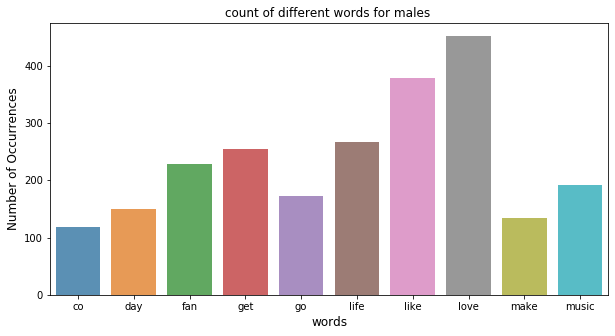

In [508]:
word_count  = mdf 
word_count = word_count[:10,]
plt.figure(figsize=(10,5))
sns.barplot(word_count.index, word_count.values, alpha=0.8)
plt.title('count of different words for males ')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('words', fontsize=12)
plt.show()

In [509]:
df_female = df3[df3['gender'] == "female"]

In [510]:
# TOP 10 OCCURING WORDS IN FEMALES DESCRIPTION

In [511]:
df_female.clean_description.str.split(expand=True).stack().value_counts()[:10]

love      428
life      281
girl      183
like      177
lover     161
writer    132
time      130
ig        122
music     121
one       119
dtype: int64

In [512]:
df_female.correct_description.str.split(expand=True).stack().value_counts()[:10]

love     444
in       308
life     298
a        276
girl     228
like     181
lover    165
time     137
inst     134
one      133
dtype: int64

In [513]:
df_female.clean_and_correct_description.str.split(expand=True).stack().value_counts()[:10]

love      445
life      300
girl      236
like      183
lover     170
time      143
inst      134
one       133
music     132
writer    132
dtype: int64

In [514]:
# TOP 10 OCCURING WORDS IN FEMALE TWEET'S TEXT

In [515]:
df_female.clean_text.str.split(expand=True).stack().value_counts()[:10]

like      308
get       283
day       263
one       260
love      239
go        212
time      206
people    181
got       158
know      153
dtype: int64

In [516]:
df_female.correct_text.str.split(expand=True).stack().value_counts()[:10]

one       318
like      309
get       290
day       276
love      252
a         248
go        219
time      216
people    181
in        164
dtype: int64

In [517]:
df_female.clean_and_correct_text.str.split(expand=True).stack().value_counts()[:10]

one       319
like      309
get       290
day       279
love      252
time      225
go        219
people    181
got       159
know      156
dtype: int64

In [518]:
# FINDING THE TOP 10 OCCURING WORDS IN DESCRIPTION AND TWEET TEXT FOR MEN
fdf = df_female.clean_and_correct_text.str.split(expand=True).stack().value_counts()[:10].add(df_female.clean_and_correct_description.str.split(expand=True).stack().value_counts()[:10], fill_value=0)

fdf.sort_values(ascending = False)

love      697.0
like      492.0
one       452.0
time      368.0
life      300.0
get       290.0
day       279.0
girl      236.0
go        219.0
people    181.0
lover     170.0
got       159.0
know      156.0
inst      134.0
writer    132.0
music     132.0
dtype: float64

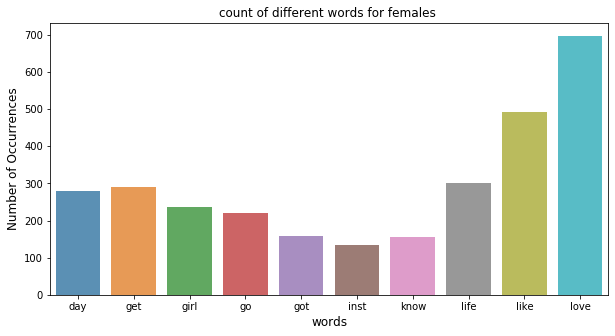

In [519]:
word_count  = fdf 
word_count = word_count[:10,]
plt.figure(figsize=(10,5))
sns.barplot(word_count.index, word_count.values, alpha=0.8)
plt.title('count of different words for females ')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('words', fontsize=12)
plt.show()

In [ ]:
# MOST OCCURING WORDS IN DESCRIPTION for males and females 

In [524]:
freq_top_desc = pd.Series(' '.join(df3['clean_and_correct_description']).split()).value_counts()[:10]
freq_top_desc

love      751
life      566
fan       335
music     324
like      307
writer    283
girl      267
time      263
lover     258
inst      243
dtype: int64

In [525]:
# MOST OCCURING WORDS IN TWEET'S TEXT AMONG ALL 3 CLASSES

In [526]:
freq_top_text = pd.Series(' '.join(df3['clean_and_correct_text']).split()).value_counts()[:10]
freq_top_text

like      563
one       545
get       545
day       429
time      420
love      398
go        392
people    316
new       295
got       291
dtype: int64

In [527]:
# LEAST OCCURING WORDS IN DESCRIPTIONS AMONG ALL 3 CLASSES 
freq_bottom_desc = pd.Series(' '.join(df3['clean_and_correct_description']).split()).value_counts()[10:]
freq_bottom_desc

sport         239
one           235
world         220
god           217
live          211
             ... 
boone           1
senna           1
irreverent      1
haydn           1
splitter        1
Length: 12200, dtype: int64

In [528]:
# LEAST OCCURING WORDS IN TWEET'S TEXT AMONG ALL 3 CLASSES
freq_bottom_text = pd.Series(' '.join(df3['clean_and_correct_text']).split()).value_counts()[10:]
freq_bottom_text

make              288
know              286
good              268
best              263
want              252
                 ... 
preview             1
concession          1
havodadlegolas      1
sinter              1
trapped             1
Length: 12483, dtype: int64

In [529]:
# LABEL ENCODING GENDER 

In [530]:
le = LabelEncoder()
df3['gender_label_encoded'] = le.fit_transform(df3['gender'])

In [531]:
df3.head()

gender  gender:confidence  \
0    male                1.0   
1    male                1.0   
3    male                1.0   
4  female                1.0   
5  female                1.0   

                                         description  \
0                              i sing my own rhythm    
1  i m the author of novels filled with family dr...   
3  mobile guy     ers  shazam  google  kleiner pe...   
4  ricky wilson the best frontman kaiser chiefs t...   
5                                 you don t know me    

                                                text          names  \
0  robbie e responds to critics after win against...        sheezy    
1  it felt like they were my friends and i was li...   davd burnett   
3  hi  jordanspieth   looking at the url   do you...    douggarland   
4  watching neighbours on sky  catching up with t...  wilford gemma   
5  ive seen people on the train with lamps  chair...  monroevicious   

      clean_names   correct_names clean_and_correct_names  \
0         sheezy           wheezy                 wheezy    
1   davd burnett    david burnett          david burnett    
3    douggarland     doug garland           doug garland    
4  wilford gemma    wilford gemma          wilford gemma    
5  monroevicious   monroe vicious         monroe vicious    

                                             context  \
0  robbie e responds to critics after win against...   
1  it felt like they were my friends and i was li...   
3  hi  jordanspieth   looking at the url   do you...   
4  watching neighbours on sky  catching up with t...   
5  ive seen people on the train with lamps  chair...   

                                   clean_description  \
0                                       sing rhythm    
1          author novel filled family drama romance    
3  mobile guy er shazam google kleiner perkins ya...   
4  ricky wilson best frontman kaiser chief best b...   
5                                              know    

                                          clean_text  \
0  robbie responds critic win eddie edward worldt...   
1         felt like friend living story retired ian    
3  hi jordanspieth looking url use ifttt typicall...   
4   watching neighbour sky catching neighbs xxx xxx    
5           ive seen people train lamp chair tv etc    

                                 correct_description  \
0                                        sing rhythm   
1           author novel filled family drama romance   
3  mobile guy or sham google cleaner perkins yaho...   
4  ricky wilson best front man kaiser chief best ...   
5                                               know   

                                        correct_text  \
0  robbie responds critic win eddie edward worldt...   
1          felt like friend living story retired ian   
3  i jordan piety looking urls use if tit typical...   
4     watching neighbour sky catching nights xxx xxx   
5           live seen people train lamp chair to etc   

                       clean_and_correct_description  \
0                                       sing rhythm    
1          author novel filled family drama romance    
3  mobile guy sham google cleaner perkins yahoo s...   
4  ricky wilson best front man kaiser chief best ...   
5                                              know    

                              clean_and_correct_text  \
0  robbie responds critic win eddie edward worldt...   
1         felt like friend living story retired ian    
3  jordan piety looking url use tit typically see...   
4     watching neighbour sky catching night xxx xxx    
5             live seen people train lamp chair etc    

                                       clean_context  \
0  robbie responds critic win eddie edward worldt...   
1  felt friend living story retired ian author no...   
3  hi jordanspieth looking url use ifttt typicall...   
4  watching neighbour sky catching neighbs xxx xx...   
5      ive seen people train lamp chair 

In [532]:
# SINCE MODEL NEEDS NUMERICL DATA SO DOING VECTORIZATION OF WORDS TO FEED INTO MODEl IN THE FORM OF MATRIX

In [533]:
cv = CountVectorizer()
sparse_matrix_desc = cv.fit_transform(df3['clean_and_correct_description'])

In [534]:
sparse_matrix_desc.shape

(8766, 12208)

In [535]:
sparse_matrix_text = cv.fit_transform(df3['clean_and_correct_text'])

In [536]:
sparse_matrix_text.shape

(8766, 12491)

In [537]:
sparse_matrix_context = cv.fit_transform(df3['clean_and_correct_context'])

In [538]:
sparse_matrix_context.shape

(8766, 17555)

In [539]:
sparse_matrix_names = cv.fit_transform(df3['clean_names'])

In [540]:
sparse_matrix_names.shape

(8766, 10000)

In [541]:
sparse_matrix_correct_names = cv.fit_transform(df3['clean_and_correct_names'])

In [542]:
sparse_matrix_correct_names.shape

(8766, 6626)

In [543]:
# HORIZONTALLY STACKING THE MATRICES 

In [544]:
sparse_matrix = hstack((sparse_matrix_context,sparse_matrix_correct_names))

In [545]:
#SPLITTING DATA INTO TRAIN AND TEST 

In [556]:
# from sklearn.model_selection import train_test_split

# max = 0
# nv = MultinomialNB()
# for i in range(0,11000):
#     X_train, X_test, Y_train, Y_test = train_test_split(sparse_matrix, df3['gender_label_encoded'],test_size = 0.1,random_state = i)#20
#     nv.fit(X_train, Y_train)
#     y_pred = nv.predict(X_test)
#     accuracy_score(Y_test, y_pred)
#     if accuracy_score(Y_test, y_pred) > max:
#         max = accuracy_score(Y_test, y_pred)
#         index = i

# print("max = ",max,"i= ",index)
# # print('Accuracy of naive bayes classifier on test set is : {}'.format(accuracy_score(Y_test, y_pred)))
    
# # X_train.shape, X_test.shape, Y_train.shape, Y_test.shape 10998,999,1999:80,

In [547]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(sparse_matrix, df3['gender_label_encoded'],test_size = 0.1,random_state = 1079)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((7889, 24181), (877, 24181), (7889,), (877,))

In [548]:
# NAIVE BAYES

In [549]:
nv = MultinomialNB()
nv.fit(X_train, Y_train)
y_pred = nv.predict(X_test)
# accuracy_score(Y_test, y_pred)
print('Accuracy of naive bayes classifier on test set is : {}'.format(accuracy_score(Y_test, y_pred)))

Accuracy of naive bayes classifier on test set is : 0.8072976054732041


In [550]:
# LOGISTIC REGRESSION

In [551]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {}'.format(accuracy_score(Y_test, y_pred)))

Accuracy of logistic regression classifier on test set: 0.7388825541619156


In [552]:
# SUPPORT VECTOR CLASSIFIER

In [553]:
svm = SVC()
svm.fit(X_train, Y_train)
y_pred = svm.predict(X_test)

print('Accuracy of support vector classifier on test set: {}'.format(accuracy_score(Y_test, y_pred)))

Accuracy of support vector classifier on test set: 0.7229190421892816


In [554]:
# EMSEMBLE MODELING

In [555]:
from sklearn.ensemble import VotingClassifier
ensemble = VotingClassifier(estimators=[('multinomial naive bayes', nv), ('logistic regression', logreg),('SVC',svm)], 
                            voting='hard', weights=[3,2,1]).fit(X_train,Y_train)
y_pred = ensemble.predict(X_test)

print('The accuracy for Multinomial Naive Bayes and Logistic Regression and SVC is:',accuracy_score(Y_test,y_pred))

The accuracy for Multinomial Naive Bayes and Logistic Regression and SVC is: 0.7924743443557583
